**1. Cài đặt thư viện và thay đổi đường dẫn \(Khi sử dụng google colab)**

In [1]:
!pip install nltk matplotlib py-rouge tqdm shap javalang

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/workspace/DeepCom

/content/drive/.shortcut-targets-by-id/1hQNAblWDSlYAFwpSz5-47rsxwUgg9j3j/workspace/DeepCom


**2. Import thư viện và cài đặt cần thiết**

In [4]:
import nltk

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
import models
import numpy as np
import utils
import data
import shap
import eval
import numpy as np
import matplotlib.pyplot as plt
import config
import os
import train
import pickle

_PAD = '<PAD>'
class BeamNode(object):

    def __init__(self, sentence_indices, log_probs, hidden):
        """

        :param sentence_indices: indices of words of current sentence (from root to current node)
        :param log_probs: log prob of node of sentence
        :param hidden: [1, 1, H]
        """
        self.sentence_indices = sentence_indices
        self.log_probs = log_probs
        self.hidden = hidden

    def extend_node(self, word_index, log_prob, hidden):
        return BeamNode(sentence_indices=self.sentence_indices + [word_index],
                        log_probs=self.log_probs + [log_prob],
                        hidden=hidden)

    def avg_log_prob(self):
        return sum(self.log_probs) / len(self.sentence_indices)

    def word_index(self):
        return self.sentence_indices[-1]


def beam_decode(model, batch_size, code_outputs: torch.Tensor,
                ast_outputs: torch.Tensor, decoder_hidden: torch.Tensor):
    """
    beam decode for one batch, feed one batch for decoder
    :param batch_size:
    :param code_outputs: [T, B, H]
    :param ast_outputs: [T, B, H]
    :param decoder_hidden: [1, B, H]
    :return: batch_sentences, [B, config.beam_top_sentence]
    """
    batch_sentences = []

    # B = 1
    for index_batch in range(batch_size):
        # for each input sentence
        single_decoder_hidden = decoder_hidden[:, index_batch, :].unsqueeze(1)  # [1, 1, H]
        single_code_output = code_outputs[:, index_batch, :].unsqueeze(1)  # [T, 1, H]
        single_ast_output = ast_outputs[:, index_batch, :].unsqueeze(1)  # [T, 1, H]

        root = BeamNode(sentence_indices=[utils.get_sos_index(nl_vocab)],
                        log_probs=[0.0],
                        hidden=single_decoder_hidden)

        current_nodes = [root]  # list of nodes to be further extended
        final_nodes = []  # list of end nodes

        for step in range(config.max_decode_steps):
            if len(current_nodes) == 0:
                break

            candidate_nodes = []  # list of nodes to be extended next step

            feed_inputs = []
            feed_hidden = []

            # B = len(current_nodes) except eos
            extend_nodes = []
            for node in current_nodes:
                # if current node is EOS
                if node.word_index() == utils.get_eos_index(nl_vocab):
                    final_nodes.append(node)
                    # if number of final nodes reach the beam width
                    if len(final_nodes) >= config.beam_width:
                        break
                    continue

                extend_nodes.append(node)

                decoder_inputs = node.word_index()
                single_decoder_hidden = node.hidden.clone().detach()     # [1, 1, H]

                feed_inputs.append(decoder_inputs)  # [B]
                feed_hidden.append(single_decoder_hidden)   # B x [1, 1, H]

            if len(extend_nodes) == 0:
                break

            feed_batch_size = len(feed_inputs)
            feed_code_outputs = single_code_output.repeat(1, feed_batch_size, 1)
            feed_ast_outputs = single_ast_output.repeat(1, feed_batch_size, 1)

            feed_inputs = torch.tensor(feed_inputs, device=config.device)   # [B]
            feed_hidden = torch.stack(feed_hidden, dim=2).squeeze(0)    # [1, B, H]

            # decoder_outputs: [B, nl_vocab_size]
            # new_decoder_hidden: [1, B, H]
            # attn_weights: [B, 1, T]
            decoder_outputs, new_decoder_hidden, \
                code_attn_weights, ast_attn_weights = model.decoder(inputs=feed_inputs,
                                                                          last_hidden=feed_hidden,
                                                                          code_outputs=feed_code_outputs,
                                                                          ast_outputs=feed_ast_outputs)

            # get top k words
            # log_probs: [B, beam_width]
            # word_indices: [B, beam_width]
            batch_log_probs, batch_word_indices = decoder_outputs.topk(config.beam_width)

            for index_node, node in enumerate(extend_nodes):
                log_probs = batch_log_probs[index_node]
                word_indices = batch_word_indices[index_node]
                hidden = new_decoder_hidden[:, index_node, :].unsqueeze(1)

                for i in range(config.beam_width):
                    log_prob = log_probs[i]
                    word_index = word_indices[i].item()

                    new_node = node.extend_node(word_index=word_index,
                                                log_prob=log_prob,
                                                hidden=hidden)
                    candidate_nodes.append(new_node)

            # sort candidate nodes by log_prb and select beam_width nodes
            candidate_nodes = sorted(candidate_nodes, key=lambda item: item.avg_log_prob(), reverse=True)
            current_nodes = candidate_nodes[: config.beam_width]

        final_nodes += current_nodes
        final_nodes = sorted(final_nodes, key=lambda item: item.avg_log_prob(), reverse=True)
        final_nodes = final_nodes[: config.beam_top_sentences]

        sentences = []
        for final_node in final_nodes:
            sentences.append(final_node.sentence_indices)

        batch_sentences.append(sentences)

    return batch_sentences
def translate_indices( batch_sentences):
      """
      translate indices to words for one batch
      :param batch_sentences: [B, config.beam_top_sentences, sentence_length]
      :return:
      """
      batch_words = []
      for sentences in batch_sentences:
          words = []
          for indices in sentences:
              for index in indices:
                  word = nl_vocab.index2word[index]
                  if utils.is_unk(word) or not utils.is_special_symbol(word):
                      words.append(word)
          batch_words.append(' '.join(words))
      return batch_words

code_vocab = utils.load_vocab_pk(config.code_vocab_path)
ast_vocab = utils.load_vocab_pk(config.ast_vocab_path)
nl_vocab = utils.load_vocab_pk(config.nl_vocab_path)
code_vocab_size = len(code_vocab)
ast_vocab_size = len(ast_vocab)
nl_vocab_size = len(nl_vocab)
dataset_dir = "../dataset_v2/"


INFO:root:Configurations this run are shown below.
INFO:root:Notes: If only runs test, the model configurations shown above is not the configurations of the model test runs on.
INFO:root:
INFO:root:Features and limitations:
INFO:root:dataset_dir: ../dataset_v2
INFO:root:use_cuda: True
INFO:root:device: cuda
INFO:root:use_coverage: False
INFO:root:use_pointer_gen: False
INFO:root:use_teacher_forcing: True
INFO:root:use_lr_decay: True
INFO:root:use_early_stopping: True
INFO:root:max_code_length: 313
INFO:root:max_nl_length: 30
INFO:root:min_nl_length: 4
INFO:root:max_decode_steps: 30
INFO:root:early_stopping_patience: 5
INFO:root:
INFO:root:Train configurations:
INFO:root:embedding_dim: 256
INFO:root:hidden_size: 256
INFO:root:decoder_dropout_rate: 0.5
INFO:root:teacher_forcing_ratio: 0.5
INFO:root:batch_size: 32
INFO:root:code_encoder_lr: 0.001
INFO:root:ast_encoder_lr: 0.001
INFO:root:reduce_hidden_lr: 0.001
INFO:root:decoder_lr: 0.0001
INFO:root:lr_decay_every: 1
INFO:root:lr_decay_ra

**3. Tạo câu tóm tắt cho model trong dataset**

In [6]:
def get_output_summary(model,x):
  x_temp=[[x]]
  code_original=x[0]
  ast_original=x[1]
  comment_original=x[2]
  x=utils.unsort_collate_fn(x_temp,code_vocab,ast_vocab,nl_vocab)
  code_outputs, ast_outputs, decoder_hidden = model(x, 1, nl_vocab, is_test=True)
  batch_sentences = beam_decode(model=model,batch_size=1,
                                                code_outputs=code_outputs,
                                                ast_outputs=ast_outputs,
                                                decoder_hidden=decoder_hidden)

              # translate indices into words both for candidates
  candidates = translate_indices(batch_sentences)
  return candidates[0]

def get_output_by_project(project,num_data,num_fold,item=None,condition=None,limit_meteor=None):
  project2sources = { #ranking
      'spring-boot': ['spring-framework', 'dubbo', 'flink', 'kafka', 'spring-security', 'guava', 'ExoPlayer'],
      'spring-framework': ['spring-boot', 'dubbo', 'flink', 'spring-security', 'kafka', 'ExoPlayer', 'guava'],
      'spring-security': ['spring-framework', 'spring-boot', 'dubbo', 'kafka', 'flink', 'ExoPlayer' ,'guava'],
      'guava': ['flink', 'dubbo', 'spring-framework', 'kafka', 'ExoPlayer', 'spring-boot', 'dagger'],
      'ExoPlayer': ['flink', 'spring-framework', 'guava', 'kafka', 'spring-boot', 'dubbo', 'spring-security'],
      'kafka': ['flink', 'spring-boot', 'spring-framework', 'dubbo', 'guava', 'ExoPlayer', 'spring-security'],
      'dubbo': ['spring-framework', 'spring-boot', 'flink', 'kafka', 'guava', 'spring-security', 'dagger'],
      'flink': ['kafka', 'spring-framework', 'dubbo', 'spring-boot', 'guava', 'ExoPlayer', 'spring-security'],
  }
  project2path={
      'dubbo':'model/dubbo_meta_3/best_epoch-0.pt',
      'spring-boot':'model/spring-boot_meta_3/best_epoch-3.pt',
      'spring-security': 'model/spring-security_meta_3/best_epoch-0.pt',
      'guava': 'model/guava_meta_3/best_epoch-1.pt',
      'ExoPlayer':'model/ExoPlayer_meta_3/best_epoch-4.pt',
      'kafka':'model/kafka_meta_3/best_epoch-1.pt',
      'flink': 'model/flink_meta_3/best_epoch-4.pt',
      'spring-framework':'model/spring-framework_meta_3/best_epoch-0.pt',
  }
  with open(f'../dataset_v2/original/{project}/all_unpreprocess.code', 'rb') as handle:
      code_dict = pickle.loads(handle.read())
  with open(f'../dataset_v2/original/{project}/all_truncated_unlowered_dict.code', 'rb') as handle1:
      code_dict_unlowerd = pickle.loads(handle1.read())
  validating_project=project2sources[project][3]
  train_instance = train.Train(vocab_file_path=(config.code_vocab_path, config.ast_vocab_path, config.nl_vocab_path),model_file_path=project2path[project],
                                    code_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.code')
                                    ,ast_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.sbt'),
                                    nl_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.comment'),batch_size=config.support_batch_size,
                                    code_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.code'),nl_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.comment'),
                                          ast_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated.sbt')
                                          ,num_of_data=num_data,save_file=False,seed=0,is_test=True)
  best_model_test_dict=train_instance.run_train()
  train_instance_baseline = train.Train(vocab_file_path=(config.code_vocab_path, config.ast_vocab_path, config.nl_vocab_path),model_file_path=f'model/{project}_base_3/best_epoch-0_batch-last.pt',
                                    code_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.code')
                                    ,ast_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.sbt'),
                                    nl_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.comment'),batch_size=config.support_batch_size,
                                    code_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.code'),nl_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.comment'),
                                          ast_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated.sbt')
                                          ,num_of_data=num_data,save_file=False,seed=0,is_test=True)
  best_model_test_dict_baseline=train_instance_baseline.run_train()
  model_meta=models.Model(code_vocab_size=code_vocab_size,
                                ast_vocab_size=ast_vocab_size,
                                nl_vocab_size=nl_vocab_size,
                                model_state_dict=best_model_test_dict
                                ,is_eval=True)
  model_baseline=models.Model(code_vocab_size=code_vocab_size,
                                ast_vocab_size=ast_vocab_size,
                                nl_vocab_size=nl_vocab_size,
                                model_state_dict=best_model_test_dict_baseline
                                ,is_eval=True)

  dataset_test = data.CodePtrDataset(os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_test.code'),
                                      os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_test.sbt'),
                                      os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_test.comment'))
  #x=dataset_test.__getitem__(181)
  #visualize_attention(x,model,code_vocab,ast_vocab,nl_vocab,f'result_images/guava/{181}.png')
  if item is not None:
    x=dataset_test.__getitem__(item)
    comment_original=' '.join(x[2])
    code_original=code_dict[code_dict_unlowerd[' '.join(x[0]).strip()]]
    model=model_meta
    summary_meta=get_output_summary(model_meta,x)
    model=model_baseline
    summary_baseline=get_output_summary(model_baseline,x)
    print(code_original)
    print('Reference: ',comment_original)
    print('MAML: ',summary_meta)
    print('Baseline: ',summary_baseline)
  else:
    for i in range(len(dataset_test)):
      x=dataset_test.__getitem__(i)
      comment_original=' '.join(x[2])
      if len(x[0])>50:
        continue
      if condition is None or condition in comment_original:
        code_original=code_dict[code_dict_unlowerd[' '.join(x[0]).strip()]]
        summary_meta=get_output_summary(model_meta,x)
        summary_baseline=get_output_summary(model_baseline,x)
        meteor_score_meta=utils.meteor_score(comment_original.split(),summary_meta.split())
        meteor_score_baseline=utils.meteor_score(comment_original.split(),summary_baseline.split())
        if limit_meteor is None or (meteor_score_meta>=limit_meteor):
          print(code_original)
          print('Reference: ',comment_original)
          print('MAML: ',summary_meta)
          print('Baseline: ',summary_baseline)

INFO:root:Epoch 1, batch 0: 5.011938095092773
INFO:root:epoch: 1/50, batch: 0/200, avg loss: 5.0119
INFO:root:Epoch 1, batch 0/16: 5.011938095092773
INFO:root:Epoch 1, batch 1: 5.839882850646973


time:  0h  0min  1s 832ms, remaining: 10h 12min 20s 527ms, epoch:  1/50, batch:   0/200, percent complete:   0.00%, avg loss: 5.0119
Epoch 1, batch 0/16: 5.011938095092773


INFO:root:Epoch 1, batch 2: 5.044039726257324
INFO:root:Epoch 1, batch 3: 5.021570205688477
INFO:root:Epoch 1, batch 4: 5.480655670166016
INFO:root:Epoch 1, batch 5: 4.7666449546813965
INFO:root:Epoch 1, batch 6: 4.4589056968688965
INFO:root:Epoch 1, batch 7: 5.349313735961914
INFO:root:Epoch 1, batch 8: 5.023759841918945
INFO:root:Epoch 1, batch 9: 5.000979423522949
INFO:root:Epoch 1, batch 10: 5.379406929016113
INFO:root:Epoch 1, batch 11: 5.0768513679504395
INFO:root:Epoch 1, batch 12: 5.531864643096924
INFO:root:Epoch 1, batch 13: 5.120417594909668
INFO:root:Epoch 1, batch 14: 4.440282821655273
INFO:root:Epoch 1, batch 15: 4.66371488571167
INFO:root:Epoch 1, batch 16: 4.813164234161377
INFO:root:Epoch 1, batch 17: 5.640327453613281
INFO:root:Epoch 1, batch 18: 5.124908924102783
INFO:root:Epoch 1, batch 19: 4.623758316040039
INFO:root:Epoch 1, batch 20: 5.346888542175293
INFO:root:Epoch 1, batch 21: 4.749632835388184
INFO:root:Epoch 1, batch 22: 4.830307483673096
INFO:root:Epoch 1, 

time:  0h  0min 39s  55ms, remaining:  0h 31min 53s 397ms, epoch:  1/50, batch: 200/200, percent complete:   2.00%, avg loss: 4.6156
Epoch 1, batch 200/16: 923.126814365387


INFO:root:Epoch 1, batch 202: 3.755537509918213
INFO:root:Epoch 1, batch 203: 3.723599672317505
INFO:root:Epoch 1, batch 204: 4.3530778884887695
INFO:root:Epoch 1, batch 205: 4.601142883300781
INFO:root:Epoch 1, batch 206: 4.240762710571289
INFO:root:Epoch 1, batch 207: 4.075328350067139
INFO:root:Epoch 1, batch 208: 4.514953136444092
INFO:root:Epoch 1, batch 209: 5.074515342712402
INFO:root:Epoch 1, batch 210: 4.21791934967041
INFO:root:Epoch 1, batch 211: 4.817676544189453
INFO:root:Epoch 1, batch 212: 4.001509666442871
INFO:root:Epoch 1, batch 213: 4.31928014755249
INFO:root:Epoch 1, batch 214: 4.34269380569458
INFO:root:Epoch 1, batch 215: 4.340554237365723
INFO:root:Epoch 1, batch 216: 4.484263896942139
INFO:root:Epoch 1, batch 217: 4.230805397033691
INFO:root:Epoch 1, batch 218: 4.344665050506592
INFO:root:Epoch 1, batch 219: 4.106696605682373
INFO:root:Epoch 1, batch 220: 3.764173746109009
INFO:root:Epoch 1, batch 221: 4.319431781768799
INFO:root:Epoch 1, batch 222: 4.4677262306

time:  0h  1min 16s  70ms, remaining:  0h 30min 27s 918ms, epoch:  1/50, batch: 400/200, percent complete:   4.00%, avg loss: 4.1289
Epoch 1, batch 400/15: 825.7803835868835

Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0899.


Validate completed, avg loss: 5.0899.



INFO:root:Epoch 2, batch 0: 2.9323737621307373
INFO:root:epoch: 2/50, batch: 0/200, avg loss: 2.9324
INFO:root:Epoch 2, batch 0/16: 2.9323737621307373
INFO:root:Epoch 2, batch 1: 3.55568528175354


time:  0h  1min 19s 618ms, remaining:  1h  4min 51s 425ms, epoch:  2/50, batch:   0/200, percent complete:   2.00%, avg loss: 2.9324
Epoch 2, batch 0/16: 2.9323737621307373


INFO:root:Epoch 2, batch 2: 3.672849178314209
INFO:root:Epoch 2, batch 3: 3.856325149536133
INFO:root:Epoch 2, batch 4: 3.8433873653411865
INFO:root:Epoch 2, batch 5: 3.7800076007843018
INFO:root:Epoch 2, batch 6: 3.5529749393463135
INFO:root:Epoch 2, batch 7: 3.0547690391540527
INFO:root:Epoch 2, batch 8: 3.1280295848846436
INFO:root:Epoch 2, batch 9: 2.9732792377471924
INFO:root:Epoch 2, batch 10: 2.8648955821990967
INFO:root:Epoch 2, batch 11: 3.083967924118042
INFO:root:Epoch 2, batch 12: 3.023958444595337
INFO:root:Epoch 2, batch 13: 2.9835751056671143
INFO:root:Epoch 2, batch 14: 3.207693338394165
INFO:root:Epoch 2, batch 15: 2.5463218688964844
INFO:root:Epoch 2, batch 16: 3.3033218383789062
INFO:root:Epoch 2, batch 17: 2.771906614303589
INFO:root:Epoch 2, batch 18: 3.278221607208252
INFO:root:Epoch 2, batch 19: 3.2821552753448486
INFO:root:Epoch 2, batch 20: 3.0633294582366943
INFO:root:Epoch 2, batch 21: 3.7128772735595703
INFO:root:Epoch 2, batch 22: 3.2208471298217773
INFO:ro

time:  0h  1min 56s 798ms, remaining:  0h 46min 42s 938ms, epoch:  2/50, batch: 200/200, percent complete:   4.00%, avg loss: 3.2957
Epoch 2, batch 200/16: 659.143862247467


INFO:root:Epoch 2, batch 201: 3.1865742206573486
INFO:root:Epoch 2, batch 202: 3.255783796310425
INFO:root:Epoch 2, batch 203: 3.536407709121704
INFO:root:Epoch 2, batch 204: 2.8283681869506836
INFO:root:Epoch 2, batch 205: 3.501427173614502
INFO:root:Epoch 2, batch 206: 3.6296725273132324
INFO:root:Epoch 2, batch 207: 3.379418134689331
INFO:root:Epoch 2, batch 208: 2.905585289001465
INFO:root:Epoch 2, batch 209: 3.337534189224243
INFO:root:Epoch 2, batch 210: 2.621305227279663
INFO:root:Epoch 2, batch 211: 3.6355743408203125
INFO:root:Epoch 2, batch 212: 3.2329370975494385
INFO:root:Epoch 2, batch 213: 2.923067808151245
INFO:root:Epoch 2, batch 214: 3.300333023071289
INFO:root:Epoch 2, batch 215: 3.1223039627075195
INFO:root:Epoch 2, batch 216: 3.5899717807769775
INFO:root:Epoch 2, batch 217: 3.404240369796753
INFO:root:Epoch 2, batch 218: 3.0585150718688965
INFO:root:Epoch 2, batch 219: 3.622297763824463
INFO:root:Epoch 2, batch 220: 4.035680294036865
INFO:root:Epoch 2, batch 221: 3.

time:  0h  2min 34s 285ms, remaining:  0h 40min 19s 153ms, epoch:  2/50, batch: 400/200, percent complete:   6.00%, avg loss: 3.2698
Epoch 2, batch 400/15: 653.9649119377136

Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2445.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.2445.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 3, batch 0: 2.8271172046661377
INFO:root:epoch: 3/50, batch: 0/200, avg loss: 2.8271
INFO:root:Epoch 3, batch 0/16: 2.8271172046661377


time:  0h  2min 37s 543ms, remaining:  1h  2min 56s 132ms, epoch:  3/50, batch:   0/200, percent complete:   4.00%, avg loss: 2.8271
Epoch 3, batch 0/16: 2.8271172046661377


INFO:root:Epoch 3, batch 1: 2.339401960372925
INFO:root:Epoch 3, batch 2: 2.4709677696228027
INFO:root:Epoch 3, batch 3: 2.244196891784668
INFO:root:Epoch 3, batch 4: 3.0354316234588623
INFO:root:Epoch 3, batch 5: 2.6969730854034424
INFO:root:Epoch 3, batch 6: 2.809802293777466
INFO:root:Epoch 3, batch 7: 2.416381597518921
INFO:root:Epoch 3, batch 8: 1.8355125188827515
INFO:root:Epoch 3, batch 9: 2.3475992679595947
INFO:root:Epoch 3, batch 10: 2.2705984115600586
INFO:root:Epoch 3, batch 11: 2.3542733192443848
INFO:root:Epoch 3, batch 12: 2.6072354316711426
INFO:root:Epoch 3, batch 13: 2.1701931953430176
INFO:root:Epoch 3, batch 14: 1.9127951860427856
INFO:root:Epoch 3, batch 15: 2.813368797302246
INFO:root:Epoch 3, batch 16: 2.550039052963257
INFO:root:Epoch 3, batch 17: 2.83805513381958
INFO:root:Epoch 3, batch 18: 2.2476613521575928
INFO:root:Epoch 3, batch 19: 2.6382782459259033
INFO:root:Epoch 3, batch 20: 2.840235948562622
INFO:root:Epoch 3, batch 21: 2.415910243988037
INFO:root:E

time:  0h  3min 14s 819ms, remaining:  0h 50min 52s   4ms, epoch:  3/50, batch: 200/200, percent complete:   6.00%, avg loss: 2.5867
Epoch 3, batch 200/16: 517.3334509134293


INFO:root:Epoch 3, batch 201: 2.84407377243042
INFO:root:Epoch 3, batch 202: 2.641937732696533
INFO:root:Epoch 3, batch 203: 2.448110818862915
INFO:root:Epoch 3, batch 204: 2.7014870643615723
INFO:root:Epoch 3, batch 205: 2.6673219203948975
INFO:root:Epoch 3, batch 206: 2.9401168823242188
INFO:root:Epoch 3, batch 207: 2.3324577808380127
INFO:root:Epoch 3, batch 208: 2.8590269088745117
INFO:root:Epoch 3, batch 209: 3.140676498413086
INFO:root:Epoch 3, batch 210: 2.949781656265259
INFO:root:Epoch 3, batch 211: 3.109172821044922
INFO:root:Epoch 3, batch 212: 2.572596311569214
INFO:root:Epoch 3, batch 213: 3.2136001586914062
INFO:root:Epoch 3, batch 214: 3.037518262863159
INFO:root:Epoch 3, batch 215: 2.946700096130371
INFO:root:Epoch 3, batch 216: 3.0328001976013184
INFO:root:Epoch 3, batch 217: 3.149142265319824
INFO:root:Epoch 3, batch 218: 2.3085548877716064
INFO:root:Epoch 3, batch 219: 1.9173603057861328
INFO:root:Epoch 3, batch 220: 2.302124261856079
INFO:root:Epoch 3, batch 221: 2.

time:  0h  3min 52s 237ms, remaining:  0h 44min 32s 427ms, epoch:  3/50, batch: 400/200, percent complete:   8.00%, avg loss: 2.6493
Epoch 3, batch 400/15: 529.8602722883224

Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5011.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.6258162260055542
INFO:root:epoch: 4/50, batch: 0/200, avg loss: 1.6258
INFO:root:Epoch 4, batch 0/16: 1.6258162260055542


Validate completed, avg loss: 5.5011.

EarlyStopping counter: 2 out of 5.

time:  0h  3min 55s 406ms, remaining:  1h  1min 24s 780ms, epoch:  4/50, batch:   0/200, percent complete:   6.00%, avg loss: 1.6258
Epoch 4, batch 0/16: 1.6258162260055542


INFO:root:Epoch 4, batch 1: 1.966775894165039
INFO:root:Epoch 4, batch 2: 1.9475685358047485
INFO:root:Epoch 4, batch 3: 2.0937116146087646
INFO:root:Epoch 4, batch 4: 1.7120966911315918
INFO:root:Epoch 4, batch 5: 2.1158804893493652
INFO:root:Epoch 4, batch 6: 1.8781406879425049
INFO:root:Epoch 4, batch 7: 1.9006036520004272
INFO:root:Epoch 4, batch 8: 2.5945193767547607
INFO:root:Epoch 4, batch 9: 2.1220366954803467
INFO:root:Epoch 4, batch 10: 2.503326416015625
INFO:root:Epoch 4, batch 11: 1.7195428609848022
INFO:root:Epoch 4, batch 12: 2.1747210025787354
INFO:root:Epoch 4, batch 13: 2.505693197250366
INFO:root:Epoch 4, batch 14: 2.472132682800293
INFO:root:Epoch 4, batch 15: 1.7015012502670288
INFO:root:Epoch 4, batch 16: 1.833216667175293
INFO:root:Epoch 4, batch 17: 1.88825523853302
INFO:root:Epoch 4, batch 18: 1.6711697578430176
INFO:root:Epoch 4, batch 19: 2.194488286972046
INFO:root:Epoch 4, batch 20: 1.7486768960952759
INFO:root:Epoch 4, batch 21: 1.7514344453811646
INFO:root

time:  0h  4min 32s 863ms, remaining:  0h 52min 17s 802ms, epoch:  4/50, batch: 200/200, percent complete:   8.00%, avg loss: 2.0272
Epoch 4, batch 200/16: 405.43250238895416


INFO:root:Epoch 4, batch 202: 2.0829126834869385
INFO:root:Epoch 4, batch 203: 2.1671109199523926
INFO:root:Epoch 4, batch 204: 2.3121397495269775
INFO:root:Epoch 4, batch 205: 2.307342290878296
INFO:root:Epoch 4, batch 206: 1.7628194093704224
INFO:root:Epoch 4, batch 207: 1.6841012239456177
INFO:root:Epoch 4, batch 208: 2.30226731300354
INFO:root:Epoch 4, batch 209: 2.3503808975219727
INFO:root:Epoch 4, batch 210: 1.678659200668335
INFO:root:Epoch 4, batch 211: 1.5974000692367554
INFO:root:Epoch 4, batch 212: 2.213528633117676
INFO:root:Epoch 4, batch 213: 2.2054874897003174
INFO:root:Epoch 4, batch 214: 2.3624885082244873
INFO:root:Epoch 4, batch 215: 2.0147993564605713
INFO:root:Epoch 4, batch 216: 1.5217465162277222
INFO:root:Epoch 4, batch 217: 1.915948748588562
INFO:root:Epoch 4, batch 218: 2.2891016006469727
INFO:root:Epoch 4, batch 219: 2.1267147064208984
INFO:root:Epoch 4, batch 220: 2.1493582725524902
INFO:root:Epoch 4, batch 221: 2.511977195739746
INFO:root:Epoch 4, batch 22

time:  0h  5min 10s 264ms, remaining:  0h 46min 33s 833ms, epoch:  4/50, batch: 400/200, percent complete:  10.00%, avg loss: 2.1370
Epoch 4, batch 400/15: 427.4095972776413

Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7363.
INFO:root:EarlyStopping counter: 3 out of 5.


Validate completed, avg loss: 5.7363.

EarlyStopping counter: 3 out of 5.



INFO:root:Epoch 5, batch 0: 1.6594061851501465
INFO:root:epoch: 5/50, batch: 0/200, avg loss: 1.6594
INFO:root:Epoch 5, batch 0/16: 1.6594061851501465
INFO:root:Epoch 5, batch 1: 1.7574496269226074


time:  0h  5min 13s 542ms, remaining:  1h  0min  3s 293ms, epoch:  5/50, batch:   0/200, percent complete:   8.00%, avg loss: 1.6594
Epoch 5, batch 0/16: 1.6594061851501465


INFO:root:Epoch 5, batch 2: 1.6676347255706787
INFO:root:Epoch 5, batch 3: 1.9300611019134521
INFO:root:Epoch 5, batch 4: 1.134495496749878
INFO:root:Epoch 5, batch 5: 1.3604793548583984
INFO:root:Epoch 5, batch 6: 1.7014737129211426
INFO:root:Epoch 5, batch 7: 1.793800950050354
INFO:root:Epoch 5, batch 8: 1.7619949579238892
INFO:root:Epoch 5, batch 9: 1.6035950183868408
INFO:root:Epoch 5, batch 10: 1.5461493730545044
INFO:root:Epoch 5, batch 11: 2.0202834606170654
INFO:root:Epoch 5, batch 12: 0.9978626370429993
INFO:root:Epoch 5, batch 13: 1.494591474533081
INFO:root:Epoch 5, batch 14: 1.097080945968628
INFO:root:Epoch 5, batch 15: 1.4295129776000977
INFO:root:Epoch 5, batch 16: 1.6594411134719849
INFO:root:Epoch 5, batch 17: 1.7823072671890259
INFO:root:Epoch 5, batch 18: 1.6138081550598145
INFO:root:Epoch 5, batch 19: 1.6679686307907104
INFO:root:Epoch 5, batch 20: 1.8500690460205078
INFO:root:Epoch 5, batch 21: 1.4196687936782837
INFO:root:Epoch 5, batch 22: 1.491716742515564
INFO:

time:  0h  5min 51s 404ms, remaining:  0h 52min 42s 533ms, epoch:  5/50, batch: 200/200, percent complete:  10.00%, avg loss: 1.6968
Epoch 5, batch 200/16: 339.3676492571831


INFO:root:Epoch 5, batch 202: 1.8160935640335083
INFO:root:Epoch 5, batch 203: 1.5756365060806274
INFO:root:Epoch 5, batch 204: 1.8902395963668823
INFO:root:Epoch 5, batch 205: 2.1192760467529297
INFO:root:Epoch 5, batch 206: 1.476910948753357
INFO:root:Epoch 5, batch 207: 1.5407310724258423
INFO:root:Epoch 5, batch 208: 1.5170726776123047
INFO:root:Epoch 5, batch 209: 1.67245352268219
INFO:root:Epoch 5, batch 210: 1.5602468252182007
INFO:root:Epoch 5, batch 211: 1.6650277376174927
INFO:root:Epoch 5, batch 212: 1.274448037147522
INFO:root:Epoch 5, batch 213: 1.7444915771484375
INFO:root:Epoch 5, batch 214: 1.7687602043151855
INFO:root:Epoch 5, batch 215: 1.7767030000686646
INFO:root:Epoch 5, batch 216: 2.0638716220855713
INFO:root:Epoch 5, batch 217: 1.3154752254486084
INFO:root:Epoch 5, batch 218: 1.8096274137496948
INFO:root:Epoch 5, batch 219: 2.00368332862854
INFO:root:Epoch 5, batch 220: 1.4464192390441895
INFO:root:Epoch 5, batch 221: 2.2028579711914062
INFO:root:Epoch 5, batch 2

time:  0h  6min 28s 581ms, remaining:  0h 47min 30s 862ms, epoch:  5/50, batch: 400/200, percent complete:  12.00%, avg loss: 1.7661
Epoch 5, batch 400/15: 353.21974527835846

Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.9279.
INFO:root:EarlyStopping counter: 4 out of 5.


Validate completed, avg loss: 5.9279.

EarlyStopping counter: 4 out of 5.



INFO:root:Epoch 6, batch 0: 1.465789794921875
INFO:root:epoch: 6/50, batch: 0/200, avg loss: 1.4658
INFO:root:Epoch 6, batch 0/16: 1.465789794921875


time:  0h  6min 32s  48ms, remaining:  0h 58min 46s 477ms, epoch:  6/50, batch:   0/200, percent complete:  10.00%, avg loss: 1.4658
Epoch 6, batch 0/16: 1.465789794921875


INFO:root:Epoch 6, batch 1: 1.1354618072509766
INFO:root:Epoch 6, batch 2: 1.3090201616287231
INFO:root:Epoch 6, batch 3: 2.0353848934173584
INFO:root:Epoch 6, batch 4: 1.3632147312164307
INFO:root:Epoch 6, batch 5: 1.292548656463623
INFO:root:Epoch 6, batch 6: 1.5457656383514404
INFO:root:Epoch 6, batch 7: 1.4300286769866943
INFO:root:Epoch 6, batch 8: 1.2323826551437378
INFO:root:Epoch 6, batch 9: 1.1433568000793457
INFO:root:Epoch 6, batch 10: 1.1679452657699585
INFO:root:Epoch 6, batch 11: 1.175398349761963
INFO:root:Epoch 6, batch 12: 1.4126067161560059
INFO:root:Epoch 6, batch 13: 1.426451325416565
INFO:root:Epoch 6, batch 14: 1.193368911743164
INFO:root:Epoch 6, batch 15: 0.9593158960342407
INFO:root:Epoch 6, batch 16: 1.4957376718521118
INFO:root:Epoch 6, batch 17: 1.4308894872665405
INFO:root:Epoch 6, batch 18: 0.8863341212272644
INFO:root:Epoch 6, batch 19: 1.5427674055099487
INFO:root:Epoch 6, batch 20: 1.038474440574646
INFO:root:Epoch 6, batch 21: 1.5630441904067993
INFO:r

time:  0h  7min  9s 699ms, remaining:  0h 52min 31s  35ms, epoch:  6/50, batch: 200/200, percent complete:  12.00%, avg loss: 1.3901
Epoch 6, batch 200/16: 278.020088493824


INFO:root:Epoch 6, batch 202: 0.8589683175086975
INFO:root:Epoch 6, batch 203: 1.62435781955719
INFO:root:Epoch 6, batch 204: 1.5716943740844727
INFO:root:Epoch 6, batch 205: 1.8817278146743774
INFO:root:Epoch 6, batch 206: 1.7283098697662354
INFO:root:Epoch 6, batch 207: 1.6036080121994019
INFO:root:Epoch 6, batch 208: 1.3988101482391357
INFO:root:Epoch 6, batch 209: 1.3170093297958374
INFO:root:Epoch 6, batch 210: 1.5069619417190552
INFO:root:Epoch 6, batch 211: 1.3392071723937988
INFO:root:Epoch 6, batch 212: 1.534676194190979
INFO:root:Epoch 6, batch 213: 1.0028752088546753
INFO:root:Epoch 6, batch 214: 1.4173617362976074
INFO:root:Epoch 6, batch 215: 1.6723768711090088
INFO:root:Epoch 6, batch 216: 1.35829758644104
INFO:root:Epoch 6, batch 217: 1.5404913425445557
INFO:root:Epoch 6, batch 218: 1.4052661657333374
INFO:root:Epoch 6, batch 219: 1.223008394241333
INFO:root:Epoch 6, batch 220: 1.3563768863677979
INFO:root:Epoch 6, batch 221: 1.5521093606948853
INFO:root:Epoch 6, batch 2

time:  0h  7min 48s  17ms, remaining:  0h 47min 56s  79ms, epoch:  6/50, batch: 400/200, percent complete:  14.00%, avg loss: 1.4862
Epoch 6, batch 400/15: 297.2445032596588

Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.1539.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.1539.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.85916805267334
INFO:root:epoch: 1/50, batch: 0/200, avg loss: 5.8592
INFO:root:Epoch 1, batch 0/16: 5.85916805267334
INFO:root:Epoch 1, batch 1: 6.343692302703857


time:  0h  0min  0s 267ms, remaining:  1h 29min 23s 440ms, epoch:  1/50, batch:   0/200, percent complete:   0.00%, avg loss: 5.8592
Epoch 1, batch 0/16: 5.85916805267334


INFO:root:Epoch 1, batch 2: 5.773146629333496
INFO:root:Epoch 1, batch 3: 5.328405380249023
INFO:root:Epoch 1, batch 4: 6.249884128570557
INFO:root:Epoch 1, batch 5: 4.820427417755127
INFO:root:Epoch 1, batch 6: 4.916557312011719
INFO:root:Epoch 1, batch 7: 5.671966552734375
INFO:root:Epoch 1, batch 8: 5.468064785003662
INFO:root:Epoch 1, batch 9: 5.705576419830322
INFO:root:Epoch 1, batch 10: 5.902860164642334
INFO:root:Epoch 1, batch 11: 5.499740123748779
INFO:root:Epoch 1, batch 12: 5.849111557006836
INFO:root:Epoch 1, batch 13: 5.636141300201416
INFO:root:Epoch 1, batch 14: 4.8952484130859375
INFO:root:Epoch 1, batch 15: 5.19976282119751
INFO:root:Epoch 1, batch 16: 5.861108779907227
INFO:root:Epoch 1, batch 17: 6.150829315185547
INFO:root:Epoch 1, batch 18: 5.913908958435059
INFO:root:Epoch 1, batch 19: 5.209554195404053
INFO:root:Epoch 1, batch 20: 5.7053022384643555
INFO:root:Epoch 1, batch 21: 4.620422840118408
INFO:root:Epoch 1, batch 22: 4.8684282302856445
INFO:root:Epoch 1, 

time:  0h  0min 38s  86ms, remaining:  0h 31min  5s 924ms, epoch:  1/50, batch: 200/200, percent complete:   2.00%, avg loss: 4.8683
Epoch 1, batch 200/16: 973.652811050415


INFO:root:Epoch 1, batch 202: 4.249773979187012
INFO:root:Epoch 1, batch 203: 3.958805799484253
INFO:root:Epoch 1, batch 204: 4.581361770629883
INFO:root:Epoch 1, batch 205: 4.594135284423828
INFO:root:Epoch 1, batch 206: 4.285064220428467
INFO:root:Epoch 1, batch 207: 4.320034980773926
INFO:root:Epoch 1, batch 208: 4.446998596191406
INFO:root:Epoch 1, batch 209: 4.94481086730957
INFO:root:Epoch 1, batch 210: 4.511056900024414
INFO:root:Epoch 1, batch 211: 4.912852764129639
INFO:root:Epoch 1, batch 212: 4.340375900268555
INFO:root:Epoch 1, batch 213: 4.444368839263916
INFO:root:Epoch 1, batch 214: 4.511792182922363
INFO:root:Epoch 1, batch 215: 4.630964756011963
INFO:root:Epoch 1, batch 216: 5.020511150360107
INFO:root:Epoch 1, batch 217: 4.655919551849365
INFO:root:Epoch 1, batch 218: 4.025178909301758
INFO:root:Epoch 1, batch 219: 4.437211036682129
INFO:root:Epoch 1, batch 220: 4.0271735191345215
INFO:root:Epoch 1, batch 221: 4.853298187255859
INFO:root:Epoch 1, batch 222: 4.82054519

time:  0h  1min 15s 457ms, remaining:  0h 30min 13s 190ms, epoch:  1/50, batch: 400/200, percent complete:   4.00%, avg loss: 4.2933
Epoch 1, batch 400/15: 858.654547214508

Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1056.


Validate completed, avg loss: 5.1056.



INFO:root:Epoch 2, batch 0: 3.1316654682159424
INFO:root:epoch: 2/50, batch: 0/200, avg loss: 3.1317
INFO:root:Epoch 2, batch 0/16: 3.1316654682159424
INFO:root:Epoch 2, batch 1: 3.484981060028076


time:  0h  1min 19s  40ms, remaining:  1h  4min 23s 175ms, epoch:  2/50, batch:   0/200, percent complete:   2.00%, avg loss: 3.1317
Epoch 2, batch 0/16: 3.1316654682159424


INFO:root:Epoch 2, batch 2: 3.4851577281951904
INFO:root:Epoch 2, batch 3: 3.9482154846191406
INFO:root:Epoch 2, batch 4: 3.624110221862793
INFO:root:Epoch 2, batch 5: 3.9956367015838623
INFO:root:Epoch 2, batch 6: 3.940946102142334
INFO:root:Epoch 2, batch 7: 3.059890031814575
INFO:root:Epoch 2, batch 8: 3.4150357246398926
INFO:root:Epoch 2, batch 9: 3.4333369731903076
INFO:root:Epoch 2, batch 10: 3.157994508743286
INFO:root:Epoch 2, batch 11: 3.417207717895508
INFO:root:Epoch 2, batch 12: 3.4056594371795654
INFO:root:Epoch 2, batch 13: 3.179335355758667
INFO:root:Epoch 2, batch 14: 3.490865468978882
INFO:root:Epoch 2, batch 15: 2.6184632778167725
INFO:root:Epoch 2, batch 16: 3.3192267417907715
INFO:root:Epoch 2, batch 17: 2.9659035205841064
INFO:root:Epoch 2, batch 18: 3.7634057998657227
INFO:root:Epoch 2, batch 19: 3.2108654975891113
INFO:root:Epoch 2, batch 20: 3.5226552486419678
INFO:root:Epoch 2, batch 21: 3.3217337131500244
INFO:root:Epoch 2, batch 22: 3.18007230758667
INFO:root

time:  0h  1min 56s 145ms, remaining:  0h 46min 27s 257ms, epoch:  2/50, batch: 200/200, percent complete:   4.00%, avg loss: 3.3979
Epoch 2, batch 200/16: 679.5794336795807


INFO:root:Epoch 2, batch 201: 3.4260315895080566
INFO:root:Epoch 2, batch 202: 3.306082010269165
INFO:root:Epoch 2, batch 203: 3.7327723503112793
INFO:root:Epoch 2, batch 204: 3.244349241256714
INFO:root:Epoch 2, batch 205: 3.9855966567993164
INFO:root:Epoch 2, batch 206: 3.804964780807495
INFO:root:Epoch 2, batch 207: 3.634972333908081
INFO:root:Epoch 2, batch 208: 2.968712329864502
INFO:root:Epoch 2, batch 209: 3.424494504928589
INFO:root:Epoch 2, batch 210: 2.7345128059387207
INFO:root:Epoch 2, batch 211: 3.7622241973876953
INFO:root:Epoch 2, batch 212: 3.28960919380188
INFO:root:Epoch 2, batch 213: 3.2933294773101807
INFO:root:Epoch 2, batch 214: 3.5591487884521484
INFO:root:Epoch 2, batch 215: 3.348681926727295
INFO:root:Epoch 2, batch 216: 3.5903966426849365
INFO:root:Epoch 2, batch 217: 3.454625129699707
INFO:root:Epoch 2, batch 218: 3.6171228885650635
INFO:root:Epoch 2, batch 219: 3.7589597702026367
INFO:root:Epoch 2, batch 220: 3.9551661014556885
INFO:root:Epoch 2, batch 221: 

time:  0h  2min 33s 805ms, remaining:  0h 40min 11s 626ms, epoch:  2/50, batch: 400/200, percent complete:   6.00%, avg loss: 3.3858
Epoch 2, batch 400/15: 677.1608276367188

Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3228.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.3228.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 3, batch 0: 3.4724810123443604
INFO:root:epoch: 3/50, batch: 0/200, avg loss: 3.4725
INFO:root:Epoch 3, batch 0/16: 3.4724810123443604


time:  0h  2min 37s  97ms, remaining:  1h  2min 45s 451ms, epoch:  3/50, batch:   0/200, percent complete:   4.00%, avg loss: 3.4725
Epoch 3, batch 0/16: 3.4724810123443604


INFO:root:Epoch 3, batch 1: 2.2543118000030518
INFO:root:Epoch 3, batch 2: 2.3396103382110596
INFO:root:Epoch 3, batch 3: 2.3709053993225098
INFO:root:Epoch 3, batch 4: 2.965859889984131
INFO:root:Epoch 3, batch 5: 2.719099760055542
INFO:root:Epoch 3, batch 6: 2.6329147815704346
INFO:root:Epoch 3, batch 7: 2.557236671447754
INFO:root:Epoch 3, batch 8: 2.0464909076690674
INFO:root:Epoch 3, batch 9: 2.3904340267181396
INFO:root:Epoch 3, batch 10: 2.7749264240264893
INFO:root:Epoch 3, batch 11: 2.8049209117889404
INFO:root:Epoch 3, batch 12: 2.362020492553711
INFO:root:Epoch 3, batch 13: 2.0841681957244873
INFO:root:Epoch 3, batch 14: 2.2474381923675537
INFO:root:Epoch 3, batch 15: 2.8418846130371094
INFO:root:Epoch 3, batch 16: 2.5892231464385986
INFO:root:Epoch 3, batch 17: 3.141164541244507
INFO:root:Epoch 3, batch 18: 2.8058555126190186
INFO:root:Epoch 3, batch 19: 2.6310062408447266
INFO:root:Epoch 3, batch 20: 2.336540699005127
INFO:root:Epoch 3, batch 21: 2.619051694869995
INFO:roo

time:  0h  3min 14s 570ms, remaining:  0h 50min 48s 106ms, epoch:  3/50, batch: 200/200, percent complete:   6.00%, avg loss: 2.6577
Epoch 3, batch 200/16: 531.5359236001968


INFO:root:Epoch 3, batch 201: 2.9462954998016357
INFO:root:Epoch 3, batch 202: 2.653691291809082
INFO:root:Epoch 3, batch 203: 2.6099789142608643
INFO:root:Epoch 3, batch 204: 2.872593402862549
INFO:root:Epoch 3, batch 205: 2.9131202697753906
INFO:root:Epoch 3, batch 206: 2.9311537742614746
INFO:root:Epoch 3, batch 207: 2.569875955581665
INFO:root:Epoch 3, batch 208: 2.672436475753784
INFO:root:Epoch 3, batch 209: 3.4401445388793945
INFO:root:Epoch 3, batch 210: 3.093837022781372
INFO:root:Epoch 3, batch 211: 3.2626869678497314
INFO:root:Epoch 3, batch 212: 2.3938441276550293
INFO:root:Epoch 3, batch 213: 3.002793550491333
INFO:root:Epoch 3, batch 214: 2.6290879249572754
INFO:root:Epoch 3, batch 215: 3.1714847087860107
INFO:root:Epoch 3, batch 216: 3.156944751739502
INFO:root:Epoch 3, batch 217: 3.162973165512085
INFO:root:Epoch 3, batch 218: 2.171353340148926
INFO:root:Epoch 3, batch 219: 2.3062987327575684
INFO:root:Epoch 3, batch 220: 2.403789758682251
INFO:root:Epoch 3, batch 221: 

time:  0h  3min 52s 433ms, remaining:  0h 44min 34s 688ms, epoch:  3/50, batch: 400/200, percent complete:   8.00%, avg loss: 2.7569
Epoch 3, batch 400/15: 551.3778980970383

Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5449.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.4949100017547607
INFO:root:epoch: 4/50, batch: 0/200, avg loss: 1.4949
INFO:root:Epoch 4, batch 0/16: 1.4949100017547607


Validate completed, avg loss: 5.5449.

EarlyStopping counter: 2 out of 5.

time:  0h  3min 55s 657ms, remaining:  1h  1min 28s 699ms, epoch:  4/50, batch:   0/200, percent complete:   6.00%, avg loss: 1.4949
Epoch 4, batch 0/16: 1.4949100017547607


INFO:root:Epoch 4, batch 1: 2.041611909866333
INFO:root:Epoch 4, batch 2: 2.215646982192993
INFO:root:Epoch 4, batch 3: 2.447695732116699
INFO:root:Epoch 4, batch 4: 1.9596552848815918
INFO:root:Epoch 4, batch 5: 2.296454668045044
INFO:root:Epoch 4, batch 6: 1.8792448043823242
INFO:root:Epoch 4, batch 7: 1.892714262008667
INFO:root:Epoch 4, batch 8: 2.577892780303955
INFO:root:Epoch 4, batch 9: 1.9466946125030518
INFO:root:Epoch 4, batch 10: 2.4742801189422607
INFO:root:Epoch 4, batch 11: 1.9668283462524414
INFO:root:Epoch 4, batch 12: 2.366147041320801
INFO:root:Epoch 4, batch 13: 2.7048802375793457
INFO:root:Epoch 4, batch 14: 2.639643669128418
INFO:root:Epoch 4, batch 15: 1.9655070304870605
INFO:root:Epoch 4, batch 16: 1.5672245025634766
INFO:root:Epoch 4, batch 17: 2.116093397140503
INFO:root:Epoch 4, batch 18: 1.811466932296753
INFO:root:Epoch 4, batch 19: 2.0530447959899902
INFO:root:Epoch 4, batch 20: 1.6341475248336792
INFO:root:Epoch 4, batch 21: 1.8005832433700562
INFO:root:E

time:  0h  4min 33s 546ms, remaining:  0h 52min 25s 645ms, epoch:  4/50, batch: 200/200, percent complete:   8.00%, avg loss: 2.1171
Epoch 4, batch 200/16: 423.41493463516235


INFO:root:Epoch 4, batch 202: 2.339082956314087
INFO:root:Epoch 4, batch 203: 2.290390968322754
INFO:root:Epoch 4, batch 204: 2.6009833812713623
INFO:root:Epoch 4, batch 205: 2.4395089149475098
INFO:root:Epoch 4, batch 206: 1.8923529386520386
INFO:root:Epoch 4, batch 207: 1.9055681228637695
INFO:root:Epoch 4, batch 208: 2.1560065746307373
INFO:root:Epoch 4, batch 209: 2.833394765853882
INFO:root:Epoch 4, batch 210: 2.0972416400909424
INFO:root:Epoch 4, batch 211: 1.8425511121749878
INFO:root:Epoch 4, batch 212: 2.2421698570251465
INFO:root:Epoch 4, batch 213: 1.9474964141845703
INFO:root:Epoch 4, batch 214: 2.386195659637451
INFO:root:Epoch 4, batch 215: 1.9979058504104614
INFO:root:Epoch 4, batch 216: 1.550832748413086
INFO:root:Epoch 4, batch 217: 1.8522371053695679
INFO:root:Epoch 4, batch 218: 2.197019338607788
INFO:root:Epoch 4, batch 219: 2.3887410163879395
INFO:root:Epoch 4, batch 220: 2.2448902130126953
INFO:root:Epoch 4, batch 221: 2.333341598510742
INFO:root:Epoch 4, batch 22

time:  0h  5min 11s 204ms, remaining:  0h 46min 42s 295ms, epoch:  4/50, batch: 400/200, percent complete:  10.00%, avg loss: 2.2188
Epoch 4, batch 400/15: 443.75810277462006

Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7000.
INFO:root:EarlyStopping counter: 3 out of 5.


Validate completed, avg loss: 5.7000.

EarlyStopping counter: 3 out of 5.



INFO:root:Epoch 5, batch 0: 1.9574135541915894
INFO:root:epoch: 5/50, batch: 0/200, avg loss: 1.9574
INFO:root:Epoch 5, batch 0/16: 1.9574135541915894
INFO:root:Epoch 5, batch 1: 1.6172698736190796


time:  0h  5min 14s 455ms, remaining:  1h  0min 13s 792ms, epoch:  5/50, batch:   0/200, percent complete:   8.00%, avg loss: 1.9574
Epoch 5, batch 0/16: 1.9574135541915894


INFO:root:Epoch 5, batch 2: 1.708953857421875
INFO:root:Epoch 5, batch 3: 2.564295530319214
INFO:root:Epoch 5, batch 4: 1.2997291088104248
INFO:root:Epoch 5, batch 5: 1.5375735759735107
INFO:root:Epoch 5, batch 6: 1.833672285079956
INFO:root:Epoch 5, batch 7: 1.8093808889389038
INFO:root:Epoch 5, batch 8: 1.6694554090499878
INFO:root:Epoch 5, batch 9: 1.9939051866531372
INFO:root:Epoch 5, batch 10: 1.6123946905136108
INFO:root:Epoch 5, batch 11: 1.8145477771759033
INFO:root:Epoch 5, batch 12: 1.2994089126586914
INFO:root:Epoch 5, batch 13: 1.659111738204956
INFO:root:Epoch 5, batch 14: 1.2275484800338745
INFO:root:Epoch 5, batch 15: 1.2578483819961548
INFO:root:Epoch 5, batch 16: 1.5284265279769897
INFO:root:Epoch 5, batch 17: 1.5972527265548706
INFO:root:Epoch 5, batch 18: 2.022481918334961
INFO:root:Epoch 5, batch 19: 1.8074549436569214
INFO:root:Epoch 5, batch 20: 2.057586193084717
INFO:root:Epoch 5, batch 21: 1.7819844484329224
INFO:root:Epoch 5, batch 22: 1.5139200687408447
INFO:r

time:  0h  5min 52s 542ms, remaining:  0h 52min 52s 773ms, epoch:  5/50, batch: 200/200, percent complete:  10.00%, avg loss: 1.7657
Epoch 5, batch 200/16: 353.1490445137024


INFO:root:Epoch 5, batch 202: 1.816468358039856
INFO:root:Epoch 5, batch 203: 1.542123556137085
INFO:root:Epoch 5, batch 204: 2.5069806575775146
INFO:root:Epoch 5, batch 205: 2.0945212841033936
INFO:root:Epoch 5, batch 206: 1.6046863794326782
INFO:root:Epoch 5, batch 207: 1.7462610006332397
INFO:root:Epoch 5, batch 208: 1.5217094421386719
INFO:root:Epoch 5, batch 209: 1.5337213277816772
INFO:root:Epoch 5, batch 210: 1.4025342464447021
INFO:root:Epoch 5, batch 211: 1.7148503065109253
INFO:root:Epoch 5, batch 212: 1.2648147344589233
INFO:root:Epoch 5, batch 213: 1.6497563123703003
INFO:root:Epoch 5, batch 214: 1.628308653831482
INFO:root:Epoch 5, batch 215: 1.6149976253509521
INFO:root:Epoch 5, batch 216: 1.9520386457443237
INFO:root:Epoch 5, batch 217: 1.2379684448242188
INFO:root:Epoch 5, batch 218: 1.913022756576538
INFO:root:Epoch 5, batch 219: 2.0470898151397705
INFO:root:Epoch 5, batch 220: 1.668824553489685
INFO:root:Epoch 5, batch 221: 2.515803098678589
INFO:root:Epoch 5, batch 2

time:  0h  6min 29s 910ms, remaining:  0h 47min 40s 606ms, epoch:  5/50, batch: 400/200, percent complete:  12.00%, avg loss: 1.8317
Epoch 5, batch 400/15: 366.3442554473877

Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.9815.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 1.2128089666366577
INFO:root:epoch: 6/50, batch: 0/200, avg loss: 1.2128
INFO:root:Epoch 6, batch 0/16: 1.2128089666366577


Validate completed, avg loss: 5.9815.

EarlyStopping counter: 4 out of 5.

time:  0h  6min 33s 374ms, remaining:  0h 58min 58s 411ms, epoch:  6/50, batch:   0/200, percent complete:  10.00%, avg loss: 1.2128
Epoch 6, batch 0/16: 1.2128089666366577


INFO:root:Epoch 6, batch 1: 1.5448195934295654
INFO:root:Epoch 6, batch 2: 1.4079158306121826
INFO:root:Epoch 6, batch 3: 1.7821290493011475
INFO:root:Epoch 6, batch 4: 1.7169926166534424
INFO:root:Epoch 6, batch 5: 1.3147037029266357
INFO:root:Epoch 6, batch 6: 1.4532276391983032
INFO:root:Epoch 6, batch 7: 1.2500160932540894
INFO:root:Epoch 6, batch 8: 1.5634334087371826
INFO:root:Epoch 6, batch 9: 1.1491254568099976
INFO:root:Epoch 6, batch 10: 1.308372139930725
INFO:root:Epoch 6, batch 11: 1.3532360792160034
INFO:root:Epoch 6, batch 12: 1.737987756729126
INFO:root:Epoch 6, batch 13: 1.4988141059875488
INFO:root:Epoch 6, batch 14: 1.4555667638778687
INFO:root:Epoch 6, batch 15: 0.9943214654922485
INFO:root:Epoch 6, batch 16: 1.3080060482025146
INFO:root:Epoch 6, batch 17: 1.5593990087509155
INFO:root:Epoch 6, batch 18: 1.1004984378814697
INFO:root:Epoch 6, batch 19: 1.5436633825302124
INFO:root:Epoch 6, batch 20: 1.2424873113632202
INFO:root:Epoch 6, batch 21: 2.113858222961426
INFO

time:  0h  7min 11s 201ms, remaining:  0h 52min 42s  52ms, epoch:  6/50, batch: 200/200, percent complete:  12.00%, avg loss: 1.4759
Epoch 6, batch 200/16: 295.1709189414978


INFO:root:Epoch 6, batch 202: 1.1988774538040161
INFO:root:Epoch 6, batch 203: 1.6830048561096191
INFO:root:Epoch 6, batch 204: 1.8191535472869873
INFO:root:Epoch 6, batch 205: 1.863999843597412
INFO:root:Epoch 6, batch 206: 1.6270450353622437
INFO:root:Epoch 6, batch 207: 1.5541058778762817
INFO:root:Epoch 6, batch 208: 1.2654900550842285
INFO:root:Epoch 6, batch 209: 1.5553165674209595
INFO:root:Epoch 6, batch 210: 1.473109245300293
INFO:root:Epoch 6, batch 211: 1.1592849493026733
INFO:root:Epoch 6, batch 212: 1.322137713432312
INFO:root:Epoch 6, batch 213: 0.8937956690788269
INFO:root:Epoch 6, batch 214: 1.545414924621582
INFO:root:Epoch 6, batch 215: 1.524521827697754
INFO:root:Epoch 6, batch 216: 1.3043038845062256
INFO:root:Epoch 6, batch 217: 1.5068894624710083
INFO:root:Epoch 6, batch 218: 1.5534418821334839
INFO:root:Epoch 6, batch 219: 1.2746821641921997
INFO:root:Epoch 6, batch 220: 1.5593308210372925
INFO:root:Epoch 6, batch 221: 1.520383358001709
INFO:root:Epoch 6, batch 2

time:  0h  7min 49s 489ms, remaining:  0h 48min  5s 128ms, epoch:  6/50, batch: 400/200, percent complete:  14.00%, avg loss: 1.5227
Epoch 6, batch 400/15: 304.5454001426697

Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.1432.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.1432.

EarlyStopping counter: 5 out of 5.

Early stop.

public EnrichedRowData replaceMutableRow(RowData mutableRow) {
    this.mutableRow = mutableRow;
    return this;
}
Reference:  replaces the mutable row data backing this enriched row data
MAML:  replaces the row data backing this row row
Baseline:  replaces the current row data backing backing backing backing
public HiveParserTypeCheckProcFactory.DateTimeExprProcessor getDateTimeExprProcessor() {
    return new HiveParserTypeCheckProcFactory.DateTimeExprProcessor();
}
Reference:  factory method to get date expr processor
MAML:  factory method to get <UNK> expr processor
Baseline:  factory method to get a get time expr processor
public HiveParserTypeCheckProcFactory.DefaultExprProcessor getDefaultExprProcessor() {
    return new HiveParserTypeCheckProcFactory.DefaultExprProcessor();
}
Reference:  factory method to get default expr processor
MAML:  factory method to get default expr processor
Baselin

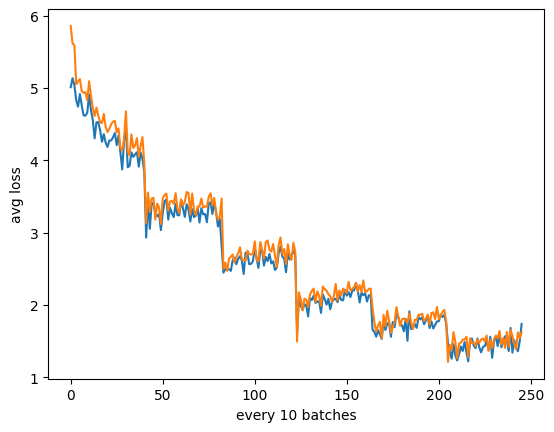

In [ ]:
get_output_by_project('flink',-1,0,None,None,0.2)

INFO:root:Epoch 1, batch 0: 4.774411678314209
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 4.7744
INFO:root:Epoch 1, batch 0/16: 4.774411678314209


time:  0h  0min  1s 679ms, remaining:  0h  8min 32s 542ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 4.7744
Epoch 1, batch 0/16: 4.774411678314209


INFO:root:Epoch 1, batch 1: 5.15783166885376
INFO:root:Epoch 1, batch 2: 5.02978515625
INFO:root:Epoch 1, batch 3: 5.044681549072266
INFO:root:Epoch 1, batch 4: 5.071413993835449
INFO:root:Epoch 1, batch 5: 5.626431465148926
INFO:root:Epoch 1, batch 6: 5.55787467956543
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9945.
INFO:root:Epoch 2, batch 0: 2.967305898666382
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.9673
INFO:root:Epoch 2, batch 0/16: 2.967305898666382


Validate completed, avg loss: 4.9945.

time:  0h  0min  5s 839ms, remaining:  0h  4min  5s 140ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.9673
Epoch 2, batch 0/16: 2.967305898666382


INFO:root:Epoch 2, batch 1: 3.287198781967163
INFO:root:Epoch 2, batch 2: 3.5223820209503174
INFO:root:Epoch 2, batch 3: 3.5671932697296143
INFO:root:Epoch 2, batch 4: 3.653028726577759
INFO:root:Epoch 2, batch 5: 4.455234050750732
INFO:root:Epoch 2, batch 6: 3.8750252723693848
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0261.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.099262237548828
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.0993
INFO:root:Epoch 3, batch 0/16: 2.099262237548828


Validate completed, avg loss: 5.0261.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 10s  61ms, remaining:  0h  3min 42s 496ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.0993
Epoch 3, batch 0/16: 2.099262237548828


INFO:root:Epoch 3, batch 1: 2.5581092834472656
INFO:root:Epoch 3, batch 2: 2.633025884628296
INFO:root:Epoch 3, batch 3: 2.802842140197754
INFO:root:Epoch 3, batch 4: 3.1280956268310547
INFO:root:Epoch 3, batch 5: 3.357573986053467
INFO:root:Epoch 3, batch 6: 2.3863606452941895
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0871.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.7020127773284912
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.7020
INFO:root:Epoch 4, batch 0/16: 1.7020127773284912


Validate completed, avg loss: 5.0871.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 14s 431ms, remaining:  0h  3min 33s 683ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.7020
Epoch 4, batch 0/16: 1.7020127773284912


INFO:root:Epoch 4, batch 1: 1.8769502639770508
INFO:root:Epoch 4, batch 2: 2.0860671997070312
INFO:root:Epoch 4, batch 3: 1.9103286266326904
INFO:root:Epoch 4, batch 4: 2.328690767288208
INFO:root:Epoch 4, batch 5: 2.742603302001953
INFO:root:Epoch 4, batch 6: 1.865640640258789
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1454.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 0.9583921432495117
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 0.9584
INFO:root:Epoch 5, batch 0/16: 0.9583921432495117


Validate completed, avg loss: 5.1454.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 18s 479ms, remaining:  0h  3min 23s 457ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 0.9584
Epoch 5, batch 0/16: 0.9583921432495117


INFO:root:Epoch 5, batch 1: 1.5107380151748657
INFO:root:Epoch 5, batch 2: 1.4844212532043457
INFO:root:Epoch 5, batch 3: 1.385757565498352
INFO:root:Epoch 5, batch 4: 2.230262517929077
INFO:root:Epoch 5, batch 5: 2.402247667312622
INFO:root:Epoch 5, batch 6: 1.3698837757110596
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2270.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.7384753227233887
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7385
INFO:root:Epoch 6, batch 0/16: 0.7384753227233887


Validate completed, avg loss: 5.2270.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 22s 570ms, remaining:  0h  3min 15s 995ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7385
Epoch 6, batch 0/16: 0.7384753227233887


INFO:root:Epoch 6, batch 1: 1.0136446952819824
INFO:root:Epoch 6, batch 2: 0.7676948308944702
INFO:root:Epoch 6, batch 3: 1.0302574634552002
INFO:root:Epoch 6, batch 4: 1.5658762454986572
INFO:root:Epoch 6, batch 5: 1.7522127628326416
INFO:root:Epoch 6, batch 6: 1.0856584310531616
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3017.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.3017.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.405272006988525
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.4053
INFO:root:Epoch 1, batch 0/16: 5.405272006988525
INFO:root:Epoch 1, batch 1: 5.621036052703857


time:  0h  0min  0s 207ms, remaining:  0h  1min  3s 415ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.4053
Epoch 1, batch 0/16: 5.405272006988525


INFO:root:Epoch 1, batch 2: 5.575871467590332
INFO:root:Epoch 1, batch 3: 5.385322093963623
INFO:root:Epoch 1, batch 4: 5.342245578765869
INFO:root:Epoch 1, batch 5: 5.926969528198242
INFO:root:Epoch 1, batch 6: 6.184239387512207
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4432.
INFO:root:Epoch 2, batch 0: 2.9332714080810547
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.9333
INFO:root:Epoch 2, batch 0/16: 2.9332714080810547


Validate completed, avg loss: 5.4432.

time:  0h  0min  4s 290ms, remaining:  0h  3min  0s 105ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.9333
Epoch 2, batch 0/16: 2.9332714080810547


INFO:root:Epoch 2, batch 1: 3.3478124141693115
INFO:root:Epoch 2, batch 2: 3.9632582664489746
INFO:root:Epoch 2, batch 3: 4.2056474685668945
INFO:root:Epoch 2, batch 4: 3.9560348987579346
INFO:root:Epoch 2, batch 5: 4.733399391174316
INFO:root:Epoch 2, batch 6: 3.700892448425293
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4257.
INFO:root:Epoch 3, batch 0: 2.760488986968994
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.7605
INFO:root:Epoch 3, batch 0/16: 2.760488986968994


Validate completed, avg loss: 5.4257.

time:  0h  0min  8s 567ms, remaining:  0h  3min  9s 446ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.7605
Epoch 3, batch 0/16: 2.760488986968994


INFO:root:Epoch 3, batch 1: 2.8521385192871094
INFO:root:Epoch 3, batch 2: 3.1265978813171387
INFO:root:Epoch 3, batch 3: 3.336059808731079
INFO:root:Epoch 3, batch 4: 3.4929611682891846
INFO:root:Epoch 3, batch 5: 3.6426501274108887
INFO:root:Epoch 3, batch 6: 2.35056734085083
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4253.
INFO:root:Epoch 4, batch 0: 1.7029834985733032
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.7030
INFO:root:Epoch 4, batch 0/16: 1.7029834985733032


Validate completed, avg loss: 5.4253.

time:  0h  0min 12s 853ms, remaining:  0h  3min 10s 320ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.7030
Epoch 4, batch 0/16: 1.7029834985733032


INFO:root:Epoch 4, batch 1: 1.8577672243118286
INFO:root:Epoch 4, batch 2: 2.116884708404541
INFO:root:Epoch 4, batch 3: 2.30525541305542
INFO:root:Epoch 4, batch 4: 2.490705728530884
INFO:root:Epoch 4, batch 5: 3.573685646057129
INFO:root:Epoch 4, batch 6: 1.8383291959762573
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4524.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 5, batch 0: 1.214275598526001
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.2143
INFO:root:Epoch 5, batch 0/16: 1.214275598526001


Validate completed, avg loss: 5.4524.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 16s 974ms, remaining:  0h  3min  6s 889ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.2143
Epoch 5, batch 0/16: 1.214275598526001


INFO:root:Epoch 5, batch 1: 1.3025277853012085
INFO:root:Epoch 5, batch 2: 1.6655727624893188
INFO:root:Epoch 5, batch 3: 1.6859126091003418
INFO:root:Epoch 5, batch 4: 1.7230063676834106
INFO:root:Epoch 5, batch 5: 2.6534411907196045
INFO:root:Epoch 5, batch 6: 1.2945849895477295
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5066.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 6, batch 0: 0.728619396686554
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7286
INFO:root:Epoch 6, batch 0/16: 0.728619396686554


Validate completed, avg loss: 5.5066.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 21s 180ms, remaining:  0h  3min  3s 923ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7286
Epoch 6, batch 0/16: 0.728619396686554


INFO:root:Epoch 6, batch 1: 0.8953388333320618
INFO:root:Epoch 6, batch 2: 1.057163953781128
INFO:root:Epoch 6, batch 3: 1.412371039390564
INFO:root:Epoch 6, batch 4: 1.4583454132080078
INFO:root:Epoch 6, batch 5: 1.9118009805679321
INFO:root:Epoch 6, batch 6: 0.9921038746833801
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5820.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 7, batch 0: 0.4560476541519165
INFO:root:epoch: 7/50, batch: 0/3, avg loss: 0.4560
INFO:root:Epoch 7, batch 0/16: 0.4560476541519165


Validate completed, avg loss: 5.5820.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 25s 596ms, remaining:  0h  3min  2s  60ms, epoch:  7/50, batch: 0/3, percent complete:  12.33%, avg loss: 0.4560
Epoch 7, batch 0/16: 0.4560476541519165


INFO:root:Epoch 7, batch 1: 0.6614188551902771
INFO:root:Epoch 7, batch 2: 0.6993966102600098
INFO:root:Epoch 7, batch 3: 1.1155601739883423
INFO:root:Epoch 7, batch 4: 1.035165786743164
INFO:root:Epoch 7, batch 5: 1.6346638202667236
INFO:root:Epoch 7, batch 6: 0.8841733932495117
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6529.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 8, batch 0: 0.29512038826942444
INFO:root:epoch: 8/50, batch: 0/3, avg loss: 0.2951
INFO:root:Epoch 8, batch 0/16: 0.29512038826942444


Validate completed, avg loss: 5.6529.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 29s 778ms, remaining:  0h  2min 58s  75ms, epoch:  8/50, batch: 0/3, percent complete:  14.33%, avg loss: 0.2951
Epoch 8, batch 0/16: 0.29512038826942444


INFO:root:Epoch 8, batch 1: 0.4482676386833191
INFO:root:Epoch 8, batch 2: 0.4557986259460449
INFO:root:Epoch 8, batch 3: 0.7530377507209778
INFO:root:Epoch 8, batch 4: 0.8448647856712341
INFO:root:Epoch 8, batch 5: 1.098551869392395
INFO:root:Epoch 8, batch 6: 0.7041831612586975
INFO:root:Validating the model at the end of epoch 7 on valid dataset.



Validating the model at the end of epoch 7 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6825.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.6825.

EarlyStopping counter: 5 out of 5.

Early stop.

public static boolean isValidRegion(Region region) {
    return Region.regions().contains(region);
}
Reference:  checks whether or not a region is valid
MAML:  checks whether the region region region is the given region
Baseline:  checks if the region of the given region
public void setPosition(long offset, long recordSkipCount) {
    this.offset = offset;
    this.recordSkipCount = recordSkipCount;
}
Reference:  sets the position without setting a record
MAML:  set the position of this record
Baseline:  set the this position of this record
default boolean isMaterializedView(org.apache.hadoop.hive.ql.metadata.Table table) {
    return false;
}
Reference:  checks whether a hive table is a materialized view
MAML:  checks whether this table view is a
Baseline:  checks whether this table for the given jdbc
public String getClassName() {
    return className;
}
Reference:  get class name of the hive func

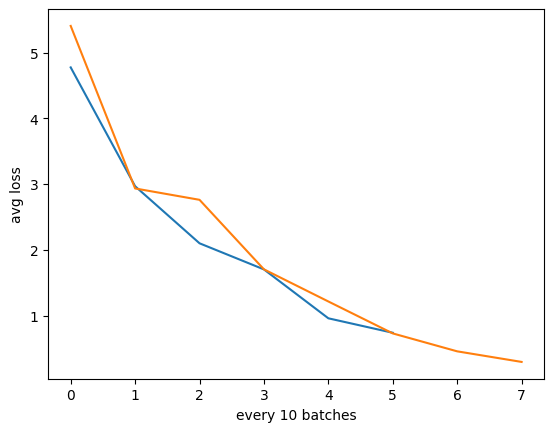

In [ ]:
get_output_by_project('flink',100,0,None,None,0.2)

INFO:root:Epoch 1, batch 0: 5.361057281494141
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.3611
INFO:root:Epoch 1, batch 0/16: 5.361057281494141


time:  0h  0min  1s 729ms, remaining:  0h  8min 48s  40ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.3611
Epoch 1, batch 0/16: 5.361057281494141


INFO:root:Epoch 1, batch 1: 4.847120761871338
INFO:root:Epoch 1, batch 2: 5.510655403137207
INFO:root:Epoch 1, batch 3: 5.712955474853516
INFO:root:Epoch 1, batch 4: 4.977209568023682
INFO:root:Epoch 1, batch 5: 5.231733322143555
INFO:root:Epoch 1, batch 6: 3.2131707668304443
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9680.


Validate completed, avg loss: 4.9680.



INFO:root:Epoch 2, batch 0: 3.335092306137085
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 3.3351
INFO:root:Epoch 2, batch 0/16: 3.335092306137085


time:  0h  0min  5s 935ms, remaining:  0h  4min  9s 168ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 3.3351
Epoch 2, batch 0/16: 3.335092306137085


INFO:root:Epoch 2, batch 1: 3.4669506549835205
INFO:root:Epoch 2, batch 2: 4.122827053070068
INFO:root:Epoch 2, batch 3: 4.173585891723633
INFO:root:Epoch 2, batch 4: 3.499894142150879
INFO:root:Epoch 2, batch 5: 3.6118314266204834
INFO:root:Epoch 2, batch 6: 1.9406017065048218
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0057.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.560243844985962


Validate completed, avg loss: 5.0057.

EarlyStopping counter: 1 out of 5.



INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.5602
INFO:root:Epoch 3, batch 0/16: 2.560243844985962
INFO:root:Epoch 3, batch 1: 2.913001537322998


time:  0h  0min 10s 155ms, remaining:  0h  3min 44s 570ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.5602
Epoch 3, batch 0/16: 2.560243844985962


INFO:root:Epoch 3, batch 2: 3.1945557594299316
INFO:root:Epoch 3, batch 3: 3.3409149646759033
INFO:root:Epoch 3, batch 4: 2.5745413303375244
INFO:root:Epoch 3, batch 5: 3.131333351135254
INFO:root:Epoch 3, batch 6: 1.771508812904358
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0706.
INFO:root:EarlyStopping counter: 2 out of 5.


Validate completed, avg loss: 5.0706.

EarlyStopping counter: 2 out of 5.



INFO:root:Epoch 4, batch 0: 2.00862717628479
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 2.0086
INFO:root:Epoch 4, batch 0/16: 2.00862717628479
INFO:root:Epoch 4, batch 1: 1.9090147018432617


time:  0h  0min 14s 146ms, remaining:  0h  3min 29s 462ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 2.0086
Epoch 4, batch 0/16: 2.00862717628479


INFO:root:Epoch 4, batch 2: 2.4771957397460938
INFO:root:Epoch 4, batch 3: 2.560164451599121
INFO:root:Epoch 4, batch 4: 2.0285565853118896
INFO:root:Epoch 4, batch 5: 2.08074688911438
INFO:root:Epoch 4, batch 6: 0.5013779997825623
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1265.
INFO:root:EarlyStopping counter: 3 out of 5.


Validate completed, avg loss: 5.1265.

EarlyStopping counter: 3 out of 5.



INFO:root:Epoch 5, batch 0: 1.3212610483169556
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.3213
INFO:root:Epoch 5, batch 0/16: 1.3212610483169556


time:  0h  0min 18s 195ms, remaining:  0h  3min 20s 328ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.3213
Epoch 5, batch 0/16: 1.3212610483169556


INFO:root:Epoch 5, batch 1: 1.3485773801803589
INFO:root:Epoch 5, batch 2: 2.547290325164795
INFO:root:Epoch 5, batch 3: 1.8045040369033813
INFO:root:Epoch 5, batch 4: 1.6253530979156494
INFO:root:Epoch 5, batch 5: 1.6713778972625732
INFO:root:Epoch 5, batch 6: 0.1117703765630722
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2022.
INFO:root:EarlyStopping counter: 4 out of 5.


Validate completed, avg loss: 5.2022.

EarlyStopping counter: 4 out of 5.



INFO:root:Epoch 6, batch 0: 1.0837849378585815
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 1.0838
INFO:root:Epoch 6, batch 0/16: 1.0837849378585815
INFO:root:Epoch 6, batch 1: 1.0388787984848022


time:  0h  0min 22s 621ms, remaining:  0h  3min 16s 442ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 1.0838
Epoch 6, batch 0/16: 1.0837849378585815


INFO:root:Epoch 6, batch 2: 1.6109806299209595
INFO:root:Epoch 6, batch 3: 1.2169097661972046
INFO:root:Epoch 6, batch 4: 1.1188783645629883
INFO:root:Epoch 6, batch 5: 1.1043086051940918
INFO:root:Epoch 6, batch 6: 0.0779649093747139
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2729.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.2729.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.956040382385254
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.9560
INFO:root:Epoch 1, batch 0/16: 5.956040382385254
INFO:root:Epoch 1, batch 1: 6.020901679992676


time:  0h  0min  0s 275ms, remaining:  0h  1min 24s  67ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.9560
Epoch 1, batch 0/16: 5.956040382385254


INFO:root:Epoch 1, batch 2: 6.202555179595947
INFO:root:Epoch 1, batch 3: 6.375066757202148
INFO:root:Epoch 1, batch 4: 4.902235507965088
INFO:root:Epoch 1, batch 5: 5.080639839172363
INFO:root:Epoch 1, batch 6: 4.018876075744629
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4107.


Validate completed, avg loss: 5.4107.



INFO:root:Epoch 2, batch 0: 4.433474063873291
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 4.4335
INFO:root:Epoch 2, batch 0/16: 4.433474063873291


time:  0h  0min  4s 500ms, remaining:  0h  3min  8s 935ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 4.4335
Epoch 2, batch 0/16: 4.433474063873291


INFO:root:Epoch 2, batch 1: 4.050969123840332
INFO:root:Epoch 2, batch 2: 4.587975025177002
INFO:root:Epoch 2, batch 3: 4.815738201141357
INFO:root:Epoch 2, batch 4: 3.831742763519287
INFO:root:Epoch 2, batch 5: 3.8952364921569824
INFO:root:Epoch 2, batch 6: 2.1951045989990234
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3666.


Validate completed, avg loss: 5.3666.



INFO:root:Epoch 3, batch 0: 3.1971755027770996
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 3.1972
INFO:root:Epoch 3, batch 0/16: 3.1971755027770996
INFO:root:Epoch 3, batch 1: 3.0536324977874756


time:  0h  0min  8s 834ms, remaining:  0h  3min 15s 361ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 3.1972
Epoch 3, batch 0/16: 3.1971755027770996


INFO:root:Epoch 3, batch 2: 3.334923267364502
INFO:root:Epoch 3, batch 3: 3.7608673572540283
INFO:root:Epoch 3, batch 4: 2.5790529251098633
INFO:root:Epoch 3, batch 5: 3.0672194957733154
INFO:root:Epoch 3, batch 6: 1.8985748291015625
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3790.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.3790.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 4, batch 0: 2.0664761066436768
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 2.0665
INFO:root:Epoch 4, batch 0/16: 2.0664761066436768
INFO:root:Epoch 4, batch 1: 2.444624423980713


time:  0h  0min 12s 887ms, remaining:  0h  3min 10s 820ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 2.0665
Epoch 4, batch 0/16: 2.0664761066436768


INFO:root:Epoch 4, batch 2: 3.0472400188446045
INFO:root:Epoch 4, batch 3: 3.4938228130340576
INFO:root:Epoch 4, batch 4: 2.0133140087127686
INFO:root:Epoch 4, batch 5: 2.076646089553833
INFO:root:Epoch 4, batch 6: 0.5277072787284851
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4172.
INFO:root:EarlyStopping counter: 2 out of 5.


Validate completed, avg loss: 5.4172.

EarlyStopping counter: 2 out of 5.



INFO:root:Epoch 5, batch 0: 1.7881900072097778
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.7882
INFO:root:Epoch 5, batch 0/16: 1.7881900072097778


time:  0h  0min 16s 960ms, remaining:  0h  3min  6s 728ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.7882
Epoch 5, batch 0/16: 1.7881900072097778


INFO:root:Epoch 5, batch 1: 2.037222385406494
INFO:root:Epoch 5, batch 2: 2.3343586921691895
INFO:root:Epoch 5, batch 3: 2.149158000946045
INFO:root:Epoch 5, batch 4: 1.6485867500305176
INFO:root:Epoch 5, batch 5: 1.9452098608016968
INFO:root:Epoch 5, batch 6: 0.2531181275844574
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4603.
INFO:root:EarlyStopping counter: 3 out of 5.


Validate completed, avg loss: 5.4603.

EarlyStopping counter: 3 out of 5.



INFO:root:Epoch 6, batch 0: 1.2001298666000366
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 1.2001
INFO:root:Epoch 6, batch 0/16: 1.2001298666000366
INFO:root:Epoch 6, batch 1: 1.2354910373687744


time:  0h  0min 21s 488ms, remaining:  0h  3min  6s 603ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 1.2001
Epoch 6, batch 0/16: 1.2001298666000366


INFO:root:Epoch 6, batch 2: 1.848810076713562
INFO:root:Epoch 6, batch 3: 1.6983391046524048
INFO:root:Epoch 6, batch 4: 1.3214069604873657
INFO:root:Epoch 6, batch 5: 1.410016655921936
INFO:root:Epoch 6, batch 6: 0.07558267563581467
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5301.
INFO:root:EarlyStopping counter: 4 out of 5.


Validate completed, avg loss: 5.5301.

EarlyStopping counter: 4 out of 5.



INFO:root:Epoch 7, batch 0: 0.8165283203125
INFO:root:epoch: 7/50, batch: 0/3, avg loss: 0.8165
INFO:root:Epoch 7, batch 0/16: 0.8165283203125
INFO:root:Epoch 7, batch 1: 0.9002466201782227


time:  0h  0min 25s 567ms, remaining:  0h  3min  1s 850ms, epoch:  7/50, batch: 0/3, percent complete:  12.33%, avg loss: 0.8165
Epoch 7, batch 0/16: 0.8165283203125


INFO:root:Epoch 7, batch 2: 1.4159928560256958
INFO:root:Epoch 7, batch 3: 1.1927824020385742
INFO:root:Epoch 7, batch 4: 0.7281909584999084
INFO:root:Epoch 7, batch 5: 1.082011342048645
INFO:root:Epoch 7, batch 6: 0.03285694867372513
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5980.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.5980.

EarlyStopping counter: 5 out of 5.

Early stop.

public List<URL> getClasspaths() {
    return this.classpaths;
}
Reference:  returns the classpaths that are required by the program
MAML:  returns the configured list of the files that can be sent with the classpath
Baseline:  list the cached request objects that the view can be null
public List<SplitT> splits() {
    return Collections.unmodifiableList(splits);
}
Reference:  the list of splits
MAML:  gets a list of the order
Baseline:  returns a read only list
public long getLatencyTrackingInterval() {
    return latencyTrackingInterval;
}
Reference:  returns the latency tracking interval
MAML:  returns the interval between milliseconds
Baseline:  returns the interval between elapsed elapsed
public ExecutionMode getExecutionMode() {
    return executionMode;
}
Reference:  gets the execution mode used to execute the program
MAML:  returns the execution mode for the execution
Baseline:  returns the 

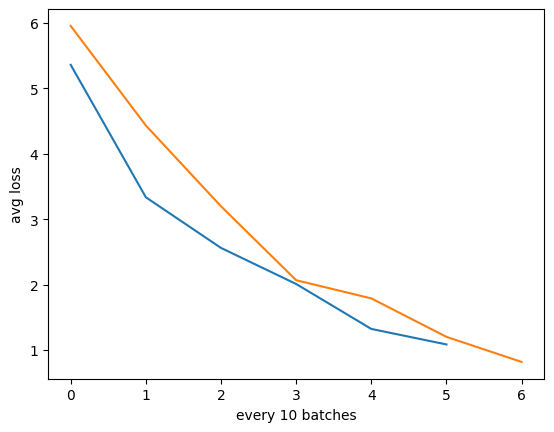

In [7]:
get_output_by_project('flink',100,1,None,None,0.2)

INFO:root:Epoch 1, batch 0: 6.008478164672852
INFO:root:epoch: 1/50, batch: 0/2, avg loss: 6.0085
INFO:root:Epoch 1, batch 0/16: 6.008478164672852
INFO:root:Epoch 1, batch 1: 5.379283428192139


time:  0h  0min  0s 239ms, remaining:  0h  1min 11s 548ms, epoch:  1/50, batch: 0/2, percent complete:   0.33%, avg loss: 6.0085
Epoch 1, batch 0/16: 6.008478164672852


INFO:root:Epoch 1, batch 2: 5.858328342437744
INFO:root:Epoch 1, batch 3: 5.16472864151001
INFO:root:Epoch 1, batch 4: 5.363723278045654
INFO:root:Epoch 1, batch 5: 5.49911642074585
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9554.
INFO:root:Epoch 2, batch 0: 3.9671452045440674
INFO:root:epoch: 2/50, batch: 0/2, avg loss: 3.9671
INFO:root:Epoch 2, batch 0/16: 3.9671452045440674


Validate completed, avg loss: 4.9554.

time:  0h  0min  4s 248ms, remaining:  0h  2min 57s 827ms, epoch:  2/50, batch: 0/2, percent complete:   2.33%, avg loss: 3.9671
Epoch 2, batch 0/16: 3.9671452045440674


INFO:root:Epoch 2, batch 1: 3.8438596725463867
INFO:root:Epoch 2, batch 2: 4.329756259918213
INFO:root:Epoch 2, batch 3: 3.8381001949310303
INFO:root:Epoch 2, batch 4: 4.248444080352783
INFO:root:Epoch 2, batch 5: 3.9167025089263916
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9539.
INFO:root:Epoch 3, batch 0: 3.302107095718384
INFO:root:epoch: 3/50, batch: 0/2, avg loss: 3.3021
INFO:root:Epoch 3, batch 0/16: 3.302107095718384


Validate completed, avg loss: 4.9539.

time:  0h  0min  8s 458ms, remaining:  0h  3min  6s 737ms, epoch:  3/50, batch: 0/2, percent complete:   4.33%, avg loss: 3.3021
Epoch 3, batch 0/16: 3.302107095718384


INFO:root:Epoch 3, batch 1: 2.78322696685791
INFO:root:Epoch 3, batch 2: 3.432833194732666
INFO:root:Epoch 3, batch 3: 2.94303560256958
INFO:root:Epoch 3, batch 4: 3.1763744354248047
INFO:root:Epoch 3, batch 5: 2.92923903465271
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0063.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 4, batch 0: 2.357074499130249
INFO:root:epoch: 4/50, batch: 0/2, avg loss: 2.3571
INFO:root:Epoch 4, batch 0/16: 2.357074499130249


Validate completed, avg loss: 5.0063.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 12s 680ms, remaining:  0h  3min  7s 539ms, epoch:  4/50, batch: 0/2, percent complete:   6.33%, avg loss: 2.3571
Epoch 4, batch 0/16: 2.357074499130249


INFO:root:Epoch 4, batch 1: 2.7252964973449707
INFO:root:Epoch 4, batch 2: 2.560210704803467
INFO:root:Epoch 4, batch 3: 2.1315596103668213
INFO:root:Epoch 4, batch 4: 2.7484424114227295
INFO:root:Epoch 4, batch 5: 2.148765802383423
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0706.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 5, batch 0: 2.0990397930145264
INFO:root:epoch: 5/50, batch: 0/2, avg loss: 2.0990
INFO:root:Epoch 5, batch 0/16: 2.0990397930145264


Validate completed, avg loss: 5.0706.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 16s 736ms, remaining:  0h  3min  4s  96ms, epoch:  5/50, batch: 0/2, percent complete:   8.33%, avg loss: 2.0990
Epoch 5, batch 0/16: 2.0990397930145264


INFO:root:Epoch 5, batch 1: 1.8977365493774414
INFO:root:Epoch 5, batch 2: 2.17910099029541
INFO:root:Epoch 5, batch 3: 1.633018136024475
INFO:root:Epoch 5, batch 4: 1.934638261795044
INFO:root:Epoch 5, batch 5: 1.781922698020935
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1230.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 6, batch 0: 1.4014465808868408
INFO:root:epoch: 6/50, batch: 0/2, avg loss: 1.4014
INFO:root:Epoch 6, batch 0/16: 1.4014465808868408


Validate completed, avg loss: 5.1230.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 20s 860ms, remaining:  0h  3min  1s  13ms, epoch:  6/50, batch: 0/2, percent complete:  10.33%, avg loss: 1.4014
Epoch 6, batch 0/16: 1.4014465808868408


INFO:root:Epoch 6, batch 1: 1.4303983449935913
INFO:root:Epoch 6, batch 2: 1.4690698385238647
INFO:root:Epoch 6, batch 3: 1.206704020500183
INFO:root:Epoch 6, batch 4: 1.429450273513794
INFO:root:Epoch 6, batch 5: 1.1925394535064697
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1966.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 7, batch 0: 1.0844271183013916
INFO:root:epoch: 7/50, batch: 0/2, avg loss: 1.0844
INFO:root:Epoch 7, batch 0/16: 1.0844271183013916


Validate completed, avg loss: 5.1966.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 25s 267ms, remaining:  0h  2min 59s 603ms, epoch:  7/50, batch: 0/2, percent complete:  12.33%, avg loss: 1.0844
Epoch 7, batch 0/16: 1.0844271183013916


INFO:root:Epoch 7, batch 1: 1.1579687595367432
INFO:root:Epoch 7, batch 2: 0.8679684400558472
INFO:root:Epoch 7, batch 3: 0.8164885640144348
INFO:root:Epoch 7, batch 4: 1.091127872467041
INFO:root:Epoch 7, batch 5: 0.8570817112922668
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2768.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.2768.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 6.857350826263428
INFO:root:epoch: 1/50, batch: 0/2, avg loss: 6.8574
INFO:root:Epoch 1, batch 0/16: 6.857350826263428


time:  0h  0min  0s 222ms, remaining:  0h  1min  6s 538ms, epoch:  1/50, batch: 0/2, percent complete:   0.33%, avg loss: 6.8574
Epoch 1, batch 0/16: 6.857350826263428


INFO:root:Epoch 1, batch 1: 6.3665771484375
INFO:root:Epoch 1, batch 2: 5.960885524749756
INFO:root:Epoch 1, batch 3: 5.57997989654541
INFO:root:Epoch 1, batch 4: 6.103766441345215
INFO:root:Epoch 1, batch 5: 5.4745869636535645
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4423.
INFO:root:Epoch 2, batch 0: 4.3303093910217285
INFO:root:epoch: 2/50, batch: 0/2, avg loss: 4.3303
INFO:root:Epoch 2, batch 0/16: 4.3303093910217285


Validate completed, avg loss: 5.4423.

time:  0h  0min  4s 526ms, remaining:  0h  3min  9s 482ms, epoch:  2/50, batch: 0/2, percent complete:   2.33%, avg loss: 4.3303
Epoch 2, batch 0/16: 4.3303093910217285


INFO:root:Epoch 2, batch 1: 4.214756488800049
INFO:root:Epoch 2, batch 2: 4.221898555755615
INFO:root:Epoch 2, batch 3: 4.26091194152832
INFO:root:Epoch 2, batch 4: 4.383491516113281
INFO:root:Epoch 2, batch 5: 4.3525166511535645
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4041.
INFO:root:Epoch 3, batch 0: 3.479046583175659
INFO:root:epoch: 3/50, batch: 0/2, avg loss: 3.4790
INFO:root:Epoch 3, batch 0/16: 3.479046583175659


Validate completed, avg loss: 5.4041.

time:  0h  0min  8s 867ms, remaining:  0h  3min 15s 757ms, epoch:  3/50, batch: 0/2, percent complete:   4.33%, avg loss: 3.4790
Epoch 3, batch 0/16: 3.479046583175659


INFO:root:Epoch 3, batch 1: 3.516932964324951
INFO:root:Epoch 3, batch 2: 3.464020013809204
INFO:root:Epoch 3, batch 3: 3.553682804107666
INFO:root:Epoch 3, batch 4: 3.774893283843994
INFO:root:Epoch 3, batch 5: 3.090726852416992
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3844.
INFO:root:Epoch 4, batch 0: 2.520582914352417
INFO:root:epoch: 4/50, batch: 0/2, avg loss: 2.5206
INFO:root:Epoch 4, batch 0/16: 2.520582914352417


Validate completed, avg loss: 5.3844.

time:  0h  0min 13s   7ms, remaining:  0h  3min 12s 377ms, epoch:  4/50, batch: 0/2, percent complete:   6.33%, avg loss: 2.5206
Epoch 4, batch 0/16: 2.520582914352417


INFO:root:Epoch 4, batch 1: 2.8981993198394775
INFO:root:Epoch 4, batch 2: 3.053229570388794
INFO:root:Epoch 4, batch 3: 2.392033815383911
INFO:root:Epoch 4, batch 4: 2.7596871852874756
INFO:root:Epoch 4, batch 5: 2.345642328262329
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4310.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 5, batch 0: 2.192430019378662
INFO:root:epoch: 5/50, batch: 0/2, avg loss: 2.1924


Validate completed, avg loss: 5.4310.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 17s 310ms, remaining:  0h  3min 10s 411ms, epoch:  5/50, batch: 0/2, percent complete:   8.33%, avg loss: 2.1924


INFO:root:Epoch 5, batch 0/16: 2.192430019378662


Epoch 5, batch 0/16: 2.192430019378662


INFO:root:Epoch 5, batch 1: 2.373669385910034
INFO:root:Epoch 5, batch 2: 1.9827072620391846
INFO:root:Epoch 5, batch 3: 1.7707008123397827
INFO:root:Epoch 5, batch 4: 2.0112810134887695
INFO:root:Epoch 5, batch 5: 1.821618676185608
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4703.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 6, batch 0: 1.4188499450683594
INFO:root:epoch: 6/50, batch: 0/2, avg loss: 1.4188
INFO:root:Epoch 6, batch 0/16: 1.4188499450683594


Validate completed, avg loss: 5.4703.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 21s 738ms, remaining:  0h  3min  8s 636ms, epoch:  6/50, batch: 0/2, percent complete:  10.33%, avg loss: 1.4188
Epoch 6, batch 0/16: 1.4188499450683594


INFO:root:Epoch 6, batch 1: 1.6946748495101929
INFO:root:Epoch 6, batch 2: 1.5247727632522583
INFO:root:Epoch 6, batch 3: 1.3462599515914917
INFO:root:Epoch 6, batch 4: 1.535544753074646
INFO:root:Epoch 6, batch 5: 1.2089060544967651
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5289.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 7, batch 0: 1.0953983068466187
INFO:root:epoch: 7/50, batch: 0/2, avg loss: 1.0954


Validate completed, avg loss: 5.5289.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 25s 954ms, remaining:  0h  3min  4s 487ms, epoch:  7/50, batch: 0/2, percent complete:  12.33%, avg loss: 1.0954
Epoch 7, batch 0/16: 1.0953983068466187


INFO:root:Epoch 7, batch 0/16: 1.0953983068466187
INFO:root:Epoch 7, batch 1: 1.5814597606658936
INFO:root:Epoch 7, batch 2: 0.991004228591919
INFO:root:Epoch 7, batch 3: 1.0827727317810059
INFO:root:Epoch 7, batch 4: 1.1556979417800903
INFO:root:Epoch 7, batch 5: 0.8918326497077942
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5825.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 8, batch 0: 0.8457001447677612
INFO:root:epoch: 8/50, batch: 0/2, avg loss: 0.8457
INFO:root:Epoch 8, batch 0/16: 0.8457001447677612


Validate completed, avg loss: 5.5825.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 30s 212ms, remaining:  0h  3min  0s 570ms, epoch:  8/50, batch: 0/2, percent complete:  14.33%, avg loss: 0.8457
Epoch 8, batch 0/16: 0.8457001447677612


INFO:root:Epoch 8, batch 1: 0.9793132543563843
INFO:root:Epoch 8, batch 2: 0.6646191477775574
INFO:root:Epoch 8, batch 3: 0.7163548469543457
INFO:root:Epoch 8, batch 4: 0.9445101022720337
INFO:root:Epoch 8, batch 5: 0.6166291236877441
INFO:root:Validating the model at the end of epoch 7 on valid dataset.



Validating the model at the end of epoch 7 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6382.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.6382.

EarlyStopping counter: 5 out of 5.

Early stop.

public static Region getRegion(final Properties configProps) {
    return Region.of(configProps.getProperty(AWSConfigConstants.AWS_REGION));
}
Reference:  creates a region object from the given properties
MAML:  returns the region region from the given properties
Baseline:  returns the domain object for the given configuration instance
public void setName(String name) {
    this.name = name;
}
Reference:  sets the name of the contract instance
MAML:  sets the name of the name
Baseline:  set the name of the trigger
public ResourceSpec getPreferredResources() {
    return this.preferredResources;
}
Reference:  gets the preferred resources for this contract instance
MAML:  returns the preferred resources for this view
Baseline:  get the preferred preferred that should be restarted
public void putCharLittleEndian(int index, char value) {
    if (LITTLE_ENDIAN) {
        putChar(index, value);
    } else

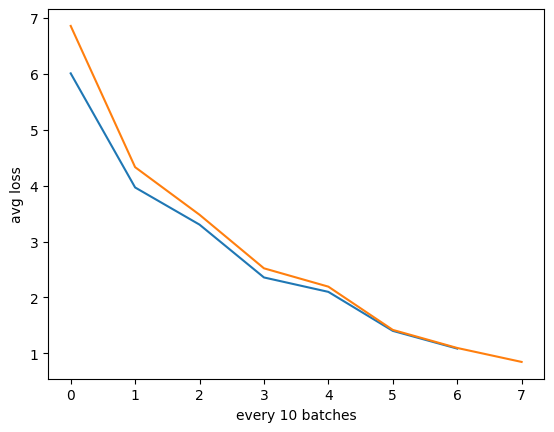

In [9]:
get_output_by_project('flink',100,2,None,None,0.3)

INFO:root:Epoch 1, batch 0: 4.716925621032715
INFO:root:epoch: 1/50, batch: 0/201, avg loss: 4.7169
INFO:root:Epoch 1, batch 0/16: 4.716925621032715


time:  0h  0min  0s 161ms, remaining:  0h 54min  8s 147ms, epoch:  1/50, batch:   0/201, percent complete:   0.00%, avg loss: 4.7169
Epoch 1, batch 0/16: 4.716925621032715


INFO:root:Epoch 1, batch 1: 4.956106662750244
INFO:root:Epoch 1, batch 2: 5.144162654876709
INFO:root:Epoch 1, batch 3: 4.200878143310547
INFO:root:Epoch 1, batch 4: 5.095365047454834
INFO:root:Epoch 1, batch 5: 5.223228931427002
INFO:root:Epoch 1, batch 6: 5.0888590812683105
INFO:root:Epoch 1, batch 7: 4.838907718658447
INFO:root:Epoch 1, batch 8: 5.494629383087158
INFO:root:Epoch 1, batch 9: 5.163382053375244
INFO:root:Epoch 1, batch 10: 4.451704025268555
INFO:root:Epoch 1, batch 11: 4.763843536376953
INFO:root:Epoch 1, batch 12: 3.9843523502349854
INFO:root:Epoch 1, batch 13: 5.402388572692871
INFO:root:Epoch 1, batch 14: 5.0323309898376465
INFO:root:Epoch 1, batch 15: 5.028974533081055
INFO:root:Epoch 1, batch 16: 4.666356563568115
INFO:root:Epoch 1, batch 17: 5.942560195922852
INFO:root:Epoch 1, batch 18: 4.742915630340576
INFO:root:Epoch 1, batch 19: 4.447584629058838
INFO:root:Epoch 1, batch 20: 4.985927104949951
INFO:root:Epoch 1, batch 21: 4.925223350524902
INFO:root:Epoch 1, 

time:  0h  0min 38s 365ms, remaining:  0h 31min 25s 294ms, epoch:  1/50, batch: 200/201, percent complete:   1.99%, avg loss: 4.5995
Epoch 1, batch 200/16: 919.9052731990814


INFO:root:Epoch 1, batch 201: 4.386663913726807
INFO:root:Epoch 1, batch 202: 3.5958449840545654
INFO:root:Epoch 1, batch 203: 4.320910453796387
INFO:root:Epoch 1, batch 204: 3.781693458557129
INFO:root:Epoch 1, batch 205: 4.578829288482666
INFO:root:Epoch 1, batch 206: 4.558290481567383
INFO:root:Epoch 1, batch 207: 4.201778888702393
INFO:root:Epoch 1, batch 208: 4.542515277862549
INFO:root:Epoch 1, batch 209: 4.685460567474365
INFO:root:Epoch 1, batch 210: 4.0438551902771
INFO:root:Epoch 1, batch 211: 4.61818265914917
INFO:root:Epoch 1, batch 212: 5.017188549041748
INFO:root:Epoch 1, batch 213: 3.8915047645568848
INFO:root:Epoch 1, batch 214: 4.114758014678955
INFO:root:Epoch 1, batch 215: 4.620645523071289
INFO:root:Epoch 1, batch 216: 4.404217720031738
INFO:root:Epoch 1, batch 217: 4.341578006744385
INFO:root:Epoch 1, batch 218: 4.684569835662842
INFO:root:Epoch 1, batch 219: 4.3845014572143555
INFO:root:Epoch 1, batch 220: 4.014829635620117
INFO:root:Epoch 1, batch 221: 4.07876014

time:  0h  1min 15s 781ms, remaining:  0h 30min 26s 431ms, epoch:  1/50, batch: 400/201, percent complete:   3.98%, avg loss: 4.1679
Epoch 1, batch 400/16: 833.5701568126678


INFO:root:Epoch 1, batch 402: 2.7142434120178223
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0540.


Validate completed, avg loss: 5.0540.



INFO:root:Epoch 2, batch 0: 3.912372350692749
INFO:root:epoch: 2/50, batch: 0/201, avg loss: 3.9124
INFO:root:Epoch 2, batch 0/16: 3.912372350692749


time:  0h  1min 19s 371ms, remaining:  1h  4min 39s 367ms, epoch:  2/50, batch:   0/201, percent complete:   2.00%, avg loss: 3.9124
Epoch 2, batch 0/16: 3.912372350692749


INFO:root:Epoch 2, batch 1: 3.298619270324707
INFO:root:Epoch 2, batch 2: 3.154620885848999
INFO:root:Epoch 2, batch 3: 3.5562732219696045
INFO:root:Epoch 2, batch 4: 3.3559958934783936
INFO:root:Epoch 2, batch 5: 2.7940542697906494
INFO:root:Epoch 2, batch 6: 3.6624462604522705
INFO:root:Epoch 2, batch 7: 3.005640745162964
INFO:root:Epoch 2, batch 8: 3.1003942489624023
INFO:root:Epoch 2, batch 9: 3.63057017326355
INFO:root:Epoch 2, batch 10: 3.557201623916626
INFO:root:Epoch 2, batch 11: 3.1349005699157715
INFO:root:Epoch 2, batch 12: 3.5040740966796875
INFO:root:Epoch 2, batch 13: 3.619062662124634
INFO:root:Epoch 2, batch 14: 2.5916521549224854
INFO:root:Epoch 2, batch 15: 3.7204768657684326
INFO:root:Epoch 2, batch 16: 3.05741024017334
INFO:root:Epoch 2, batch 17: 4.080597877502441
INFO:root:Epoch 2, batch 18: 2.7657458782196045
INFO:root:Epoch 2, batch 19: 2.441883087158203
INFO:root:Epoch 2, batch 20: 3.6210029125213623
INFO:root:Epoch 2, batch 21: 3.3538413047790527
INFO:root:Ep

time:  0h  1min 57s 428ms, remaining:  0h 47min  2s 399ms, epoch:  2/50, batch: 200/201, percent complete:   3.99%, avg loss: 3.2720
Epoch 2, batch 200/16: 654.39111495018


INFO:root:Epoch 2, batch 202: 4.004434108734131
INFO:root:Epoch 2, batch 203: 2.637838125228882
INFO:root:Epoch 2, batch 204: 3.5445873737335205
INFO:root:Epoch 2, batch 205: 2.707007646560669
INFO:root:Epoch 2, batch 206: 2.971269369125366
INFO:root:Epoch 2, batch 207: 3.8110570907592773
INFO:root:Epoch 2, batch 208: 3.1149635314941406
INFO:root:Epoch 2, batch 209: 2.741002082824707
INFO:root:Epoch 2, batch 210: 3.137017250061035
INFO:root:Epoch 2, batch 211: 2.640686511993408
INFO:root:Epoch 2, batch 212: 2.860339641571045
INFO:root:Epoch 2, batch 213: 3.4481823444366455
INFO:root:Epoch 2, batch 214: 2.786557197570801
INFO:root:Epoch 2, batch 215: 3.0823895931243896
INFO:root:Epoch 2, batch 216: 3.2261815071105957
INFO:root:Epoch 2, batch 217: 3.3076071739196777
INFO:root:Epoch 2, batch 218: 2.6391561031341553
INFO:root:Epoch 2, batch 219: 3.320225954055786
INFO:root:Epoch 2, batch 220: 3.8372459411621094
INFO:root:Epoch 2, batch 221: 3.324857234954834
INFO:root:Epoch 2, batch 222: 3

time:  0h  2min 35s  46ms, remaining:  0h 40min 36s  40ms, epoch:  2/50, batch: 400/201, percent complete:   5.98%, avg loss: 3.2679
Epoch 2, batch 400/16: 653.5892593860626


INFO:root:Epoch 2, batch 402: 2.613837718963623
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3194.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 1.7720218896865845
INFO:root:epoch: 3/50, batch: 0/201, avg loss: 1.7720
INFO:root:Epoch 3, batch 0/16: 1.7720218896865845


Validate completed, avg loss: 5.3194.

EarlyStopping counter: 1 out of 5.

time:  0h  2min 38s 515ms, remaining:  1h  3min 19s 454ms, epoch:  3/50, batch:   0/201, percent complete:   4.00%, avg loss: 1.7720
Epoch 3, batch 0/16: 1.7720218896865845


INFO:root:Epoch 3, batch 1: 2.9438185691833496
INFO:root:Epoch 3, batch 2: 2.732423782348633
INFO:root:Epoch 3, batch 3: 2.5770580768585205
INFO:root:Epoch 3, batch 4: 2.281489133834839
INFO:root:Epoch 3, batch 5: 2.1468002796173096
INFO:root:Epoch 3, batch 6: 2.3951427936553955
INFO:root:Epoch 3, batch 7: 2.3982889652252197
INFO:root:Epoch 3, batch 8: 2.204754114151001
INFO:root:Epoch 3, batch 9: 2.6380374431610107
INFO:root:Epoch 3, batch 10: 2.2520089149475098
INFO:root:Epoch 3, batch 11: 2.337174654006958
INFO:root:Epoch 3, batch 12: 2.3405487537384033
INFO:root:Epoch 3, batch 13: 2.3525326251983643
INFO:root:Epoch 3, batch 14: 2.696485757827759
INFO:root:Epoch 3, batch 15: 2.961333990097046
INFO:root:Epoch 3, batch 16: 2.781564950942993
INFO:root:Epoch 3, batch 17: 2.4069392681121826
INFO:root:Epoch 3, batch 18: 3.124178171157837
INFO:root:Epoch 3, batch 19: 2.4273955821990967
INFO:root:Epoch 3, batch 20: 2.2665951251983643
INFO:root:Epoch 3, batch 21: 2.5492618083953857
INFO:root

time:  0h  3min 15s 876ms, remaining:  0h 51min 11s 786ms, epoch:  3/50, batch: 200/201, percent complete:   5.99%, avg loss: 2.5823
Epoch 3, batch 200/16: 516.4696016311646


INFO:root:Epoch 3, batch 201: 1.8104130029678345
INFO:root:Epoch 3, batch 202: 2.4662835597991943
INFO:root:Epoch 3, batch 203: 2.7796261310577393
INFO:root:Epoch 3, batch 204: 2.8379180431365967
INFO:root:Epoch 3, batch 205: 2.6917221546173096
INFO:root:Epoch 3, batch 206: 3.0202291011810303
INFO:root:Epoch 3, batch 207: 2.4247148036956787
INFO:root:Epoch 3, batch 208: 2.429041862487793
INFO:root:Epoch 3, batch 209: 2.9330360889434814
INFO:root:Epoch 3, batch 210: 2.877863645553589
INFO:root:Epoch 3, batch 211: 2.961193799972534
INFO:root:Epoch 3, batch 212: 2.8463973999023438
INFO:root:Epoch 3, batch 213: 2.3601343631744385
INFO:root:Epoch 3, batch 214: 2.4817044734954834
INFO:root:Epoch 3, batch 215: 2.6915411949157715
INFO:root:Epoch 3, batch 216: 2.9526138305664062
INFO:root:Epoch 3, batch 217: 3.2004475593566895
INFO:root:Epoch 3, batch 218: 2.336249828338623
INFO:root:Epoch 3, batch 219: 2.4782156944274902
INFO:root:Epoch 3, batch 220: 2.857055187225342
INFO:root:Epoch 3, batch 

time:  0h  3min 54s 282ms, remaining:  0h 45min  0s 174ms, epoch:  3/50, batch: 400/201, percent complete:   7.98%, avg loss: 2.6751
Epoch 3, batch 400/16: 535.0189669132233


INFO:root:Epoch 3, batch 402: 2.9487884044647217
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4540.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 2.130960464477539
INFO:root:epoch: 4/50, batch: 0/201, avg loss: 2.1310
INFO:root:Epoch 4, batch 0/16: 2.130960464477539


Validate completed, avg loss: 5.4540.

EarlyStopping counter: 2 out of 5.

time:  0h  3min 57s 857ms, remaining:  1h  2min  3s 158ms, epoch:  4/50, batch:   0/201, percent complete:   6.00%, avg loss: 2.1310
Epoch 4, batch 0/16: 2.130960464477539


INFO:root:Epoch 4, batch 1: 1.5087802410125732
INFO:root:Epoch 4, batch 2: 1.7587333917617798
INFO:root:Epoch 4, batch 3: 1.5179662704467773
INFO:root:Epoch 4, batch 4: 2.403865337371826
INFO:root:Epoch 4, batch 5: 2.1506776809692383
INFO:root:Epoch 4, batch 6: 1.9011439085006714
INFO:root:Epoch 4, batch 7: 2.0929014682769775
INFO:root:Epoch 4, batch 8: 2.033513307571411
INFO:root:Epoch 4, batch 9: 1.8952819108963013
INFO:root:Epoch 4, batch 10: 2.295919895172119
INFO:root:Epoch 4, batch 11: 2.1698431968688965
INFO:root:Epoch 4, batch 12: 1.8218814134597778
INFO:root:Epoch 4, batch 13: 1.7701972723007202
INFO:root:Epoch 4, batch 14: 2.495668411254883
INFO:root:Epoch 4, batch 15: 1.959596872329712
INFO:root:Epoch 4, batch 16: 2.009833574295044
INFO:root:Epoch 4, batch 17: 1.773917555809021
INFO:root:Epoch 4, batch 18: 1.7699941396713257
INFO:root:Epoch 4, batch 19: 2.4524097442626953
INFO:root:Epoch 4, batch 20: 2.077643632888794
INFO:root:Epoch 4, batch 21: 2.0597951412200928
INFO:root

time:  0h  4min 35s 493ms, remaining:  0h 52min 50s 580ms, epoch:  4/50, batch: 200/201, percent complete:   7.99%, avg loss: 2.0928
Epoch 4, batch 200/16: 418.55355489254


INFO:root:Epoch 4, batch 202: 1.8957699537277222
INFO:root:Epoch 4, batch 203: 2.217350959777832
INFO:root:Epoch 4, batch 204: 1.9527286291122437
INFO:root:Epoch 4, batch 205: 2.3675131797790527
INFO:root:Epoch 4, batch 206: 2.2363758087158203
INFO:root:Epoch 4, batch 207: 2.194823741912842
INFO:root:Epoch 4, batch 208: 1.9350523948669434
INFO:root:Epoch 4, batch 209: 2.445819854736328
INFO:root:Epoch 4, batch 210: 2.1975009441375732
INFO:root:Epoch 4, batch 211: 1.5538538694381714
INFO:root:Epoch 4, batch 212: 1.8397947549819946
INFO:root:Epoch 4, batch 213: 2.0297510623931885
INFO:root:Epoch 4, batch 214: 2.451148748397827
INFO:root:Epoch 4, batch 215: 2.3379878997802734
INFO:root:Epoch 4, batch 216: 2.7011682987213135
INFO:root:Epoch 4, batch 217: 2.1822140216827393
INFO:root:Epoch 4, batch 218: 2.853374719619751
INFO:root:Epoch 4, batch 219: 2.101729154586792
INFO:root:Epoch 4, batch 220: 1.5776580572128296
INFO:root:Epoch 4, batch 221: 1.7661432027816772
INFO:root:Epoch 4, batch 2

time:  0h  5min 13s 371ms, remaining:  0h 47min  5s 419ms, epoch:  4/50, batch: 400/201, percent complete:   9.98%, avg loss: 2.1323
Epoch 4, batch 400/16: 426.46697330474854


INFO:root:Epoch 4, batch 402: 2.6898303031921387
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7487.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 2.205071210861206
INFO:root:epoch: 5/50, batch: 0/201, avg loss: 2.2051
INFO:root:Epoch 5, batch 0/16: 2.205071210861206


Validate completed, avg loss: 5.7487.

EarlyStopping counter: 3 out of 5.

time:  0h  5min 16s 938ms, remaining:  1h  0min 42s 327ms, epoch:  5/50, batch:   0/201, percent complete:   8.00%, avg loss: 2.2051
Epoch 5, batch 0/16: 2.205071210861206


INFO:root:Epoch 5, batch 1: 1.2557495832443237
INFO:root:Epoch 5, batch 2: 1.688658595085144
INFO:root:Epoch 5, batch 3: 1.5029938220977783
INFO:root:Epoch 5, batch 4: 1.5374705791473389
INFO:root:Epoch 5, batch 5: 1.6452091932296753
INFO:root:Epoch 5, batch 6: 1.812540888786316
INFO:root:Epoch 5, batch 7: 1.5109326839447021
INFO:root:Epoch 5, batch 8: 1.5899090766906738
INFO:root:Epoch 5, batch 9: 1.4414644241333008
INFO:root:Epoch 5, batch 10: 1.7121864557266235
INFO:root:Epoch 5, batch 11: 1.7564934492111206
INFO:root:Epoch 5, batch 12: 1.2925236225128174
INFO:root:Epoch 5, batch 13: 2.0968639850616455
INFO:root:Epoch 5, batch 14: 2.2181904315948486
INFO:root:Epoch 5, batch 15: 1.5993882417678833
INFO:root:Epoch 5, batch 16: 1.7183361053466797
INFO:root:Epoch 5, batch 17: 1.7975109815597534
INFO:root:Epoch 5, batch 18: 1.477073073387146
INFO:root:Epoch 5, batch 19: 1.7904052734375
INFO:root:Epoch 5, batch 20: 1.668785572052002
INFO:root:Epoch 5, batch 21: 1.3891199827194214
INFO:roo

time:  0h  5min 54s 788ms, remaining:  0h 53min 15s  85ms, epoch:  5/50, batch: 200/201, percent complete:   9.99%, avg loss: 1.6579
Epoch 5, batch 200/16: 331.58388006687164


INFO:root:Epoch 5, batch 202: 1.8072316646575928
INFO:root:Epoch 5, batch 203: 2.0797154903411865
INFO:root:Epoch 5, batch 204: 1.5951029062271118
INFO:root:Epoch 5, batch 205: 1.1518123149871826
INFO:root:Epoch 5, batch 206: 1.2995595932006836
INFO:root:Epoch 5, batch 207: 2.1412510871887207
INFO:root:Epoch 5, batch 208: 1.8107601404190063
INFO:root:Epoch 5, batch 209: 1.2421973943710327
INFO:root:Epoch 5, batch 210: 1.8774008750915527
INFO:root:Epoch 5, batch 211: 1.9102457761764526
INFO:root:Epoch 5, batch 212: 2.020925283432007
INFO:root:Epoch 5, batch 213: 2.248450994491577
INFO:root:Epoch 5, batch 214: 2.338306188583374
INFO:root:Epoch 5, batch 215: 1.679449439048767
INFO:root:Epoch 5, batch 216: 1.4002060890197754
INFO:root:Epoch 5, batch 217: 1.6617004871368408
INFO:root:Epoch 5, batch 218: 1.849130630493164
INFO:root:Epoch 5, batch 219: 1.9255633354187012
INFO:root:Epoch 5, batch 220: 1.6737662553787231
INFO:root:Epoch 5, batch 221: 2.049821615219116
INFO:root:Epoch 5, batch 2

time:  0h  6min 32s 392ms, remaining:  0h 48min  1s 956ms, epoch:  5/50, batch: 400/201, percent complete:  11.98%, avg loss: 1.7759
Epoch 5, batch 400/16: 355.1846263408661


INFO:root:Epoch 5, batch 402: 2.3191730976104736
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.9315.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 1.012942910194397
INFO:root:epoch: 6/50, batch: 0/201, avg loss: 1.0129
INFO:root:Epoch 6, batch 0/16: 1.012942910194397


Validate completed, avg loss: 5.9315.

EarlyStopping counter: 4 out of 5.

time:  0h  6min 36s 200ms, remaining:  0h 59min 23s 836ms, epoch:  6/50, batch:   0/201, percent complete:  10.00%, avg loss: 1.0129
Epoch 6, batch 0/16: 1.012942910194397


INFO:root:Epoch 6, batch 1: 1.0439000129699707
INFO:root:Epoch 6, batch 2: 1.5506349802017212
INFO:root:Epoch 6, batch 3: 1.4923436641693115
INFO:root:Epoch 6, batch 4: 1.1290690898895264
INFO:root:Epoch 6, batch 5: 1.618653655052185
INFO:root:Epoch 6, batch 6: 1.480700969696045
INFO:root:Epoch 6, batch 7: 1.5679329633712769
INFO:root:Epoch 6, batch 8: 1.383612871170044
INFO:root:Epoch 6, batch 9: 1.7399235963821411
INFO:root:Epoch 6, batch 10: 1.4834622144699097
INFO:root:Epoch 6, batch 11: 1.4303475618362427
INFO:root:Epoch 6, batch 12: 1.5206855535507202
INFO:root:Epoch 6, batch 13: 1.1634984016418457
INFO:root:Epoch 6, batch 14: 1.6437511444091797
INFO:root:Epoch 6, batch 15: 1.952909231185913
INFO:root:Epoch 6, batch 16: 1.5182782411575317
INFO:root:Epoch 6, batch 17: 1.6131175756454468
INFO:root:Epoch 6, batch 18: 1.2289941310882568
INFO:root:Epoch 6, batch 19: 1.440347671508789
INFO:root:Epoch 6, batch 20: 1.4020222425460815
INFO:root:Epoch 6, batch 21: 1.0183639526367188
INFO:r

time:  0h  7min 13s 968ms, remaining:  0h 53min  4s 123ms, epoch:  6/50, batch: 200/201, percent complete:  11.99%, avg loss: 1.3651
Epoch 6, batch 200/16: 273.01271933317184


INFO:root:Epoch 6, batch 201: 1.4669206142425537
INFO:root:Epoch 6, batch 202: 1.537472128868103
INFO:root:Epoch 6, batch 203: 1.7863401174545288
INFO:root:Epoch 6, batch 204: 1.5536198616027832
INFO:root:Epoch 6, batch 205: 1.116269588470459
INFO:root:Epoch 6, batch 206: 2.4405345916748047
INFO:root:Epoch 6, batch 207: 1.5425951480865479
INFO:root:Epoch 6, batch 208: 1.4845385551452637
INFO:root:Epoch 6, batch 209: 1.5722850561141968
INFO:root:Epoch 6, batch 210: 1.2213584184646606
INFO:root:Epoch 6, batch 211: 1.52744722366333
INFO:root:Epoch 6, batch 212: 1.2848469018936157
INFO:root:Epoch 6, batch 213: 1.3698662519454956
INFO:root:Epoch 6, batch 214: 1.9856234788894653
INFO:root:Epoch 6, batch 215: 1.8550662994384766
INFO:root:Epoch 6, batch 216: 1.0633556842803955
INFO:root:Epoch 6, batch 217: 1.4610170125961304
INFO:root:Epoch 6, batch 218: 1.3028655052185059
INFO:root:Epoch 6, batch 219: 1.3594962358474731
INFO:root:Epoch 6, batch 220: 1.354169487953186
INFO:root:Epoch 6, batch 

time:  0h  7min 51s 848ms, remaining:  0h 48min 22s 396ms, epoch:  6/50, batch: 400/201, percent complete:  13.98%, avg loss: 1.4891
Epoch 6, batch 400/16: 297.81244814395905


INFO:root:Epoch 6, batch 402: 2.54620099067688
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.2096.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.2096.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.275921821594238
INFO:root:epoch: 1/50, batch: 0/201, avg loss: 5.2759
INFO:root:Epoch 1, batch 0/16: 5.275921821594238


time:  0h  0min  0s 149ms, remaining:  0h 50min  5s 330ms, epoch:  1/50, batch:   0/201, percent complete:   0.00%, avg loss: 5.2759
Epoch 1, batch 0/16: 5.275921821594238


INFO:root:Epoch 1, batch 1: 5.252424240112305
INFO:root:Epoch 1, batch 2: 5.866707801818848
INFO:root:Epoch 1, batch 3: 4.830344200134277
INFO:root:Epoch 1, batch 4: 5.841604709625244
INFO:root:Epoch 1, batch 5: 5.5042405128479
INFO:root:Epoch 1, batch 6: 5.6822638511657715
INFO:root:Epoch 1, batch 7: 5.278002738952637
INFO:root:Epoch 1, batch 8: 6.230076313018799
INFO:root:Epoch 1, batch 9: 5.992272853851318
INFO:root:Epoch 1, batch 10: 4.863951683044434
INFO:root:Epoch 1, batch 11: 5.636646747589111
INFO:root:Epoch 1, batch 12: 4.255199909210205
INFO:root:Epoch 1, batch 13: 5.828678131103516
INFO:root:Epoch 1, batch 14: 5.447906970977783
INFO:root:Epoch 1, batch 15: 4.868382930755615
INFO:root:Epoch 1, batch 16: 5.08016300201416
INFO:root:Epoch 1, batch 17: 6.441266059875488
INFO:root:Epoch 1, batch 18: 5.303661823272705
INFO:root:Epoch 1, batch 19: 5.148568630218506
INFO:root:Epoch 1, batch 20: 5.3136467933654785
INFO:root:Epoch 1, batch 21: 5.792562961578369
INFO:root:Epoch 1, batc

time:  0h  0min 38s 368ms, remaining:  0h 31min 25s 432ms, epoch:  1/50, batch: 200/201, percent complete:   1.99%, avg loss: 4.8498
Epoch 1, batch 200/16: 969.967453956604


INFO:root:Epoch 1, batch 201: 4.823136806488037
INFO:root:Epoch 1, batch 202: 4.059169292449951
INFO:root:Epoch 1, batch 203: 4.499558448791504
INFO:root:Epoch 1, batch 204: 4.153639316558838
INFO:root:Epoch 1, batch 205: 4.606633186340332
INFO:root:Epoch 1, batch 206: 4.66664981842041
INFO:root:Epoch 1, batch 207: 4.389942169189453
INFO:root:Epoch 1, batch 208: 4.828049659729004
INFO:root:Epoch 1, batch 209: 4.886642932891846
INFO:root:Epoch 1, batch 210: 4.138365745544434
INFO:root:Epoch 1, batch 211: 4.756104946136475
INFO:root:Epoch 1, batch 212: 5.028839111328125
INFO:root:Epoch 1, batch 213: 4.042817115783691
INFO:root:Epoch 1, batch 214: 4.272768020629883
INFO:root:Epoch 1, batch 215: 4.626712799072266
INFO:root:Epoch 1, batch 216: 4.314819812774658
INFO:root:Epoch 1, batch 217: 4.539196014404297
INFO:root:Epoch 1, batch 218: 4.850368499755859
INFO:root:Epoch 1, batch 219: 4.364970684051514
INFO:root:Epoch 1, batch 220: 4.309152126312256
INFO:root:Epoch 1, batch 221: 4.533241748

time:  0h  1min 15s 837ms, remaining:  0h 30min 27s 789ms, epoch:  1/50, batch: 400/201, percent complete:   3.98%, avg loss: 4.2966
Epoch 1, batch 400/16: 859.3252372741699


INFO:root:Epoch 1, batch 402: 2.833444118499756
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1182.


Validate completed, avg loss: 5.1182.



INFO:root:Epoch 2, batch 0: 4.1717119216918945
INFO:root:epoch: 2/50, batch: 0/201, avg loss: 4.1717
INFO:root:Epoch 2, batch 0/16: 4.1717119216918945


time:  0h  1min 19s 601ms, remaining:  1h  4min 50s 607ms, epoch:  2/50, batch:   0/201, percent complete:   2.00%, avg loss: 4.1717
Epoch 2, batch 0/16: 4.1717119216918945


INFO:root:Epoch 2, batch 1: 3.492645740509033
INFO:root:Epoch 2, batch 2: 2.96234393119812
INFO:root:Epoch 2, batch 3: 3.3632164001464844
INFO:root:Epoch 2, batch 4: 3.029132604598999
INFO:root:Epoch 2, batch 5: 3.0402352809906006
INFO:root:Epoch 2, batch 6: 3.8646297454833984
INFO:root:Epoch 2, batch 7: 3.037635087966919
INFO:root:Epoch 2, batch 8: 2.88223934173584
INFO:root:Epoch 2, batch 9: 3.6758103370666504
INFO:root:Epoch 2, batch 10: 3.4607033729553223
INFO:root:Epoch 2, batch 11: 3.5945565700531006
INFO:root:Epoch 2, batch 12: 3.652707815170288
INFO:root:Epoch 2, batch 13: 3.58202862739563
INFO:root:Epoch 2, batch 14: 2.81272292137146
INFO:root:Epoch 2, batch 15: 4.004127502441406
INFO:root:Epoch 2, batch 16: 3.0714213848114014
INFO:root:Epoch 2, batch 17: 3.8907630443573
INFO:root:Epoch 2, batch 18: 2.7232542037963867
INFO:root:Epoch 2, batch 19: 2.6022419929504395
INFO:root:Epoch 2, batch 20: 3.5050241947174072
INFO:root:Epoch 2, batch 21: 3.4887731075286865
INFO:root:Epoch 2

time:  0h  1min 57s 826ms, remaining:  0h 47min 11s 966ms, epoch:  2/50, batch: 200/201, percent complete:   3.99%, avg loss: 3.4268
Epoch 2, batch 200/16: 685.3643960952759


INFO:root:Epoch 2, batch 201: 2.7146551609039307
INFO:root:Epoch 2, batch 202: 4.11227560043335
INFO:root:Epoch 2, batch 203: 3.230978012084961
INFO:root:Epoch 2, batch 204: 4.275722503662109
INFO:root:Epoch 2, batch 205: 3.060535192489624
INFO:root:Epoch 2, batch 206: 3.7867116928100586
INFO:root:Epoch 2, batch 207: 3.900333881378174
INFO:root:Epoch 2, batch 208: 3.0903642177581787
INFO:root:Epoch 2, batch 209: 3.017347812652588
INFO:root:Epoch 2, batch 210: 3.6654465198516846
INFO:root:Epoch 2, batch 211: 3.0497639179229736
INFO:root:Epoch 2, batch 212: 2.9680700302124023
INFO:root:Epoch 2, batch 213: 3.5192508697509766
INFO:root:Epoch 2, batch 214: 3.0135395526885986
INFO:root:Epoch 2, batch 215: 3.1539435386657715
INFO:root:Epoch 2, batch 216: 3.1895787715911865
INFO:root:Epoch 2, batch 217: 3.5225653648376465
INFO:root:Epoch 2, batch 218: 3.0019052028656006
INFO:root:Epoch 2, batch 219: 3.5699310302734375
INFO:root:Epoch 2, batch 220: 3.4896492958068848
INFO:root:Epoch 2, batch 22

time:  0h  2min 35s 673ms, remaining:  0h 40min 45s 888ms, epoch:  2/50, batch: 400/201, percent complete:   5.98%, avg loss: 3.3663
Epoch 2, batch 400/16: 673.2695832252502


INFO:root:Epoch 2, batch 402: 1.9019192457199097
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3065.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 1.7971395254135132
INFO:root:epoch: 3/50, batch: 0/201, avg loss: 1.7971
INFO:root:Epoch 3, batch 0/16: 1.7971395254135132


Validate completed, avg loss: 5.3065.

EarlyStopping counter: 1 out of 5.

time:  0h  2min 39s 208ms, remaining:  1h  3min 36s  68ms, epoch:  3/50, batch:   0/201, percent complete:   4.00%, avg loss: 1.7971
Epoch 3, batch 0/16: 1.7971395254135132


INFO:root:Epoch 3, batch 1: 3.0830283164978027
INFO:root:Epoch 3, batch 2: 2.7083077430725098
INFO:root:Epoch 3, batch 3: 2.581044912338257
INFO:root:Epoch 3, batch 4: 2.3333568572998047
INFO:root:Epoch 3, batch 5: 2.442732334136963
INFO:root:Epoch 3, batch 6: 2.854264259338379
INFO:root:Epoch 3, batch 7: 2.4139533042907715
INFO:root:Epoch 3, batch 8: 2.3410918712615967
INFO:root:Epoch 3, batch 9: 2.7740418910980225
INFO:root:Epoch 3, batch 10: 2.294646978378296
INFO:root:Epoch 3, batch 11: 2.5957298278808594
INFO:root:Epoch 3, batch 12: 2.220714807510376
INFO:root:Epoch 3, batch 13: 2.237858295440674
INFO:root:Epoch 3, batch 14: 2.7247073650360107
INFO:root:Epoch 3, batch 15: 2.987527370452881
INFO:root:Epoch 3, batch 16: 2.8671205043792725
INFO:root:Epoch 3, batch 17: 2.421989917755127
INFO:root:Epoch 3, batch 18: 2.940222978591919
INFO:root:Epoch 3, batch 19: 2.694706916809082
INFO:root:Epoch 3, batch 20: 2.4416866302490234
INFO:root:Epoch 3, batch 21: 2.601881265640259
INFO:root:Ep

time:  0h  3min 16s 856ms, remaining:  0h 51min 27s 150ms, epoch:  3/50, batch: 200/201, percent complete:   5.99%, avg loss: 2.6316
Epoch 3, batch 200/16: 526.3117430210114


INFO:root:Epoch 3, batch 201: 2.159796714782715
INFO:root:Epoch 3, batch 202: 2.8744332790374756
INFO:root:Epoch 3, batch 203: 3.1723320484161377
INFO:root:Epoch 3, batch 204: 2.604578733444214
INFO:root:Epoch 3, batch 205: 2.7878355979919434
INFO:root:Epoch 3, batch 206: 3.463029384613037
INFO:root:Epoch 3, batch 207: 2.7948246002197266
INFO:root:Epoch 3, batch 208: 2.897644281387329
INFO:root:Epoch 3, batch 209: 2.8286731243133545
INFO:root:Epoch 3, batch 210: 2.807495355606079
INFO:root:Epoch 3, batch 211: 3.011601448059082
INFO:root:Epoch 3, batch 212: 2.7848896980285645
INFO:root:Epoch 3, batch 213: 2.2112882137298584
INFO:root:Epoch 3, batch 214: 2.483191728591919
INFO:root:Epoch 3, batch 215: 2.7834136486053467
INFO:root:Epoch 3, batch 216: 2.7782373428344727
INFO:root:Epoch 3, batch 217: 2.689638137817383
INFO:root:Epoch 3, batch 218: 2.3966023921966553
INFO:root:Epoch 3, batch 219: 2.3425300121307373
INFO:root:Epoch 3, batch 220: 2.946484327316284
INFO:root:Epoch 3, batch 221:

time:  0h  3min 55s 411ms, remaining:  0h 45min 13s 194ms, epoch:  3/50, batch: 400/201, percent complete:   7.98%, avg loss: 2.7303
Epoch 3, batch 400/16: 546.0617554187775


INFO:root:Epoch 3, batch 402: 3.151090145111084
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4797.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 2.4689900875091553
INFO:root:epoch: 4/50, batch: 0/201, avg loss: 2.4690
INFO:root:Epoch 4, batch 0/16: 2.4689900875091553


Validate completed, avg loss: 5.4797.

EarlyStopping counter: 2 out of 5.

time:  0h  3min 58s 973ms, remaining:  1h  2min 20s 624ms, epoch:  4/50, batch:   0/201, percent complete:   6.00%, avg loss: 2.4690
Epoch 4, batch 0/16: 2.4689900875091553


INFO:root:Epoch 4, batch 1: 2.171912908554077
INFO:root:Epoch 4, batch 2: 1.7332559823989868
INFO:root:Epoch 4, batch 3: 1.827200174331665
INFO:root:Epoch 4, batch 4: 1.967134714126587
INFO:root:Epoch 4, batch 5: 2.324183940887451
INFO:root:Epoch 4, batch 6: 2.41387939453125
INFO:root:Epoch 4, batch 7: 1.8662828207015991
INFO:root:Epoch 4, batch 8: 1.8652317523956299
INFO:root:Epoch 4, batch 9: 1.825241208076477
INFO:root:Epoch 4, batch 10: 2.62150502204895
INFO:root:Epoch 4, batch 11: 2.353537082672119
INFO:root:Epoch 4, batch 12: 2.047572135925293
INFO:root:Epoch 4, batch 13: 1.8775112628936768
INFO:root:Epoch 4, batch 14: 2.154615640640259
INFO:root:Epoch 4, batch 15: 1.789312481880188
INFO:root:Epoch 4, batch 16: 2.113774061203003
INFO:root:Epoch 4, batch 17: 1.7043752670288086
INFO:root:Epoch 4, batch 18: 1.9258896112442017
INFO:root:Epoch 4, batch 19: 2.1987626552581787
INFO:root:Epoch 4, batch 20: 1.713352084159851
INFO:root:Epoch 4, batch 21: 2.1395180225372314
INFO:root:Epoch 

time:  0h  4min 36s 927ms, remaining:  0h 53min  7s  90ms, epoch:  4/50, batch: 200/201, percent complete:   7.99%, avg loss: 2.1179
Epoch 4, batch 200/16: 423.5761958360672


INFO:root:Epoch 4, batch 202: 1.7579822540283203
INFO:root:Epoch 4, batch 203: 2.139838695526123
INFO:root:Epoch 4, batch 204: 2.328592538833618
INFO:root:Epoch 4, batch 205: 2.492680549621582
INFO:root:Epoch 4, batch 206: 2.6303534507751465
INFO:root:Epoch 4, batch 207: 2.274217128753662
INFO:root:Epoch 4, batch 208: 2.006326675415039
INFO:root:Epoch 4, batch 209: 2.5755484104156494
INFO:root:Epoch 4, batch 210: 2.0699462890625
INFO:root:Epoch 4, batch 211: 2.106027364730835
INFO:root:Epoch 4, batch 212: 1.7770713567733765
INFO:root:Epoch 4, batch 213: 2.163337230682373
INFO:root:Epoch 4, batch 214: 2.496000289916992
INFO:root:Epoch 4, batch 215: 2.6603686809539795
INFO:root:Epoch 4, batch 216: 1.9506139755249023
INFO:root:Epoch 4, batch 217: 1.9545376300811768
INFO:root:Epoch 4, batch 218: 2.828122138977051
INFO:root:Epoch 4, batch 219: 2.318763494491577
INFO:root:Epoch 4, batch 220: 1.5866738557815552
INFO:root:Epoch 4, batch 221: 1.8464235067367554
INFO:root:Epoch 4, batch 222: 2.3

time:  0h  5min 15s 129ms, remaining:  0h 47min 21s 271ms, epoch:  4/50, batch: 400/201, percent complete:   9.98%, avg loss: 2.1871
Epoch 4, batch 400/16: 437.4185254573822


INFO:root:Epoch 4, batch 402: 3.026426315307617
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7646.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.4124953746795654
INFO:root:epoch: 5/50, batch: 0/201, avg loss: 1.4125
INFO:root:Epoch 5, batch 0/16: 1.4124953746795654


Validate completed, avg loss: 5.7646.

EarlyStopping counter: 3 out of 5.

time:  0h  5min 18s 720ms, remaining:  1h  1min  2s 811ms, epoch:  5/50, batch:   0/201, percent complete:   8.00%, avg loss: 1.4125
Epoch 5, batch 0/16: 1.4124953746795654


INFO:root:Epoch 5, batch 1: 1.5847774744033813
INFO:root:Epoch 5, batch 2: 1.8889291286468506
INFO:root:Epoch 5, batch 3: 1.8437730073928833
INFO:root:Epoch 5, batch 4: 1.51097571849823
INFO:root:Epoch 5, batch 5: 1.4467649459838867
INFO:root:Epoch 5, batch 6: 1.857163667678833
INFO:root:Epoch 5, batch 7: 1.6069151163101196
INFO:root:Epoch 5, batch 8: 1.8422374725341797
INFO:root:Epoch 5, batch 9: 1.3674838542938232
INFO:root:Epoch 5, batch 10: 1.6360722780227661
INFO:root:Epoch 5, batch 11: 1.5502636432647705
INFO:root:Epoch 5, batch 12: 1.6403237581253052
INFO:root:Epoch 5, batch 13: 1.8685587644577026
INFO:root:Epoch 5, batch 14: 1.9499831199645996
INFO:root:Epoch 5, batch 15: 1.2491090297698975
INFO:root:Epoch 5, batch 16: 2.238399028778076
INFO:root:Epoch 5, batch 17: 1.9948763847351074
INFO:root:Epoch 5, batch 18: 1.6456661224365234
INFO:root:Epoch 5, batch 19: 1.867488980293274
INFO:root:Epoch 5, batch 20: 1.3923646211624146
INFO:root:Epoch 5, batch 21: 1.6666207313537598
INFO:r

time:  0h  5min 56s 993ms, remaining:  0h 53min 34s 938ms, epoch:  5/50, batch: 200/201, percent complete:   9.99%, avg loss: 1.7174
Epoch 5, batch 200/16: 343.4790869355202


INFO:root:Epoch 5, batch 202: 1.8360755443572998
INFO:root:Epoch 5, batch 203: 2.239224910736084
INFO:root:Epoch 5, batch 204: 1.539034128189087
INFO:root:Epoch 5, batch 205: 1.1579089164733887
INFO:root:Epoch 5, batch 206: 1.2206275463104248
INFO:root:Epoch 5, batch 207: 2.1880860328674316
INFO:root:Epoch 5, batch 208: 1.648269534111023
INFO:root:Epoch 5, batch 209: 1.3643620014190674
INFO:root:Epoch 5, batch 210: 1.9708877801895142
INFO:root:Epoch 5, batch 211: 2.0110933780670166
INFO:root:Epoch 5, batch 212: 2.2366766929626465
INFO:root:Epoch 5, batch 213: 2.3192520141601562
INFO:root:Epoch 5, batch 214: 2.3042397499084473
INFO:root:Epoch 5, batch 215: 1.5521184206008911
INFO:root:Epoch 5, batch 216: 1.6563771963119507
INFO:root:Epoch 5, batch 217: 1.6252957582473755
INFO:root:Epoch 5, batch 218: 1.44501531124115
INFO:root:Epoch 5, batch 219: 2.081547260284424
INFO:root:Epoch 5, batch 220: 1.4760229587554932
INFO:root:Epoch 5, batch 221: 1.8051040172576904
INFO:root:Epoch 5, batch 2

time:  0h  6min 35s 281ms, remaining:  0h 48min 23s 171ms, epoch:  5/50, batch: 400/201, percent complete:  11.98%, avg loss: 1.8177
Epoch 5, batch 400/16: 363.5425238609314


INFO:root:Epoch 5, batch 401: 1.4510326385498047
INFO:root:Epoch 5, batch 402: 2.6779849529266357
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 6.0126.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.8409700393676758
INFO:root:epoch: 6/50, batch: 0/201, avg loss: 0.8410
INFO:root:Epoch 6, batch 0/16: 0.8409700393676758


Validate completed, avg loss: 6.0126.

EarlyStopping counter: 4 out of 5.

time:  0h  6min 38s 910ms, remaining:  0h 59min 48s 207ms, epoch:  6/50, batch:   0/201, percent complete:  10.00%, avg loss: 0.8410
Epoch 6, batch 0/16: 0.8409700393676758


INFO:root:Epoch 6, batch 1: 0.9568729996681213
INFO:root:Epoch 6, batch 2: 1.698697805404663
INFO:root:Epoch 6, batch 3: 1.236893653869629
INFO:root:Epoch 6, batch 4: 1.2973177433013916
INFO:root:Epoch 6, batch 5: 1.5008069276809692
INFO:root:Epoch 6, batch 6: 1.586161494255066
INFO:root:Epoch 6, batch 7: 1.312046766281128
INFO:root:Epoch 6, batch 8: 1.8258768320083618
INFO:root:Epoch 6, batch 9: 1.605141282081604
INFO:root:Epoch 6, batch 10: 1.5209081172943115
INFO:root:Epoch 6, batch 11: 1.8761985301971436
INFO:root:Epoch 6, batch 12: 1.5928083658218384
INFO:root:Epoch 6, batch 13: 1.2142307758331299
INFO:root:Epoch 6, batch 14: 1.7473816871643066
INFO:root:Epoch 6, batch 15: 1.790940523147583
INFO:root:Epoch 6, batch 16: 1.219165563583374
INFO:root:Epoch 6, batch 17: 1.4079899787902832
INFO:root:Epoch 6, batch 18: 1.4109077453613281
INFO:root:Epoch 6, batch 19: 1.4852651357650757
INFO:root:Epoch 6, batch 20: 1.5885292291641235
INFO:root:Epoch 6, batch 21: 1.1535013914108276
INFO:roo

time:  0h  7min 17s 226ms, remaining:  0h 53min 28s  23ms, epoch:  6/50, batch: 200/201, percent complete:  11.99%, avg loss: 1.4096
Epoch 6, batch 200/16: 281.91953909397125


INFO:root:Epoch 6, batch 201: 1.8770490884780884
INFO:root:Epoch 6, batch 202: 1.6553668975830078
INFO:root:Epoch 6, batch 203: 1.8595296144485474
INFO:root:Epoch 6, batch 204: 1.7932571172714233
INFO:root:Epoch 6, batch 205: 1.2688994407653809
INFO:root:Epoch 6, batch 206: 2.104494571685791
INFO:root:Epoch 6, batch 207: 1.327828049659729
INFO:root:Epoch 6, batch 208: 1.3316094875335693
INFO:root:Epoch 6, batch 209: 1.1417206525802612
INFO:root:Epoch 6, batch 210: 1.2112631797790527
INFO:root:Epoch 6, batch 211: 1.499178171157837
INFO:root:Epoch 6, batch 212: 1.3279410600662231
INFO:root:Epoch 6, batch 213: 1.4423073530197144
INFO:root:Epoch 6, batch 214: 2.1367313861846924
INFO:root:Epoch 6, batch 215: 2.0630085468292236
INFO:root:Epoch 6, batch 216: 1.0356920957565308
INFO:root:Epoch 6, batch 217: 1.106920599937439
INFO:root:Epoch 6, batch 218: 1.3131039142608643
INFO:root:Epoch 6, batch 219: 1.5740244388580322
INFO:root:Epoch 6, batch 220: 1.4987010955810547
INFO:root:Epoch 6, batch

time:  0h  7min 55s 564ms, remaining:  0h 48min 45s 253ms, epoch:  6/50, batch: 400/201, percent complete:  13.98%, avg loss: 1.5421
Epoch 6, batch 400/16: 308.4197351336479


INFO:root:Epoch 6, batch 401: 1.573944091796875
INFO:root:Epoch 6, batch 402: 2.112797498703003
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.1985.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.1985.

EarlyStopping counter: 5 out of 5.

Early stop.

boolean shouldRunFetchTask() {
    return taskQueue.isEmpty() && !assignedSplits.isEmpty();
}
Reference:  check whether the fetch task should run
MAML:  test whether the run task has been to be modified or not
Baseline:  checks whether the task is the the running in the
public static boolean isValidHostPort(int port) {
    return 0 <= port && port <= 65535;
}
Reference:  check whether the given port is in right range when getting port from local system
MAML:  check whether the given port is is valid
Baseline:  check whether the given port is a range range
public boolean hasTemporarySystemFunction(String functionName) {
    return tempSystemFunctions.containsKey(functionName);
}
Reference:  check whether a temporary system function is already registered
MAML:  returns true if the given service is a system system system
Baseline:  checks whether the temporary system function has a temporary system fun

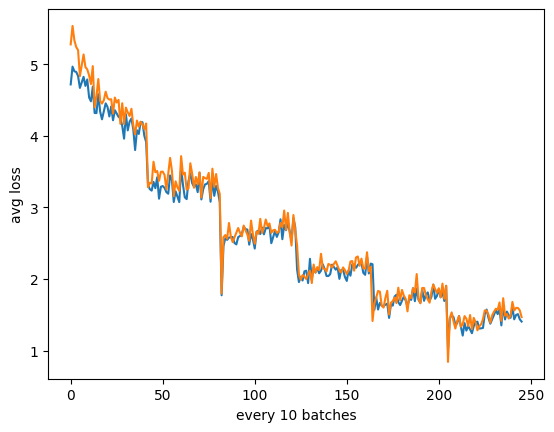

In [ ]:
get_output_by_project('flink',-1,2,None,'check whether',0.1)

INFO:root:Epoch 1, batch 0: 5.558569431304932
INFO:root:epoch: 1/50, batch: 0/201, avg loss: 5.5586
INFO:root:Epoch 1, batch 0/16: 5.558569431304932


time:  0h  0min  2s   5ms, remaining: 11h 12min  2s 121ms, epoch:  1/50, batch:   0/201, percent complete:   0.00%, avg loss: 5.5586
Epoch 1, batch 0/16: 5.558569431304932


INFO:root:Epoch 1, batch 1: 5.678630828857422
INFO:root:Epoch 1, batch 2: 5.2340474128723145
INFO:root:Epoch 1, batch 3: 5.669428825378418
INFO:root:Epoch 1, batch 4: 5.2923126220703125
INFO:root:Epoch 1, batch 5: 5.252990245819092
INFO:root:Epoch 1, batch 6: 4.947035789489746
INFO:root:Epoch 1, batch 7: 4.737636566162109
INFO:root:Epoch 1, batch 8: 5.440598011016846
INFO:root:Epoch 1, batch 9: 5.197486877441406
INFO:root:Epoch 1, batch 10: 4.595427989959717
INFO:root:Epoch 1, batch 11: 5.250786781311035
INFO:root:Epoch 1, batch 12: 4.684216499328613
INFO:root:Epoch 1, batch 13: 5.1644062995910645
INFO:root:Epoch 1, batch 14: 4.988311767578125
INFO:root:Epoch 1, batch 15: 5.549172401428223
INFO:root:Epoch 1, batch 16: 4.773941993713379
INFO:root:Epoch 1, batch 17: 4.695831298828125
INFO:root:Epoch 1, batch 18: 5.061660289764404
INFO:root:Epoch 1, batch 19: 5.017454147338867
INFO:root:Epoch 1, batch 20: 5.625975131988525
INFO:root:Epoch 1, batch 21: 4.564162731170654
INFO:root:Epoch 1, 

time:  0h  0min 39s 335ms, remaining:  0h 32min 13s 240ms, epoch:  1/50, batch: 200/201, percent complete:   1.99%, avg loss: 4.5591
Epoch 1, batch 200/16: 911.8118283748627


INFO:root:Epoch 1, batch 202: 5.052539348602295
INFO:root:Epoch 1, batch 203: 4.133108139038086
INFO:root:Epoch 1, batch 204: 4.817784309387207
INFO:root:Epoch 1, batch 205: 5.139033317565918
INFO:root:Epoch 1, batch 206: 4.143575668334961
INFO:root:Epoch 1, batch 207: 4.395432472229004
INFO:root:Epoch 1, batch 208: 4.374667644500732
INFO:root:Epoch 1, batch 209: 3.9396493434906006
INFO:root:Epoch 1, batch 210: 3.612287998199463
INFO:root:Epoch 1, batch 211: 3.433583974838257
INFO:root:Epoch 1, batch 212: 4.409818172454834
INFO:root:Epoch 1, batch 213: 4.5913567543029785
INFO:root:Epoch 1, batch 214: 4.127031326293945
INFO:root:Epoch 1, batch 215: 4.4610185623168945
INFO:root:Epoch 1, batch 216: 4.6974358558654785
INFO:root:Epoch 1, batch 217: 4.054011821746826
INFO:root:Epoch 1, batch 218: 4.157797813415527
INFO:root:Epoch 1, batch 219: 3.8330166339874268
INFO:root:Epoch 1, batch 220: 3.838237762451172
INFO:root:Epoch 1, batch 221: 4.359164714813232
INFO:root:Epoch 1, batch 222: 4.157

time:  0h  1min 17s  10ms, remaining:  0h 30min 56s 353ms, epoch:  1/50, batch: 400/201, percent complete:   3.98%, avg loss: 4.1811
Epoch 1, batch 400/16: 836.2154903411865


INFO:root:Epoch 1, batch 401: 4.480933666229248
INFO:root:Epoch 1, batch 402: 4.235041618347168
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1211.


Validate completed, avg loss: 5.1211.



INFO:root:Epoch 2, batch 0: 4.250368595123291
INFO:root:epoch: 2/50, batch: 0/201, avg loss: 4.2504
INFO:root:Epoch 2, batch 0/16: 4.250368595123291


time:  0h  1min 20s 768ms, remaining:  1h  5min 47s 628ms, epoch:  2/50, batch:   0/201, percent complete:   2.00%, avg loss: 4.2504
Epoch 2, batch 0/16: 4.250368595123291


INFO:root:Epoch 2, batch 1: 2.7308919429779053
INFO:root:Epoch 2, batch 2: 3.421030044555664
INFO:root:Epoch 2, batch 3: 3.428173065185547
INFO:root:Epoch 2, batch 4: 3.5071797370910645
INFO:root:Epoch 2, batch 5: 3.5362329483032227
INFO:root:Epoch 2, batch 6: 3.622783899307251
INFO:root:Epoch 2, batch 7: 3.064866065979004
INFO:root:Epoch 2, batch 8: 3.301372528076172
INFO:root:Epoch 2, batch 9: 2.976945400238037
INFO:root:Epoch 2, batch 10: 3.122446298599243
INFO:root:Epoch 2, batch 11: 3.15120792388916
INFO:root:Epoch 2, batch 12: 3.2778172492980957
INFO:root:Epoch 2, batch 13: 3.283705472946167
INFO:root:Epoch 2, batch 14: 2.7161362171173096
INFO:root:Epoch 2, batch 15: 3.65278959274292
INFO:root:Epoch 2, batch 16: 3.577467679977417
INFO:root:Epoch 2, batch 17: 2.7852025032043457
INFO:root:Epoch 2, batch 18: 3.07629656791687
INFO:root:Epoch 2, batch 19: 2.7972018718719482
INFO:root:Epoch 2, batch 20: 3.325039863586426
INFO:root:Epoch 2, batch 21: 3.186297655105591
INFO:root:Epoch 2,

time:  0h  1min 59s  75ms, remaining:  0h 47min 42s 212ms, epoch:  2/50, batch: 200/201, percent complete:   3.99%, avg loss: 3.2634
Epoch 2, batch 200/16: 652.675285577774


INFO:root:Epoch 2, batch 201: 3.4918298721313477
INFO:root:Epoch 2, batch 202: 3.725192070007324
INFO:root:Epoch 2, batch 203: 3.206003189086914
INFO:root:Epoch 2, batch 204: 2.9919512271881104
INFO:root:Epoch 2, batch 205: 3.738532543182373
INFO:root:Epoch 2, batch 206: 3.4031922817230225
INFO:root:Epoch 2, batch 207: 3.3125860691070557
INFO:root:Epoch 2, batch 208: 3.9970285892486572
INFO:root:Epoch 2, batch 209: 2.9478390216827393
INFO:root:Epoch 2, batch 210: 3.317340612411499
INFO:root:Epoch 2, batch 211: 3.783243179321289
INFO:root:Epoch 2, batch 212: 3.2772583961486816
INFO:root:Epoch 2, batch 213: 2.950519323348999
INFO:root:Epoch 2, batch 214: 3.6036226749420166
INFO:root:Epoch 2, batch 215: 2.7430875301361084
INFO:root:Epoch 2, batch 216: 3.2705814838409424
INFO:root:Epoch 2, batch 217: 3.407909870147705
INFO:root:Epoch 2, batch 218: 2.5687320232391357
INFO:root:Epoch 2, batch 219: 3.3349363803863525
INFO:root:Epoch 2, batch 220: 3.267322063446045
INFO:root:Epoch 2, batch 221

time:  0h  2min 37s 641ms, remaining:  0h 41min 17s  81ms, epoch:  2/50, batch: 400/201, percent complete:   5.98%, avg loss: 3.2721
Epoch 2, batch 400/16: 654.4248073101044


INFO:root:Epoch 2, batch 402: 2.579960584640503
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2278.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.2278.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 3, batch 0: 2.5009267330169678
INFO:root:epoch: 3/50, batch: 0/201, avg loss: 2.5009
INFO:root:Epoch 3, batch 0/16: 2.5009267330169678
INFO:root:Epoch 3, batch 1: 2.578874111175537


time:  0h  2min 41s 237ms, remaining:  1h  4min 24s 696ms, epoch:  3/50, batch:   0/201, percent complete:   4.00%, avg loss: 2.5009
Epoch 3, batch 0/16: 2.5009267330169678


INFO:root:Epoch 3, batch 2: 2.4393310546875
INFO:root:Epoch 3, batch 3: 2.950979709625244
INFO:root:Epoch 3, batch 4: 2.53637433052063
INFO:root:Epoch 3, batch 5: 2.0982766151428223
INFO:root:Epoch 3, batch 6: 2.370272397994995
INFO:root:Epoch 3, batch 7: 2.421685218811035
INFO:root:Epoch 3, batch 8: 2.2627508640289307
INFO:root:Epoch 3, batch 9: 2.0863077640533447
INFO:root:Epoch 3, batch 10: 2.3453824520111084
INFO:root:Epoch 3, batch 11: 2.7524328231811523
INFO:root:Epoch 3, batch 12: 2.4051551818847656
INFO:root:Epoch 3, batch 13: 2.4503839015960693
INFO:root:Epoch 3, batch 14: 2.5897645950317383
INFO:root:Epoch 3, batch 15: 2.5971553325653076
INFO:root:Epoch 3, batch 16: 2.538158416748047
INFO:root:Epoch 3, batch 17: 2.022707462310791
INFO:root:Epoch 3, batch 18: 2.8052895069122314
INFO:root:Epoch 3, batch 19: 2.550459623336792
INFO:root:Epoch 3, batch 20: 3.2484374046325684
INFO:root:Epoch 3, batch 21: 3.060195207595825
INFO:root:Epoch 3, batch 22: 2.0735602378845215
INFO:root:Ep

time:  0h  3min 20s  27ms, remaining:  0h 52min 17s  45ms, epoch:  3/50, batch: 200/201, percent complete:   5.99%, avg loss: 2.5224
Epoch 3, batch 200/16: 504.478084564209


INFO:root:Epoch 3, batch 202: 1.9501227140426636
INFO:root:Epoch 3, batch 203: 1.8719394207000732
INFO:root:Epoch 3, batch 204: 3.1106271743774414
INFO:root:Epoch 3, batch 205: 2.562546491622925
INFO:root:Epoch 3, batch 206: 2.2866458892822266
INFO:root:Epoch 3, batch 207: 2.4097371101379395
INFO:root:Epoch 3, batch 208: 2.6083755493164062
INFO:root:Epoch 3, batch 209: 2.4338953495025635
INFO:root:Epoch 3, batch 210: 2.9582862854003906
INFO:root:Epoch 3, batch 211: 2.604931592941284
INFO:root:Epoch 3, batch 212: 2.629927158355713
INFO:root:Epoch 3, batch 213: 2.7352709770202637
INFO:root:Epoch 3, batch 214: 2.9935126304626465
INFO:root:Epoch 3, batch 215: 2.7944860458374023
INFO:root:Epoch 3, batch 216: 2.5153913497924805
INFO:root:Epoch 3, batch 217: 2.354149103164673
INFO:root:Epoch 3, batch 218: 2.295337677001953
INFO:root:Epoch 3, batch 219: 3.003535270690918
INFO:root:Epoch 3, batch 220: 3.510509490966797
INFO:root:Epoch 3, batch 221: 2.5558457374572754
INFO:root:Epoch 3, batch 22

time:  0h  3min 58s  89ms, remaining:  0h 45min 44s 285ms, epoch:  3/50, batch: 400/201, percent complete:   7.98%, avg loss: 2.6278
Epoch 3, batch 400/16: 525.566237449646


INFO:root:Epoch 3, batch 401: 3.060067892074585
INFO:root:Epoch 3, batch 402: 4.00476598739624
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5337.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.9839632511138916
INFO:root:epoch: 4/50, batch: 0/201, avg loss: 1.9840
INFO:root:Epoch 4, batch 0/16: 1.9839632511138916


Validate completed, avg loss: 5.5337.

EarlyStopping counter: 2 out of 5.

time:  0h  4min  1s 710ms, remaining:  1h  3min  3s 454ms, epoch:  4/50, batch:   0/201, percent complete:   6.00%, avg loss: 1.9840
Epoch 4, batch 0/16: 1.9839632511138916


INFO:root:Epoch 4, batch 1: 1.8900489807128906
INFO:root:Epoch 4, batch 2: 2.547173261642456
INFO:root:Epoch 4, batch 3: 1.6391676664352417
INFO:root:Epoch 4, batch 4: 1.5847160816192627
INFO:root:Epoch 4, batch 5: 2.2550833225250244
INFO:root:Epoch 4, batch 6: 1.4667081832885742
INFO:root:Epoch 4, batch 7: 2.2737414836883545
INFO:root:Epoch 4, batch 8: 1.516864538192749
INFO:root:Epoch 4, batch 9: 1.7617876529693604
INFO:root:Epoch 4, batch 10: 2.0327084064483643
INFO:root:Epoch 4, batch 11: 1.6733342409133911
INFO:root:Epoch 4, batch 12: 1.8938974142074585
INFO:root:Epoch 4, batch 13: 2.4744720458984375
INFO:root:Epoch 4, batch 14: 2.0790109634399414
INFO:root:Epoch 4, batch 15: 1.5445773601531982
INFO:root:Epoch 4, batch 16: 2.192429780960083
INFO:root:Epoch 4, batch 17: 2.6037449836730957
INFO:root:Epoch 4, batch 18: 1.4210273027420044
INFO:root:Epoch 4, batch 19: 1.6931604146957397
INFO:root:Epoch 4, batch 20: 2.102586507797241
INFO:root:Epoch 4, batch 21: 2.079981803894043
INFO:r

time:  0h  4min 40s  35ms, remaining:  0h 53min 42s 997ms, epoch:  4/50, batch: 200/201, percent complete:   7.99%, avg loss: 2.0341
Epoch 4, batch 200/16: 406.82635402679443


INFO:root:Epoch 4, batch 202: 1.5611284971237183
INFO:root:Epoch 4, batch 203: 2.0257151126861572
INFO:root:Epoch 4, batch 204: 1.6098655462265015
INFO:root:Epoch 4, batch 205: 1.860656976699829
INFO:root:Epoch 4, batch 206: 2.246212959289551
INFO:root:Epoch 4, batch 207: 2.1876935958862305
INFO:root:Epoch 4, batch 208: 2.044910430908203
INFO:root:Epoch 4, batch 209: 1.7760732173919678
INFO:root:Epoch 4, batch 210: 2.569566488265991
INFO:root:Epoch 4, batch 211: 2.149488687515259
INFO:root:Epoch 4, batch 212: 2.485588312149048
INFO:root:Epoch 4, batch 213: 2.4682364463806152
INFO:root:Epoch 4, batch 214: 2.110309362411499
INFO:root:Epoch 4, batch 215: 2.323746681213379
INFO:root:Epoch 4, batch 216: 2.160719394683838
INFO:root:Epoch 4, batch 217: 2.4736552238464355
INFO:root:Epoch 4, batch 218: 1.9463897943496704
INFO:root:Epoch 4, batch 219: 2.0409393310546875
INFO:root:Epoch 4, batch 220: 2.894134998321533
INFO:root:Epoch 4, batch 221: 2.089944839477539
INFO:root:Epoch 4, batch 222: 2

time:  0h  5min 17s 849ms, remaining:  0h 47min 45s 990ms, epoch:  4/50, batch: 400/201, percent complete:   9.98%, avg loss: 2.1237
Epoch 4, batch 400/16: 424.74406373500824


INFO:root:Epoch 4, batch 401: 2.372985601425171
INFO:root:Epoch 4, batch 402: 2.448601722717285
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6876.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.2183036804199219
INFO:root:epoch: 5/50, batch: 0/201, avg loss: 1.2183
INFO:root:Epoch 5, batch 0/16: 1.2183036804199219


Validate completed, avg loss: 5.6876.

EarlyStopping counter: 3 out of 5.

time:  0h  5min 21s 534ms, remaining:  1h  1min 35s 154ms, epoch:  5/50, batch:   0/201, percent complete:   8.00%, avg loss: 1.2183
Epoch 5, batch 0/16: 1.2183036804199219


INFO:root:Epoch 5, batch 1: 1.3801243305206299
INFO:root:Epoch 5, batch 2: 1.4766923189163208
INFO:root:Epoch 5, batch 3: 1.4258009195327759
INFO:root:Epoch 5, batch 4: 1.229020595550537
INFO:root:Epoch 5, batch 5: 1.314359188079834
INFO:root:Epoch 5, batch 6: 1.6702851057052612
INFO:root:Epoch 5, batch 7: 1.9459564685821533
INFO:root:Epoch 5, batch 8: 2.0716354846954346
INFO:root:Epoch 5, batch 9: 0.9352245330810547
INFO:root:Epoch 5, batch 10: 1.4037799835205078
INFO:root:Epoch 5, batch 11: 1.840825080871582
INFO:root:Epoch 5, batch 12: 1.6383461952209473
INFO:root:Epoch 5, batch 13: 1.4253828525543213
INFO:root:Epoch 5, batch 14: 2.1730315685272217
INFO:root:Epoch 5, batch 15: 0.9114713072776794
INFO:root:Epoch 5, batch 16: 1.8156250715255737
INFO:root:Epoch 5, batch 17: 1.619176983833313
INFO:root:Epoch 5, batch 18: 1.6939157247543335
INFO:root:Epoch 5, batch 19: 1.6820974349975586
INFO:root:Epoch 5, batch 20: 1.3831636905670166
INFO:root:Epoch 5, batch 21: 1.2464864253997803
INFO:

time:  0h  5min 59s 603ms, remaining:  0h 53min 58s 557ms, epoch:  5/50, batch: 200/201, percent complete:   9.99%, avg loss: 1.6684
Epoch 5, batch 200/16: 333.6702428460121


INFO:root:Epoch 5, batch 202: 1.4538719654083252
INFO:root:Epoch 5, batch 203: 2.7149994373321533
INFO:root:Epoch 5, batch 204: 2.2623045444488525
INFO:root:Epoch 5, batch 205: 1.6316875219345093
INFO:root:Epoch 5, batch 206: 1.7815685272216797
INFO:root:Epoch 5, batch 207: 1.853265643119812
INFO:root:Epoch 5, batch 208: 1.703177809715271
INFO:root:Epoch 5, batch 209: 1.4593294858932495
INFO:root:Epoch 5, batch 210: 1.8965531587600708
INFO:root:Epoch 5, batch 211: 1.3530347347259521
INFO:root:Epoch 5, batch 212: 2.2441446781158447
INFO:root:Epoch 5, batch 213: 1.6670098304748535
INFO:root:Epoch 5, batch 214: 1.9270166158676147
INFO:root:Epoch 5, batch 215: 2.0202839374542236
INFO:root:Epoch 5, batch 216: 1.4227993488311768
INFO:root:Epoch 5, batch 217: 1.6449321508407593
INFO:root:Epoch 5, batch 218: 1.9128012657165527
INFO:root:Epoch 5, batch 219: 1.430615782737732
INFO:root:Epoch 5, batch 220: 1.7071681022644043
INFO:root:Epoch 5, batch 221: 2.1724624633789062
INFO:root:Epoch 5, batc

time:  0h  6min 38s  90ms, remaining:  0h 48min 43s 978ms, epoch:  5/50, batch: 400/201, percent complete:  11.98%, avg loss: 1.7732
Epoch 5, batch 400/16: 354.64473605155945


INFO:root:Epoch 5, batch 401: 1.6482387781143188
INFO:root:Epoch 5, batch 402: 2.6194770336151123
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.9619.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 1.0422592163085938
INFO:root:epoch: 6/50, batch: 0/201, avg loss: 1.0423
INFO:root:Epoch 6, batch 0/16: 1.0422592163085938


Validate completed, avg loss: 5.9619.

EarlyStopping counter: 4 out of 5.

time:  0h  6min 41s 803ms, remaining:  1h  0min 14s 230ms, epoch:  6/50, batch:   0/201, percent complete:  10.00%, avg loss: 1.0423
Epoch 6, batch 0/16: 1.0422592163085938


INFO:root:Epoch 6, batch 1: 1.3789626359939575
INFO:root:Epoch 6, batch 2: 1.2672703266143799
INFO:root:Epoch 6, batch 3: 1.260481834411621
INFO:root:Epoch 6, batch 4: 1.0515589714050293
INFO:root:Epoch 6, batch 5: 1.0260825157165527
INFO:root:Epoch 6, batch 6: 1.6940441131591797
INFO:root:Epoch 6, batch 7: 1.3513410091400146
INFO:root:Epoch 6, batch 8: 1.1185849905014038
INFO:root:Epoch 6, batch 9: 0.8770443797111511
INFO:root:Epoch 6, batch 10: 1.6962363719940186
INFO:root:Epoch 6, batch 11: 1.2217192649841309
INFO:root:Epoch 6, batch 12: 1.5649958848953247
INFO:root:Epoch 6, batch 13: 1.5443543195724487
INFO:root:Epoch 6, batch 14: 0.9513506889343262
INFO:root:Epoch 6, batch 15: 1.4413059949874878
INFO:root:Epoch 6, batch 16: 1.3265984058380127
INFO:root:Epoch 6, batch 17: 1.4968770742416382
INFO:root:Epoch 6, batch 18: 1.4006001949310303
INFO:root:Epoch 6, batch 19: 1.0887441635131836
INFO:root:Epoch 6, batch 20: 1.1128904819488525
INFO:root:Epoch 6, batch 21: 1.286261796951294
INF

time:  0h  7min 19s 777ms, remaining:  0h 53min 46s 841ms, epoch:  6/50, batch: 200/201, percent complete:  11.99%, avg loss: 1.3451
Epoch 6, batch 200/16: 269.01700085401535


INFO:root:Epoch 6, batch 201: 1.1240251064300537
INFO:root:Epoch 6, batch 202: 1.4114145040512085
INFO:root:Epoch 6, batch 203: 0.9910716414451599
INFO:root:Epoch 6, batch 204: 1.5144882202148438
INFO:root:Epoch 6, batch 205: 1.2230466604232788
INFO:root:Epoch 6, batch 206: 1.4504108428955078
INFO:root:Epoch 6, batch 207: 1.380677580833435
INFO:root:Epoch 6, batch 208: 1.2785474061965942
INFO:root:Epoch 6, batch 209: 1.2930057048797607
INFO:root:Epoch 6, batch 210: 0.9927645325660706
INFO:root:Epoch 6, batch 211: 1.2151955366134644
INFO:root:Epoch 6, batch 212: 1.068934679031372
INFO:root:Epoch 6, batch 213: 1.5820565223693848
INFO:root:Epoch 6, batch 214: 1.819628119468689
INFO:root:Epoch 6, batch 215: 1.0036052465438843
INFO:root:Epoch 6, batch 216: 2.1510379314422607
INFO:root:Epoch 6, batch 217: 1.0496248006820679
INFO:root:Epoch 6, batch 218: 1.4563026428222656
INFO:root:Epoch 6, batch 219: 1.560190200805664
INFO:root:Epoch 6, batch 220: 0.9206660389900208
INFO:root:Epoch 6, batch

time:  0h  7min 58s 254ms, remaining:  0h 49min  1s 948ms, epoch:  6/50, batch: 400/201, percent complete:  13.98%, avg loss: 1.4955
Epoch 6, batch 400/16: 299.10659515857697


INFO:root:Epoch 6, batch 401: 1.4075937271118164
INFO:root:Epoch 6, batch 402: 2.1241812705993652
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.2042.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.2042.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 6.268096446990967
INFO:root:epoch: 1/50, batch: 0/201, avg loss: 6.2681
INFO:root:Epoch 1, batch 0/16: 6.268096446990967
INFO:root:Epoch 1, batch 1: 5.852783203125


time:  0h  0min  0s 242ms, remaining:  1h 21min 20s 582ms, epoch:  1/50, batch:   0/201, percent complete:   0.00%, avg loss: 6.2681
Epoch 1, batch 0/16: 6.268096446990967


INFO:root:Epoch 1, batch 2: 6.136997699737549
INFO:root:Epoch 1, batch 3: 6.590572357177734
INFO:root:Epoch 1, batch 4: 5.327580451965332
INFO:root:Epoch 1, batch 5: 5.789366245269775
INFO:root:Epoch 1, batch 6: 5.066476345062256
INFO:root:Epoch 1, batch 7: 5.4773478507995605
INFO:root:Epoch 1, batch 8: 5.873386383056641
INFO:root:Epoch 1, batch 9: 6.108108043670654
INFO:root:Epoch 1, batch 10: 4.979379177093506
INFO:root:Epoch 1, batch 11: 5.611871242523193
INFO:root:Epoch 1, batch 12: 5.561349868774414
INFO:root:Epoch 1, batch 13: 5.837926387786865
INFO:root:Epoch 1, batch 14: 5.3695807456970215
INFO:root:Epoch 1, batch 15: 6.130198955535889
INFO:root:Epoch 1, batch 16: 5.277833938598633
INFO:root:Epoch 1, batch 17: 5.5793256759643555
INFO:root:Epoch 1, batch 18: 4.865523815155029
INFO:root:Epoch 1, batch 19: 5.305284023284912
INFO:root:Epoch 1, batch 20: 6.372041702270508
INFO:root:Epoch 1, batch 21: 4.947062969207764
INFO:root:Epoch 1, batch 22: 4.843204498291016
INFO:root:Epoch 1,

time:  0h  0min 39s  76ms, remaining:  0h 32min  0s 528ms, epoch:  1/50, batch: 200/201, percent complete:   1.99%, avg loss: 4.8265
Epoch 1, batch 200/16: 965.3074932098389


INFO:root:Epoch 1, batch 202: 5.290948867797852
INFO:root:Epoch 1, batch 203: 4.648210525512695
INFO:root:Epoch 1, batch 204: 4.305925369262695
INFO:root:Epoch 1, batch 205: 5.057922840118408
INFO:root:Epoch 1, batch 206: 4.2355055809021
INFO:root:Epoch 1, batch 207: 4.891326904296875
INFO:root:Epoch 1, batch 208: 4.481998443603516
INFO:root:Epoch 1, batch 209: 3.857377290725708
INFO:root:Epoch 1, batch 210: 4.107211112976074
INFO:root:Epoch 1, batch 211: 3.801582098007202
INFO:root:Epoch 1, batch 212: 4.680384159088135
INFO:root:Epoch 1, batch 213: 4.682173252105713
INFO:root:Epoch 1, batch 214: 4.34576940536499
INFO:root:Epoch 1, batch 215: 4.6698832511901855
INFO:root:Epoch 1, batch 216: 4.5388641357421875
INFO:root:Epoch 1, batch 217: 4.0374016761779785
INFO:root:Epoch 1, batch 218: 4.741119861602783
INFO:root:Epoch 1, batch 219: 4.3065595626831055
INFO:root:Epoch 1, batch 220: 3.7839972972869873
INFO:root:Epoch 1, batch 221: 4.512269496917725
INFO:root:Epoch 1, batch 222: 3.969715

time:  0h  1min 17s 776ms, remaining:  0h 31min 14s 824ms, epoch:  1/50, batch: 400/201, percent complete:   3.98%, avg loss: 4.3151
Epoch 1, batch 400/16: 863.0220675468445


INFO:root:Epoch 1, batch 401: 4.36796760559082
INFO:root:Epoch 1, batch 402: 4.098361492156982
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1524.
INFO:root:Epoch 2, batch 0: 4.498287677764893


Validate completed, avg loss: 5.1524.



INFO:root:epoch: 2/50, batch: 0/201, avg loss: 4.4983
INFO:root:Epoch 2, batch 0/16: 4.498287677764893


time:  0h  1min 21s 476ms, remaining:  1h  6min 22s 241ms, epoch:  2/50, batch:   0/201, percent complete:   2.00%, avg loss: 4.4983
Epoch 2, batch 0/16: 4.498287677764893


INFO:root:Epoch 2, batch 1: 2.790511131286621
INFO:root:Epoch 2, batch 2: 2.982393503189087
INFO:root:Epoch 2, batch 3: 3.3608081340789795
INFO:root:Epoch 2, batch 4: 3.5379064083099365
INFO:root:Epoch 2, batch 5: 3.6533093452453613
INFO:root:Epoch 2, batch 6: 3.8877718448638916
INFO:root:Epoch 2, batch 7: 3.4545748233795166
INFO:root:Epoch 2, batch 8: 3.413139581680298
INFO:root:Epoch 2, batch 9: 3.4363656044006348
INFO:root:Epoch 2, batch 10: 3.3084514141082764
INFO:root:Epoch 2, batch 11: 3.1383755207061768
INFO:root:Epoch 2, batch 12: 3.2045092582702637
INFO:root:Epoch 2, batch 13: 3.42854380607605
INFO:root:Epoch 2, batch 14: 2.645047903060913
INFO:root:Epoch 2, batch 15: 3.5251681804656982
INFO:root:Epoch 2, batch 16: 3.8562252521514893
INFO:root:Epoch 2, batch 17: 3.0395116806030273
INFO:root:Epoch 2, batch 18: 3.152418613433838
INFO:root:Epoch 2, batch 19: 3.02925181388855
INFO:root:Epoch 2, batch 20: 3.418463945388794
INFO:root:Epoch 2, batch 21: 3.4302303791046143
INFO:root:E

time:  0h  2min  0s 128ms, remaining:  0h 48min  7s 525ms, epoch:  2/50, batch: 200/201, percent complete:   3.99%, avg loss: 3.3939
Epoch 2, batch 200/16: 678.7865345478058


INFO:root:Epoch 2, batch 201: 3.460635185241699
INFO:root:Epoch 2, batch 202: 3.979832410812378
INFO:root:Epoch 2, batch 203: 3.4992756843566895
INFO:root:Epoch 2, batch 204: 3.0814077854156494
INFO:root:Epoch 2, batch 205: 3.7510406970977783
INFO:root:Epoch 2, batch 206: 3.444321870803833
INFO:root:Epoch 2, batch 207: 3.4854135513305664
INFO:root:Epoch 2, batch 208: 3.4754254817962646
INFO:root:Epoch 2, batch 209: 2.9876279830932617
INFO:root:Epoch 2, batch 210: 3.3220596313476562
INFO:root:Epoch 2, batch 211: 3.6706080436706543
INFO:root:Epoch 2, batch 212: 3.1086385250091553
INFO:root:Epoch 2, batch 213: 3.056352138519287
INFO:root:Epoch 2, batch 214: 4.077030658721924
INFO:root:Epoch 2, batch 215: 2.799612283706665
INFO:root:Epoch 2, batch 216: 3.633979558944702
INFO:root:Epoch 2, batch 217: 3.4568254947662354
INFO:root:Epoch 2, batch 218: 2.9163997173309326
INFO:root:Epoch 2, batch 219: 3.6540584564208984
INFO:root:Epoch 2, batch 220: 3.1740334033966064
INFO:root:Epoch 2, batch 22

time:  0h  2min 39s 275ms, remaining:  0h 41min 42s 761ms, epoch:  2/50, batch: 400/201, percent complete:   5.98%, avg loss: 3.3937
Epoch 2, batch 400/16: 678.7409908771515


INFO:root:Epoch 2, batch 402: 2.859631299972534
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3235.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.3235.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 3, batch 0: 2.6894514560699463
INFO:root:epoch: 3/50, batch: 0/201, avg loss: 2.6895
INFO:root:Epoch 3, batch 0/16: 2.6894514560699463
INFO:root:Epoch 3, batch 1: 2.9617555141448975


time:  0h  2min 42s 910ms, remaining:  1h  5min  4s 805ms, epoch:  3/50, batch:   0/201, percent complete:   4.00%, avg loss: 2.6895
Epoch 3, batch 0/16: 2.6894514560699463


INFO:root:Epoch 3, batch 2: 2.187399387359619
INFO:root:Epoch 3, batch 3: 3.228259325027466
INFO:root:Epoch 3, batch 4: 2.602281332015991
INFO:root:Epoch 3, batch 5: 1.9581162929534912
INFO:root:Epoch 3, batch 6: 2.500868320465088
INFO:root:Epoch 3, batch 7: 2.7927615642547607
INFO:root:Epoch 3, batch 8: 2.2333641052246094
INFO:root:Epoch 3, batch 9: 2.100541114807129
INFO:root:Epoch 3, batch 10: 2.6636745929718018
INFO:root:Epoch 3, batch 11: 2.8894565105438232
INFO:root:Epoch 3, batch 12: 2.2140610218048096
INFO:root:Epoch 3, batch 13: 2.3823375701904297
INFO:root:Epoch 3, batch 14: 2.7775533199310303
INFO:root:Epoch 3, batch 15: 2.732912302017212
INFO:root:Epoch 3, batch 16: 3.013680934906006
INFO:root:Epoch 3, batch 17: 1.790993571281433
INFO:root:Epoch 3, batch 18: 2.961977005004883
INFO:root:Epoch 3, batch 19: 2.7580676078796387
INFO:root:Epoch 3, batch 20: 3.0607833862304688
INFO:root:Epoch 3, batch 21: 2.67878794670105
INFO:root:Epoch 3, batch 22: 2.1335225105285645
INFO:root:E

time:  0h  3min 22s  45ms, remaining:  0h 52min 48s 695ms, epoch:  3/50, batch: 200/201, percent complete:   5.99%, avg loss: 2.6375
Epoch 3, batch 200/16: 527.5038715600967


INFO:root:Epoch 3, batch 202: 2.5515244007110596
INFO:root:Epoch 3, batch 203: 1.9942567348480225
INFO:root:Epoch 3, batch 204: 2.8841512203216553
INFO:root:Epoch 3, batch 205: 2.276069402694702
INFO:root:Epoch 3, batch 206: 2.6729705333709717
INFO:root:Epoch 3, batch 207: 2.5938971042633057
INFO:root:Epoch 3, batch 208: 2.623419761657715
INFO:root:Epoch 3, batch 209: 2.727274179458618
INFO:root:Epoch 3, batch 210: 2.6472976207733154
INFO:root:Epoch 3, batch 211: 2.6675925254821777
INFO:root:Epoch 3, batch 212: 2.709843158721924
INFO:root:Epoch 3, batch 213: 2.432905673980713
INFO:root:Epoch 3, batch 214: 2.6314139366149902
INFO:root:Epoch 3, batch 215: 2.703104019165039
INFO:root:Epoch 3, batch 216: 3.117877721786499
INFO:root:Epoch 3, batch 217: 2.456711530685425
INFO:root:Epoch 3, batch 218: 2.5934808254241943
INFO:root:Epoch 3, batch 219: 2.869088888168335
INFO:root:Epoch 3, batch 220: 3.3122847080230713
INFO:root:Epoch 3, batch 221: 2.26875901222229
INFO:root:Epoch 3, batch 222: 3

time:  0h  4min  0s 611ms, remaining:  0h 46min 13s 352ms, epoch:  3/50, batch: 400/201, percent complete:   7.98%, avg loss: 2.7277
Epoch 3, batch 400/16: 545.5453946590424


INFO:root:Epoch 3, batch 401: 2.811401128768921
INFO:root:Epoch 3, batch 402: 3.5269367694854736
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5141.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 2.0898754596710205
INFO:root:epoch: 4/50, batch: 0/201, avg loss: 2.0899
INFO:root:Epoch 4, batch 0/16: 2.0898754596710205


Validate completed, avg loss: 5.5141.

EarlyStopping counter: 2 out of 5.

time:  0h  4min  4s 269ms, remaining:  1h  3min 43s 512ms, epoch:  4/50, batch:   0/201, percent complete:   6.00%, avg loss: 2.0899
Epoch 4, batch 0/16: 2.0898754596710205


INFO:root:Epoch 4, batch 1: 1.9515429735183716
INFO:root:Epoch 4, batch 2: 2.2277257442474365
INFO:root:Epoch 4, batch 3: 1.8039246797561646
INFO:root:Epoch 4, batch 4: 1.644501805305481
INFO:root:Epoch 4, batch 5: 2.185398578643799
INFO:root:Epoch 4, batch 6: 1.5035152435302734
INFO:root:Epoch 4, batch 7: 2.3733303546905518
INFO:root:Epoch 4, batch 8: 1.6895062923431396
INFO:root:Epoch 4, batch 9: 1.7646247148513794
INFO:root:Epoch 4, batch 10: 2.078902244567871
INFO:root:Epoch 4, batch 11: 1.921079158782959
INFO:root:Epoch 4, batch 12: 2.1456000804901123
INFO:root:Epoch 4, batch 13: 2.753645420074463
INFO:root:Epoch 4, batch 14: 2.1219141483306885
INFO:root:Epoch 4, batch 15: 1.8360527753829956
INFO:root:Epoch 4, batch 16: 2.3189995288848877
INFO:root:Epoch 4, batch 17: 2.459789276123047
INFO:root:Epoch 4, batch 18: 2.0587141513824463
INFO:root:Epoch 4, batch 19: 1.9540035724639893
INFO:root:Epoch 4, batch 20: 2.2785987854003906
INFO:root:Epoch 4, batch 21: 2.030482530593872
INFO:roo

time:  0h  4min 43s  44ms, remaining:  0h 54min 17s 630ms, epoch:  4/50, batch: 200/201, percent complete:   7.99%, avg loss: 2.1239
Epoch 4, batch 200/16: 424.7745839357376


INFO:root:Epoch 4, batch 202: 1.6592482328414917
INFO:root:Epoch 4, batch 203: 1.947177767753601
INFO:root:Epoch 4, batch 204: 2.085706949234009
INFO:root:Epoch 4, batch 205: 2.1617774963378906
INFO:root:Epoch 4, batch 206: 1.9542503356933594
INFO:root:Epoch 4, batch 207: 2.4161431789398193
INFO:root:Epoch 4, batch 208: 2.01271915435791
INFO:root:Epoch 4, batch 209: 1.930093765258789
INFO:root:Epoch 4, batch 210: 2.4417684078216553
INFO:root:Epoch 4, batch 211: 2.283754587173462
INFO:root:Epoch 4, batch 212: 2.36215877532959
INFO:root:Epoch 4, batch 213: 2.1583003997802734
INFO:root:Epoch 4, batch 214: 2.4115607738494873
INFO:root:Epoch 4, batch 215: 2.2755467891693115
INFO:root:Epoch 4, batch 216: 2.0031826496124268
INFO:root:Epoch 4, batch 217: 2.975576162338257
INFO:root:Epoch 4, batch 218: 2.2048287391662598
INFO:root:Epoch 4, batch 219: 2.0034005641937256
INFO:root:Epoch 4, batch 220: 2.606144905090332
INFO:root:Epoch 4, batch 221: 1.9725168943405151
INFO:root:Epoch 4, batch 222: 

time:  0h  5min 21s 266ms, remaining:  0h 48min 16s 800ms, epoch:  4/50, batch: 400/201, percent complete:   9.98%, avg loss: 2.2044
Epoch 4, batch 400/16: 440.8723237514496


INFO:root:Epoch 4, batch 401: 2.105496644973755
INFO:root:Epoch 4, batch 402: 3.2338171005249023
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7638.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.4693961143493652
INFO:root:epoch: 5/50, batch: 0/201, avg loss: 1.4694
INFO:root:Epoch 5, batch 0/16: 1.4693961143493652


Validate completed, avg loss: 5.7638.

EarlyStopping counter: 3 out of 5.

time:  0h  5min 24s 978ms, remaining:  1h  2min 14s 733ms, epoch:  5/50, batch:   0/201, percent complete:   8.00%, avg loss: 1.4694
Epoch 5, batch 0/16: 1.4693961143493652


INFO:root:Epoch 5, batch 1: 1.7672213315963745
INFO:root:Epoch 5, batch 2: 1.327765703201294
INFO:root:Epoch 5, batch 3: 1.4390041828155518
INFO:root:Epoch 5, batch 4: 1.5997591018676758
INFO:root:Epoch 5, batch 5: 1.3632241487503052
INFO:root:Epoch 5, batch 6: 1.8732467889785767
INFO:root:Epoch 5, batch 7: 1.9246902465820312
INFO:root:Epoch 5, batch 8: 1.5346018075942993
INFO:root:Epoch 5, batch 9: 1.622957706451416
INFO:root:Epoch 5, batch 10: 2.0571558475494385
INFO:root:Epoch 5, batch 11: 1.6652559041976929
INFO:root:Epoch 5, batch 12: 1.7468003034591675
INFO:root:Epoch 5, batch 13: 1.9189810752868652
INFO:root:Epoch 5, batch 14: 1.7956295013427734
INFO:root:Epoch 5, batch 15: 1.1439343690872192
INFO:root:Epoch 5, batch 16: 1.9849616289138794
INFO:root:Epoch 5, batch 17: 1.9942123889923096
INFO:root:Epoch 5, batch 18: 1.7184650897979736
INFO:root:Epoch 5, batch 19: 1.856570839881897
INFO:root:Epoch 5, batch 20: 1.2049400806427002
INFO:root:Epoch 5, batch 21: 1.586366891860962
INFO:

time:  0h  6min  3s 478ms, remaining:  0h 54min 33s 450ms, epoch:  5/50, batch: 200/201, percent complete:   9.99%, avg loss: 1.7297
Epoch 5, batch 200/16: 345.9317524433136


INFO:root:Epoch 5, batch 201: 2.3589329719543457
INFO:root:Epoch 5, batch 202: 1.7561147212982178
INFO:root:Epoch 5, batch 203: 2.3371951580047607
INFO:root:Epoch 5, batch 204: 1.731950044631958
INFO:root:Epoch 5, batch 205: 1.6378768682479858
INFO:root:Epoch 5, batch 206: 1.672316074371338
INFO:root:Epoch 5, batch 207: 1.6864322423934937
INFO:root:Epoch 5, batch 208: 1.7008674144744873
INFO:root:Epoch 5, batch 209: 1.3758094310760498
INFO:root:Epoch 5, batch 210: 1.789717197418213
INFO:root:Epoch 5, batch 211: 1.5378782749176025
INFO:root:Epoch 5, batch 212: 2.4552297592163086
INFO:root:Epoch 5, batch 213: 2.1874890327453613
INFO:root:Epoch 5, batch 214: 1.6113567352294922
INFO:root:Epoch 5, batch 215: 2.2838950157165527
INFO:root:Epoch 5, batch 216: 1.4305428266525269
INFO:root:Epoch 5, batch 217: 1.4833958148956299
INFO:root:Epoch 5, batch 218: 1.9443379640579224
INFO:root:Epoch 5, batch 219: 1.7063068151474
INFO:root:Epoch 5, batch 220: 1.6275149583816528
INFO:root:Epoch 5, batch 2

time:  0h  6min 42s 619ms, remaining:  0h 49min 17s 245ms, epoch:  5/50, batch: 400/201, percent complete:  11.98%, avg loss: 1.8228
Epoch 5, batch 400/16: 364.56442296504974


INFO:root:Epoch 5, batch 402: 3.123270273208618
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 6.0121.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 1.4921873807907104
INFO:root:epoch: 6/50, batch: 0/201, avg loss: 1.4922
INFO:root:Epoch 6, batch 0/16: 1.4921873807907104


Validate completed, avg loss: 6.0121.

EarlyStopping counter: 4 out of 5.

time:  0h  6min 46s 258ms, remaining:  1h  0min 54s 308ms, epoch:  6/50, batch:   0/201, percent complete:  10.00%, avg loss: 1.4922
Epoch 6, batch 0/16: 1.4921873807907104


INFO:root:Epoch 6, batch 1: 1.668869972229004
INFO:root:Epoch 6, batch 2: 1.7327319383621216
INFO:root:Epoch 6, batch 3: 1.1345216035842896
INFO:root:Epoch 6, batch 4: 1.503665566444397
INFO:root:Epoch 6, batch 5: 1.499158263206482
INFO:root:Epoch 6, batch 6: 1.7175484895706177
INFO:root:Epoch 6, batch 7: 1.709242343902588
INFO:root:Epoch 6, batch 8: 1.435893177986145
INFO:root:Epoch 6, batch 9: 1.0920617580413818
INFO:root:Epoch 6, batch 10: 1.6810200214385986
INFO:root:Epoch 6, batch 11: 1.3168044090270996
INFO:root:Epoch 6, batch 12: 1.2859852313995361
INFO:root:Epoch 6, batch 13: 1.4091099500656128
INFO:root:Epoch 6, batch 14: 1.1888090372085571
INFO:root:Epoch 6, batch 15: 1.2594685554504395
INFO:root:Epoch 6, batch 16: 2.216350555419922
INFO:root:Epoch 6, batch 17: 1.0688109397888184
INFO:root:Epoch 6, batch 18: 1.3486932516098022
INFO:root:Epoch 6, batch 19: 1.2869943380355835
INFO:root:Epoch 6, batch 20: 1.2144931554794312
INFO:root:Epoch 6, batch 21: 1.2591413259506226
INFO:ro

time:  0h  7min 24s 700ms, remaining:  0h 54min 22s 959ms, epoch:  6/50, batch: 200/201, percent complete:  11.99%, avg loss: 1.4246
Epoch 6, batch 200/16: 284.9104763865471


INFO:root:Epoch 6, batch 201: 1.2592235803604126
INFO:root:Epoch 6, batch 202: 1.3808319568634033
INFO:root:Epoch 6, batch 203: 1.034083366394043
INFO:root:Epoch 6, batch 204: 1.553479790687561
INFO:root:Epoch 6, batch 205: 1.3365601301193237
INFO:root:Epoch 6, batch 206: 1.593080997467041
INFO:root:Epoch 6, batch 207: 1.8396090269088745
INFO:root:Epoch 6, batch 208: 1.2953850030899048
INFO:root:Epoch 6, batch 209: 1.2915534973144531
INFO:root:Epoch 6, batch 210: 1.274688959121704
INFO:root:Epoch 6, batch 211: 1.3730772733688354
INFO:root:Epoch 6, batch 212: 1.0753202438354492
INFO:root:Epoch 6, batch 213: 1.6273577213287354
INFO:root:Epoch 6, batch 214: 1.8242897987365723
INFO:root:Epoch 6, batch 215: 1.0913978815078735
INFO:root:Epoch 6, batch 216: 2.1314985752105713
INFO:root:Epoch 6, batch 217: 0.9263842105865479
INFO:root:Epoch 6, batch 218: 1.5108356475830078
INFO:root:Epoch 6, batch 219: 1.7148127555847168
INFO:root:Epoch 6, batch 220: 1.2049152851104736
INFO:root:Epoch 6, batch

time:  0h  8min  3s 803ms, remaining:  0h 49min 36s  82ms, epoch:  6/50, batch: 400/201, percent complete:  13.98%, avg loss: 1.5513
Epoch 6, batch 400/16: 310.2524938583374


INFO:root:Epoch 6, batch 401: 1.5039637088775635
INFO:root:Epoch 6, batch 402: 1.6932737827301025
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.1897.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.1897.

EarlyStopping counter: 5 out of 5.

Early stop.

public static FromClasspathEntryClassInformationProvider
        createWithJobClassAssumingOnSystemClasspath(String jobClassName) {
    return new FromClasspathEntryClassInformationProvider(jobClassName);
}
Reference:  creates a from classpath entry class information provider assuming that the passed job class is available on the system classpath
MAML:  creates a new entry class information provider for looking for the given job class looking for the given job class loader
Baseline:  creates a new classpath entry information provider looking for the given information on the given job classpath transformation on the job classpath
public Optional<String> getJobClassName() {
    return Optional.of(jobClassName);
}
Reference:  returns the job class name if it could be derived from the specified classpath or was explicitly specified
MAML:  returns the job class name that corresponds to the job job
Baseli

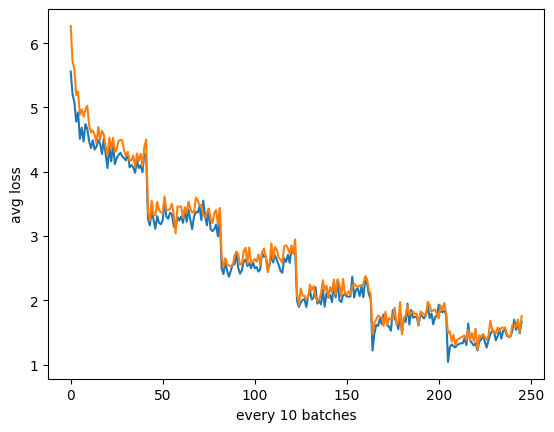

In [ ]:
get_output_by_project('flink',-1,3,None,None,0.1)

INFO:root:Epoch 1, batch 0: 5.0135064125061035
INFO:root:epoch: 1/50, batch: 0/200, avg loss: 5.0135
INFO:root:Epoch 1, batch 0/16: 5.0135064125061035


time:  0h  0min  0s 263ms, remaining:  1h 28min  9s 610ms, epoch:  1/50, batch:   0/200, percent complete:   0.00%, avg loss: 5.0135
Epoch 1, batch 0/16: 5.0135064125061035


INFO:root:Epoch 1, batch 1: 4.93492317199707
INFO:root:Epoch 1, batch 2: 5.411660671234131
INFO:root:Epoch 1, batch 3: 4.789810657501221
INFO:root:Epoch 1, batch 4: 4.132198810577393
INFO:root:Epoch 1, batch 5: 5.945887565612793
INFO:root:Epoch 1, batch 6: 5.335373878479004
INFO:root:Epoch 1, batch 7: 4.850283622741699
INFO:root:Epoch 1, batch 8: 5.305150985717773
INFO:root:Epoch 1, batch 9: 4.812980651855469
INFO:root:Epoch 1, batch 10: 4.094172477722168
INFO:root:Epoch 1, batch 11: 5.357202053070068
INFO:root:Epoch 1, batch 12: 4.2417731285095215
INFO:root:Epoch 1, batch 13: 5.215777397155762
INFO:root:Epoch 1, batch 14: 5.142091274261475
INFO:root:Epoch 1, batch 15: 5.761844635009766
INFO:root:Epoch 1, batch 16: 5.432506561279297
INFO:root:Epoch 1, batch 17: 4.615089416503906
INFO:root:Epoch 1, batch 18: 5.104364395141602
INFO:root:Epoch 1, batch 19: 4.757896423339844
INFO:root:Epoch 1, batch 20: 4.909377574920654
INFO:root:Epoch 1, batch 21: 4.463181018829346
INFO:root:Epoch 1, bat

time:  0h  0min 39s 137ms, remaining:  0h 31min 58s  56ms, epoch:  1/50, batch: 200/200, percent complete:   2.00%, avg loss: 4.5871
Epoch 1, batch 200/16: 917.4294617176056


INFO:root:Epoch 1, batch 202: 4.533849239349365
INFO:root:Epoch 1, batch 203: 4.29136323928833
INFO:root:Epoch 1, batch 204: 4.497852802276611
INFO:root:Epoch 1, batch 205: 3.8994083404541016
INFO:root:Epoch 1, batch 206: 3.9592816829681396
INFO:root:Epoch 1, batch 207: 3.6395766735076904
INFO:root:Epoch 1, batch 208: 4.4342780113220215
INFO:root:Epoch 1, batch 209: 4.017958641052246
INFO:root:Epoch 1, batch 210: 4.830726623535156
INFO:root:Epoch 1, batch 211: 4.640520095825195
INFO:root:Epoch 1, batch 212: 4.372135162353516
INFO:root:Epoch 1, batch 213: 4.431881904602051
INFO:root:Epoch 1, batch 214: 4.214005947113037
INFO:root:Epoch 1, batch 215: 4.312571048736572
INFO:root:Epoch 1, batch 216: 4.255945205688477
INFO:root:Epoch 1, batch 217: 4.56445837020874
INFO:root:Epoch 1, batch 218: 4.174248695373535
INFO:root:Epoch 1, batch 219: 3.8507401943206787
INFO:root:Epoch 1, batch 220: 4.097998142242432
INFO:root:Epoch 1, batch 221: 4.209088325500488
INFO:root:Epoch 1, batch 222: 4.73331

time:  0h  1min 17s 497ms, remaining:  0h 31min  2s 656ms, epoch:  1/50, batch: 400/200, percent complete:   3.99%, avg loss: 4.1721
Epoch 1, batch 400/16: 834.4164388179779

Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0578.


Validate completed, avg loss: 5.0578.



INFO:root:Epoch 2, batch 0: 3.108043909072876
INFO:root:epoch: 2/50, batch: 0/200, avg loss: 3.1080
INFO:root:Epoch 2, batch 0/16: 3.108043909072876


time:  0h  1min 21s 291ms, remaining:  1h  6min 13s 170ms, epoch:  2/50, batch:   0/200, percent complete:   2.00%, avg loss: 3.1080
Epoch 2, batch 0/16: 3.108043909072876


INFO:root:Epoch 2, batch 1: 2.995709180831909
INFO:root:Epoch 2, batch 2: 3.861907720565796
INFO:root:Epoch 2, batch 3: 2.897919178009033
INFO:root:Epoch 2, batch 4: 2.8156511783599854
INFO:root:Epoch 2, batch 5: 3.318755626678467
INFO:root:Epoch 2, batch 6: 3.46478271484375
INFO:root:Epoch 2, batch 7: 3.7993032932281494
INFO:root:Epoch 2, batch 8: 3.115204095840454
INFO:root:Epoch 2, batch 9: 3.2648189067840576
INFO:root:Epoch 2, batch 10: 3.4103150367736816
INFO:root:Epoch 2, batch 11: 4.034382343292236
INFO:root:Epoch 2, batch 12: 3.2665302753448486
INFO:root:Epoch 2, batch 13: 3.222783088684082
INFO:root:Epoch 2, batch 14: 3.463003635406494
INFO:root:Epoch 2, batch 15: 3.2199275493621826
INFO:root:Epoch 2, batch 16: 3.501649856567383
INFO:root:Epoch 2, batch 17: 3.1579501628875732
INFO:root:Epoch 2, batch 18: 4.088769912719727
INFO:root:Epoch 2, batch 19: 3.604564905166626
INFO:root:Epoch 2, batch 20: 3.0898663997650146
INFO:root:Epoch 2, batch 21: 3.2521235942840576
INFO:root:Epoc

time:  0h  1min 59s 184ms, remaining:  0h 47min 40s 651ms, epoch:  2/50, batch: 200/200, percent complete:   4.00%, avg loss: 3.2591
Epoch 2, batch 200/16: 651.8248100280762


INFO:root:Epoch 2, batch 202: 3.711191177368164
INFO:root:Epoch 2, batch 203: 3.061049461364746
INFO:root:Epoch 2, batch 204: 3.2909693717956543
INFO:root:Epoch 2, batch 205: 3.522700071334839
INFO:root:Epoch 2, batch 206: 2.7016561031341553
INFO:root:Epoch 2, batch 207: 2.496939182281494
INFO:root:Epoch 2, batch 208: 3.7629928588867188
INFO:root:Epoch 2, batch 209: 3.5340006351470947
INFO:root:Epoch 2, batch 210: 3.312821865081787
INFO:root:Epoch 2, batch 211: 3.658676862716675
INFO:root:Epoch 2, batch 212: 3.576699733734131
INFO:root:Epoch 2, batch 213: 2.5932512283325195
INFO:root:Epoch 2, batch 214: 3.313601016998291
INFO:root:Epoch 2, batch 215: 3.4439609050750732
INFO:root:Epoch 2, batch 216: 3.3575642108917236
INFO:root:Epoch 2, batch 217: 2.4921813011169434
INFO:root:Epoch 2, batch 218: 3.6538994312286377
INFO:root:Epoch 2, batch 219: 3.0437185764312744
INFO:root:Epoch 2, batch 220: 3.4757938385009766
INFO:root:Epoch 2, batch 221: 3.1448800563812256
INFO:root:Epoch 2, batch 222

time:  0h  2min 38s 121ms, remaining:  0h 41min 19s 704ms, epoch:  2/50, batch: 400/200, percent complete:   5.99%, avg loss: 3.2790
Epoch 2, batch 400/16: 655.7977163791656

Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2555.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.2555.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 3, batch 0: 3.129228115081787
INFO:root:epoch: 3/50, batch: 0/200, avg loss: 3.1292
INFO:root:Epoch 3, batch 0/16: 3.129228115081787
INFO:root:Epoch 3, batch 1: 3.040818929672241


time:  0h  2min 41s 861ms, remaining:  1h  4min 39s 627ms, epoch:  3/50, batch:   0/200, percent complete:   4.00%, avg loss: 3.1292
Epoch 3, batch 0/16: 3.129228115081787


INFO:root:Epoch 3, batch 2: 2.631669521331787
INFO:root:Epoch 3, batch 3: 2.660158157348633
INFO:root:Epoch 3, batch 4: 2.7071266174316406
INFO:root:Epoch 3, batch 5: 3.03893780708313
INFO:root:Epoch 3, batch 6: 2.884366512298584
INFO:root:Epoch 3, batch 7: 2.795715570449829
INFO:root:Epoch 3, batch 8: 2.391633987426758
INFO:root:Epoch 3, batch 9: 2.4117953777313232
INFO:root:Epoch 3, batch 10: 2.065624475479126
INFO:root:Epoch 3, batch 11: 2.925800323486328
INFO:root:Epoch 3, batch 12: 2.4618639945983887
INFO:root:Epoch 3, batch 13: 3.2975172996520996
INFO:root:Epoch 3, batch 14: 2.695239305496216
INFO:root:Epoch 3, batch 15: 2.377916097640991
INFO:root:Epoch 3, batch 16: 2.0220229625701904
INFO:root:Epoch 3, batch 17: 2.1494483947753906
INFO:root:Epoch 3, batch 18: 2.47009015083313
INFO:root:Epoch 3, batch 19: 2.257134437561035
INFO:root:Epoch 3, batch 20: 2.3303987979888916
INFO:root:Epoch 3, batch 21: 3.2063612937927246
INFO:root:Epoch 3, batch 22: 2.749469518661499
INFO:root:Epoch

time:  0h  3min 21s  59ms, remaining:  0h 52min 30s 113ms, epoch:  3/50, batch: 200/200, percent complete:   6.00%, avg loss: 2.5902
Epoch 3, batch 200/16: 518.0373762845993


INFO:root:Epoch 3, batch 201: 3.3080523014068604
INFO:root:Epoch 3, batch 202: 2.605320453643799
INFO:root:Epoch 3, batch 203: 2.8054847717285156
INFO:root:Epoch 3, batch 204: 3.0639634132385254
INFO:root:Epoch 3, batch 205: 2.7800891399383545
INFO:root:Epoch 3, batch 206: 3.0693061351776123
INFO:root:Epoch 3, batch 207: 2.273261070251465
INFO:root:Epoch 3, batch 208: 2.690880060195923
INFO:root:Epoch 3, batch 209: 2.6261544227600098
INFO:root:Epoch 3, batch 210: 2.7722058296203613
INFO:root:Epoch 3, batch 211: 2.5408120155334473
INFO:root:Epoch 3, batch 212: 2.4651544094085693
INFO:root:Epoch 3, batch 213: 2.1978909969329834
INFO:root:Epoch 3, batch 214: 2.5765960216522217
INFO:root:Epoch 3, batch 215: 2.6677627563476562
INFO:root:Epoch 3, batch 216: 2.913599729537964
INFO:root:Epoch 3, batch 217: 2.332343101501465
INFO:root:Epoch 3, batch 218: 3.155606746673584
INFO:root:Epoch 3, batch 219: 2.5052566528320312
INFO:root:Epoch 3, batch 220: 3.137284994125366
INFO:root:Epoch 3, batch 22

time:  0h  3min 59s 367ms, remaining:  0h 45min 54s 828ms, epoch:  3/50, batch: 400/200, percent complete:   7.99%, avg loss: 2.6552
Epoch 3, batch 400/16: 531.036721944809

Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5511.
INFO:root:EarlyStopping counter: 2 out of 5.


Validate completed, avg loss: 5.5511.

EarlyStopping counter: 2 out of 5.



INFO:root:Epoch 4, batch 0: 2.4063785076141357
INFO:root:epoch: 4/50, batch: 0/200, avg loss: 2.4064
INFO:root:Epoch 4, batch 0/16: 2.4063785076141357


time:  0h  4min  3s  17ms, remaining:  1h  3min 23s 906ms, epoch:  4/50, batch:   0/200, percent complete:   6.00%, avg loss: 2.4064
Epoch 4, batch 0/16: 2.4063785076141357


INFO:root:Epoch 4, batch 1: 2.0405938625335693
INFO:root:Epoch 4, batch 2: 1.7517551183700562
INFO:root:Epoch 4, batch 3: 2.241022825241089
INFO:root:Epoch 4, batch 4: 2.1470084190368652
INFO:root:Epoch 4, batch 5: 2.280280351638794
INFO:root:Epoch 4, batch 6: 1.6152944564819336
INFO:root:Epoch 4, batch 7: 1.559946060180664
INFO:root:Epoch 4, batch 8: 1.9191142320632935
INFO:root:Epoch 4, batch 9: 2.47944712638855
INFO:root:Epoch 4, batch 10: 1.7097142934799194
INFO:root:Epoch 4, batch 11: 2.1474101543426514
INFO:root:Epoch 4, batch 12: 2.151672124862671
INFO:root:Epoch 4, batch 13: 1.8011056184768677
INFO:root:Epoch 4, batch 14: 1.885837197303772
INFO:root:Epoch 4, batch 15: 2.4219634532928467
INFO:root:Epoch 4, batch 16: 1.4575077295303345
INFO:root:Epoch 4, batch 17: 2.2737982273101807
INFO:root:Epoch 4, batch 18: 2.0867860317230225
INFO:root:Epoch 4, batch 19: 2.0906713008880615
INFO:root:Epoch 4, batch 20: 1.8890047073364258
INFO:root:Epoch 4, batch 21: 2.291022777557373
INFO:root

time:  0h  4min 41s 710ms, remaining:  0h 53min 59s 803ms, epoch:  4/50, batch: 200/200, percent complete:   8.00%, avg loss: 2.0604
Epoch 4, batch 200/16: 412.07875323295593


INFO:root:Epoch 4, batch 202: 2.202646493911743
INFO:root:Epoch 4, batch 203: 2.0913610458374023
INFO:root:Epoch 4, batch 204: 1.9653054475784302
INFO:root:Epoch 4, batch 205: 2.2389121055603027
INFO:root:Epoch 4, batch 206: 2.1437337398529053
INFO:root:Epoch 4, batch 207: 2.1732728481292725
INFO:root:Epoch 4, batch 208: 1.8486806154251099
INFO:root:Epoch 4, batch 209: 2.124351739883423
INFO:root:Epoch 4, batch 210: 1.758309006690979
INFO:root:Epoch 4, batch 211: 1.5819340944290161
INFO:root:Epoch 4, batch 212: 2.155856132507324
INFO:root:Epoch 4, batch 213: 1.4847471714019775
INFO:root:Epoch 4, batch 214: 2.1908884048461914
INFO:root:Epoch 4, batch 215: 1.766777753829956
INFO:root:Epoch 4, batch 216: 2.482637643814087
INFO:root:Epoch 4, batch 217: 1.8704694509506226
INFO:root:Epoch 4, batch 218: 2.1701719760894775
INFO:root:Epoch 4, batch 219: 2.1568422317504883
INFO:root:Epoch 4, batch 220: 2.0263803005218506
INFO:root:Epoch 4, batch 221: 2.1292316913604736
INFO:root:Epoch 4, batch 2

time:  0h  5min 20s  73ms, remaining:  0h 48min  2s 453ms, epoch:  4/50, batch: 400/200, percent complete:   9.99%, avg loss: 2.1352
Epoch 4, batch 400/16: 427.04011726379395

Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7229.
INFO:root:EarlyStopping counter: 3 out of 5.


Validate completed, avg loss: 5.7229.

EarlyStopping counter: 3 out of 5.



INFO:root:Epoch 5, batch 0: 1.7176487445831299
INFO:root:epoch: 5/50, batch: 0/200, avg loss: 1.7176
INFO:root:Epoch 5, batch 0/16: 1.7176487445831299


time:  0h  5min 23s 595ms, remaining:  1h  1min 58s 824ms, epoch:  5/50, batch:   0/200, percent complete:   8.00%, avg loss: 1.7176
Epoch 5, batch 0/16: 1.7176487445831299


INFO:root:Epoch 5, batch 1: 1.8973201513290405
INFO:root:Epoch 5, batch 2: 1.4943301677703857
INFO:root:Epoch 5, batch 3: 1.8574572801589966
INFO:root:Epoch 5, batch 4: 1.5974023342132568
INFO:root:Epoch 5, batch 5: 1.801466703414917
INFO:root:Epoch 5, batch 6: 1.7566877603530884
INFO:root:Epoch 5, batch 7: 2.0366897583007812
INFO:root:Epoch 5, batch 8: 1.8694820404052734
INFO:root:Epoch 5, batch 9: 2.098261594772339
INFO:root:Epoch 5, batch 10: 1.4005266427993774
INFO:root:Epoch 5, batch 11: 1.5303796529769897
INFO:root:Epoch 5, batch 12: 1.7172622680664062
INFO:root:Epoch 5, batch 13: 1.9268522262573242
INFO:root:Epoch 5, batch 14: 1.2674614191055298
INFO:root:Epoch 5, batch 15: 1.542534351348877
INFO:root:Epoch 5, batch 16: 1.5798956155776978
INFO:root:Epoch 5, batch 17: 1.1569491624832153
INFO:root:Epoch 5, batch 18: 1.7535992860794067
INFO:root:Epoch 5, batch 19: 1.5755032300949097
INFO:root:Epoch 5, batch 20: 1.9571350812911987
INFO:root:Epoch 5, batch 21: 1.635953664779663
INFO:

time:  0h  6min  2s 759ms, remaining:  0h 54min 24s 947ms, epoch:  5/50, batch: 200/200, percent complete:  10.00%, avg loss: 1.6812
Epoch 5, batch 200/16: 336.2475826740265


INFO:root:Epoch 5, batch 202: 2.0388686656951904
INFO:root:Epoch 5, batch 203: 1.7139379978179932
INFO:root:Epoch 5, batch 204: 1.4000253677368164
INFO:root:Epoch 5, batch 205: 1.949887752532959
INFO:root:Epoch 5, batch 206: 1.7147103548049927
INFO:root:Epoch 5, batch 207: 1.945561408996582
INFO:root:Epoch 5, batch 208: 1.9718838930130005
INFO:root:Epoch 5, batch 209: 1.8678547143936157
INFO:root:Epoch 5, batch 210: 1.6254851818084717
INFO:root:Epoch 5, batch 211: 1.45272696018219
INFO:root:Epoch 5, batch 212: 1.838313341140747
INFO:root:Epoch 5, batch 213: 1.7435587644577026
INFO:root:Epoch 5, batch 214: 2.4441685676574707
INFO:root:Epoch 5, batch 215: 1.5938363075256348
INFO:root:Epoch 5, batch 216: 2.3261799812316895
INFO:root:Epoch 5, batch 217: 1.732204556465149
INFO:root:Epoch 5, batch 218: 2.16251277923584
INFO:root:Epoch 5, batch 219: 1.6971901655197144
INFO:root:Epoch 5, batch 220: 1.6160989999771118
INFO:root:Epoch 5, batch 221: 1.8317862749099731
INFO:root:Epoch 5, batch 222

time:  0h  6min 41s 364ms, remaining:  0h 49min  4s 904ms, epoch:  5/50, batch: 400/200, percent complete:  11.99%, avg loss: 1.7854
Epoch 5, batch 400/16: 357.07791793346405

Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.9265.
INFO:root:EarlyStopping counter: 4 out of 5.


Validate completed, avg loss: 5.9265.

EarlyStopping counter: 4 out of 5.



INFO:root:Epoch 6, batch 0: 1.561700701713562
INFO:root:epoch: 6/50, batch: 0/200, avg loss: 1.5617
INFO:root:Epoch 6, batch 0/16: 1.561700701713562
INFO:root:Epoch 6, batch 1: 1.3707327842712402


time:  0h  6min 44s 836ms, remaining:  1h  0min 41s 510ms, epoch:  6/50, batch:   0/200, percent complete:  10.00%, avg loss: 1.5617
Epoch 6, batch 0/16: 1.561700701713562


INFO:root:Epoch 6, batch 2: 1.6501595973968506
INFO:root:Epoch 6, batch 3: 1.5247457027435303
INFO:root:Epoch 6, batch 4: 1.5607919692993164
INFO:root:Epoch 6, batch 5: 1.5633896589279175
INFO:root:Epoch 6, batch 6: 1.3101104497909546
INFO:root:Epoch 6, batch 7: 1.747876763343811
INFO:root:Epoch 6, batch 8: 1.0855892896652222
INFO:root:Epoch 6, batch 9: 1.3979876041412354
INFO:root:Epoch 6, batch 10: 1.2325555086135864
INFO:root:Epoch 6, batch 11: 1.8815248012542725
INFO:root:Epoch 6, batch 12: 1.3319242000579834
INFO:root:Epoch 6, batch 13: 1.6927560567855835
INFO:root:Epoch 6, batch 14: 1.6544057130813599
INFO:root:Epoch 6, batch 15: 1.451137900352478
INFO:root:Epoch 6, batch 16: 1.6382821798324585
INFO:root:Epoch 6, batch 17: 1.012920618057251
INFO:root:Epoch 6, batch 18: 1.6156539916992188
INFO:root:Epoch 6, batch 19: 1.281017541885376
INFO:root:Epoch 6, batch 20: 1.2037073373794556
INFO:root:Epoch 6, batch 21: 1.6124902963638306
INFO:root:Epoch 6, batch 22: 1.7861396074295044
INFO

time:  0h  7min 23s 609ms, remaining:  0h 54min 13s 230ms, epoch:  6/50, batch: 200/200, percent complete:  12.00%, avg loss: 1.4216
Epoch 6, batch 200/16: 284.31977009773254


INFO:root:Epoch 6, batch 201: 1.3040871620178223
INFO:root:Epoch 6, batch 202: 1.3339738845825195
INFO:root:Epoch 6, batch 203: 1.3794186115264893
INFO:root:Epoch 6, batch 204: 1.1691609621047974
INFO:root:Epoch 6, batch 205: 1.545521855354309
INFO:root:Epoch 6, batch 206: 1.2549418210983276
INFO:root:Epoch 6, batch 207: 1.437098741531372
INFO:root:Epoch 6, batch 208: 1.353981375694275
INFO:root:Epoch 6, batch 209: 1.3540780544281006
INFO:root:Epoch 6, batch 210: 2.15061616897583
INFO:root:Epoch 6, batch 211: 1.3624883890151978
INFO:root:Epoch 6, batch 212: 1.5241256952285767
INFO:root:Epoch 6, batch 213: 0.8085885047912598
INFO:root:Epoch 6, batch 214: 1.651943564414978
INFO:root:Epoch 6, batch 215: 1.5102020502090454
INFO:root:Epoch 6, batch 216: 1.3719897270202637
INFO:root:Epoch 6, batch 217: 1.4126392602920532
INFO:root:Epoch 6, batch 218: 1.0903738737106323
INFO:root:Epoch 6, batch 219: 1.1243051290512085
INFO:root:Epoch 6, batch 220: 1.4911385774612427
INFO:root:Epoch 6, batch 2

time:  0h  8min  2s 289ms, remaining:  0h 49min 24s  15ms, epoch:  6/50, batch: 400/200, percent complete:  13.99%, avg loss: 1.4741
Epoch 6, batch 400/16: 294.82203751802444

Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.1854.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.1854.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.742940902709961
INFO:root:epoch: 1/50, batch: 0/200, avg loss: 5.7429
INFO:root:Epoch 1, batch 0/16: 5.742940902709961


time:  0h  0min  0s 266ms, remaining:  1h 29min  4s 923ms, epoch:  1/50, batch:   0/200, percent complete:   0.00%, avg loss: 5.7429
Epoch 1, batch 0/16: 5.742940902709961


INFO:root:Epoch 1, batch 1: 5.677570819854736
INFO:root:Epoch 1, batch 2: 6.242800712585449
INFO:root:Epoch 1, batch 3: 5.085341930389404
INFO:root:Epoch 1, batch 4: 4.588954448699951
INFO:root:Epoch 1, batch 5: 6.061072826385498
INFO:root:Epoch 1, batch 6: 5.972090721130371
INFO:root:Epoch 1, batch 7: 5.2028069496154785
INFO:root:Epoch 1, batch 8: 5.627115726470947
INFO:root:Epoch 1, batch 9: 5.404147624969482
INFO:root:Epoch 1, batch 10: 5.055605411529541
INFO:root:Epoch 1, batch 11: 5.701250076293945
INFO:root:Epoch 1, batch 12: 4.81707763671875
INFO:root:Epoch 1, batch 13: 5.90048885345459
INFO:root:Epoch 1, batch 14: 5.624917507171631
INFO:root:Epoch 1, batch 15: 5.682809352874756
INFO:root:Epoch 1, batch 16: 5.564873218536377
INFO:root:Epoch 1, batch 17: 4.861313819885254
INFO:root:Epoch 1, batch 18: 5.214199066162109
INFO:root:Epoch 1, batch 19: 5.160788059234619
INFO:root:Epoch 1, batch 20: 5.202014923095703
INFO:root:Epoch 1, batch 21: 4.874455451965332
INFO:root:Epoch 1, batc

time:  0h  0min 39s  38ms, remaining:  0h 31min 53s 176ms, epoch:  1/50, batch: 200/200, percent complete:   2.00%, avg loss: 4.8331
Epoch 1, batch 200/16: 966.6245617866516


INFO:root:Epoch 1, batch 202: 4.796963691711426
INFO:root:Epoch 1, batch 203: 4.65570592880249
INFO:root:Epoch 1, batch 204: 4.103373050689697
INFO:root:Epoch 1, batch 205: 3.928007125854492
INFO:root:Epoch 1, batch 206: 4.204945087432861
INFO:root:Epoch 1, batch 207: 4.13460111618042
INFO:root:Epoch 1, batch 208: 4.932549953460693
INFO:root:Epoch 1, batch 209: 3.7446038722991943
INFO:root:Epoch 1, batch 210: 4.784657001495361
INFO:root:Epoch 1, batch 211: 4.679432392120361
INFO:root:Epoch 1, batch 212: 4.447569847106934
INFO:root:Epoch 1, batch 213: 4.586439609527588
INFO:root:Epoch 1, batch 214: 4.56068229675293
INFO:root:Epoch 1, batch 215: 4.579178810119629
INFO:root:Epoch 1, batch 216: 4.83555793762207
INFO:root:Epoch 1, batch 217: 4.55411958694458
INFO:root:Epoch 1, batch 218: 4.275432586669922
INFO:root:Epoch 1, batch 219: 3.716059684753418
INFO:root:Epoch 1, batch 220: 4.293888568878174
INFO:root:Epoch 1, batch 221: 4.310865879058838
INFO:root:Epoch 1, batch 222: 5.092914104461

time:  0h  1min 17s 804ms, remaining:  0h 31min 10s  38ms, epoch:  1/50, batch: 400/200, percent complete:   3.99%, avg loss: 4.3251
Epoch 1, batch 400/16: 865.025328874588

Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1437.


Validate completed, avg loss: 5.1437.



INFO:root:Epoch 2, batch 0: 3.2303476333618164
INFO:root:epoch: 2/50, batch: 0/200, avg loss: 3.2303
INFO:root:Epoch 2, batch 0/16: 3.2303476333618164


time:  0h  1min 21s 296ms, remaining:  1h  6min 13s 439ms, epoch:  2/50, batch:   0/200, percent complete:   2.00%, avg loss: 3.2303
Epoch 2, batch 0/16: 3.2303476333618164


INFO:root:Epoch 2, batch 1: 2.985130786895752
INFO:root:Epoch 2, batch 2: 3.9343130588531494
INFO:root:Epoch 2, batch 3: 3.44145131111145
INFO:root:Epoch 2, batch 4: 3.433152198791504
INFO:root:Epoch 2, batch 5: 4.039050102233887
INFO:root:Epoch 2, batch 6: 3.746640205383301
INFO:root:Epoch 2, batch 7: 3.89005970954895
INFO:root:Epoch 2, batch 8: 3.3702707290649414
INFO:root:Epoch 2, batch 9: 3.76131534576416
INFO:root:Epoch 2, batch 10: 3.260981321334839
INFO:root:Epoch 2, batch 11: 4.334106922149658
INFO:root:Epoch 2, batch 12: 3.777820587158203
INFO:root:Epoch 2, batch 13: 3.5362892150878906
INFO:root:Epoch 2, batch 14: 3.71450138092041
INFO:root:Epoch 2, batch 15: 3.3735759258270264
INFO:root:Epoch 2, batch 16: 3.479567766189575
INFO:root:Epoch 2, batch 17: 3.1291913986206055
INFO:root:Epoch 2, batch 18: 4.229707717895508
INFO:root:Epoch 2, batch 19: 3.592174768447876
INFO:root:Epoch 2, batch 20: 3.3711156845092773
INFO:root:Epoch 2, batch 21: 3.6229586601257324
INFO:root:Epoch 2, 

time:  0h  1min 59s 463ms, remaining:  0h 47min 47s 345ms, epoch:  2/50, batch: 200/200, percent complete:   4.00%, avg loss: 3.4040
Epoch 2, batch 200/16: 680.8030955791473


INFO:root:Epoch 2, batch 202: 3.958575963973999
INFO:root:Epoch 2, batch 203: 2.714041233062744
INFO:root:Epoch 2, batch 204: 3.352877140045166
INFO:root:Epoch 2, batch 205: 3.65671443939209
INFO:root:Epoch 2, batch 206: 3.218712091445923
INFO:root:Epoch 2, batch 207: 2.685055732727051
INFO:root:Epoch 2, batch 208: 3.8721911907196045
INFO:root:Epoch 2, batch 209: 3.690539598464966
INFO:root:Epoch 2, batch 210: 3.417677402496338
INFO:root:Epoch 2, batch 211: 3.696807384490967
INFO:root:Epoch 2, batch 212: 3.774756908416748
INFO:root:Epoch 2, batch 213: 2.962376117706299
INFO:root:Epoch 2, batch 214: 3.4234976768493652
INFO:root:Epoch 2, batch 215: 3.553719997406006
INFO:root:Epoch 2, batch 216: 3.555466890335083
INFO:root:Epoch 2, batch 217: 2.508997917175293
INFO:root:Epoch 2, batch 218: 3.432478904724121
INFO:root:Epoch 2, batch 219: 3.146449089050293
INFO:root:Epoch 2, batch 220: 3.7964863777160645
INFO:root:Epoch 2, batch 221: 2.9642162322998047
INFO:root:Epoch 2, batch 222: 3.48930

time:  0h  2min 38s 526ms, remaining:  0h 41min 26s  55ms, epoch:  2/50, batch: 400/200, percent complete:   5.99%, avg loss: 3.4141
Epoch 2, batch 400/16: 682.8277084827423

Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2867.
INFO:root:EarlyStopping counter: 1 out of 5.


Validate completed, avg loss: 5.2867.

EarlyStopping counter: 1 out of 5.



INFO:root:Epoch 3, batch 0: 2.9236981868743896
INFO:root:epoch: 3/50, batch: 0/200, avg loss: 2.9237
INFO:root:Epoch 3, batch 0/16: 2.9236981868743896
INFO:root:Epoch 3, batch 1: 2.8940742015838623


time:  0h  2min 41s 998ms, remaining:  1h  4min 42s 919ms, epoch:  3/50, batch:   0/200, percent complete:   4.00%, avg loss: 2.9237
Epoch 3, batch 0/16: 2.9236981868743896


INFO:root:Epoch 3, batch 2: 3.2176597118377686
INFO:root:Epoch 3, batch 3: 2.6962947845458984
INFO:root:Epoch 3, batch 4: 2.2817933559417725
INFO:root:Epoch 3, batch 5: 3.0951128005981445
INFO:root:Epoch 3, batch 6: 2.6966922283172607
INFO:root:Epoch 3, batch 7: 2.845412254333496
INFO:root:Epoch 3, batch 8: 2.8102293014526367
INFO:root:Epoch 3, batch 9: 2.290248394012451
INFO:root:Epoch 3, batch 10: 1.8758784532546997
INFO:root:Epoch 3, batch 11: 2.4559946060180664
INFO:root:Epoch 3, batch 12: 3.0970330238342285
INFO:root:Epoch 3, batch 13: 3.132359027862549
INFO:root:Epoch 3, batch 14: 2.606013298034668
INFO:root:Epoch 3, batch 15: 2.5200729370117188
INFO:root:Epoch 3, batch 16: 2.1495516300201416
INFO:root:Epoch 3, batch 17: 2.860666513442993
INFO:root:Epoch 3, batch 18: 2.7856030464172363
INFO:root:Epoch 3, batch 19: 2.6109657287597656
INFO:root:Epoch 3, batch 20: 2.6509158611297607
INFO:root:Epoch 3, batch 21: 3.0568246841430664
INFO:root:Epoch 3, batch 22: 3.0863327980041504
INFO:

time:  0h  3min 21s 279ms, remaining:  0h 52min 33s 552ms, epoch:  3/50, batch: 200/200, percent complete:   6.00%, avg loss: 2.6679
Epoch 3, batch 200/16: 533.5739965438843


INFO:root:Epoch 3, batch 201: 2.885962724685669
INFO:root:Epoch 3, batch 202: 2.6117238998413086
INFO:root:Epoch 3, batch 203: 2.9991023540496826
INFO:root:Epoch 3, batch 204: 3.418433904647827
INFO:root:Epoch 3, batch 205: 2.802504062652588
INFO:root:Epoch 3, batch 206: 2.7784535884857178
INFO:root:Epoch 3, batch 207: 2.3688981533050537
INFO:root:Epoch 3, batch 208: 3.120422124862671
INFO:root:Epoch 3, batch 209: 2.6680049896240234
INFO:root:Epoch 3, batch 210: 3.12121844291687
INFO:root:Epoch 3, batch 211: 2.556271553039551
INFO:root:Epoch 3, batch 212: 2.484022617340088
INFO:root:Epoch 3, batch 213: 2.4411559104919434
INFO:root:Epoch 3, batch 214: 2.5404160022735596
INFO:root:Epoch 3, batch 215: 2.8390440940856934
INFO:root:Epoch 3, batch 216: 2.777052164077759
INFO:root:Epoch 3, batch 217: 2.6072306632995605
INFO:root:Epoch 3, batch 218: 2.544741630554199
INFO:root:Epoch 3, batch 219: 3.1614038944244385
INFO:root:Epoch 3, batch 220: 3.1115758419036865
INFO:root:Epoch 3, batch 221: 

time:  0h  3min 59s 508ms, remaining:  0h 45min 56s 443ms, epoch:  3/50, batch: 400/200, percent complete:   7.99%, avg loss: 2.7035
Epoch 3, batch 400/16: 540.6974738836288

Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5848.
INFO:root:EarlyStopping counter: 2 out of 5.


Validate completed, avg loss: 5.5848.

EarlyStopping counter: 2 out of 5.



INFO:root:Epoch 4, batch 0: 2.7272095680236816
INFO:root:epoch: 4/50, batch: 0/200, avg loss: 2.7272
INFO:root:Epoch 4, batch 0/16: 2.7272095680236816
INFO:root:Epoch 4, batch 1: 2.37589693069458


time:  0h  4min  2s 965ms, remaining:  1h  3min 23s  92ms, epoch:  4/50, batch:   0/200, percent complete:   6.00%, avg loss: 2.7272
Epoch 4, batch 0/16: 2.7272095680236816


INFO:root:Epoch 4, batch 2: 2.0138580799102783
INFO:root:Epoch 4, batch 3: 2.4282498359680176
INFO:root:Epoch 4, batch 4: 2.409792423248291
INFO:root:Epoch 4, batch 5: 2.382598638534546
INFO:root:Epoch 4, batch 6: 1.4738572835922241
INFO:root:Epoch 4, batch 7: 1.7610663175582886
INFO:root:Epoch 4, batch 8: 2.223008155822754
INFO:root:Epoch 4, batch 9: 2.783463716506958
INFO:root:Epoch 4, batch 10: 1.4659909009933472
INFO:root:Epoch 4, batch 11: 2.4349582195281982
INFO:root:Epoch 4, batch 12: 2.109346866607666
INFO:root:Epoch 4, batch 13: 2.2711853981018066
INFO:root:Epoch 4, batch 14: 2.0358824729919434
INFO:root:Epoch 4, batch 15: 2.9617137908935547
INFO:root:Epoch 4, batch 16: 1.6167875528335571
INFO:root:Epoch 4, batch 17: 2.2488114833831787
INFO:root:Epoch 4, batch 18: 2.333836793899536
INFO:root:Epoch 4, batch 19: 2.161832332611084
INFO:root:Epoch 4, batch 20: 1.9755898714065552
INFO:root:Epoch 4, batch 21: 2.250950336456299
INFO:root:Epoch 4, batch 22: 2.629545211791992
INFO:root

time:  0h  4min 41s 717ms, remaining:  0h 53min 59s 892ms, epoch:  4/50, batch: 200/200, percent complete:   8.00%, avg loss: 2.1171
Epoch 4, batch 200/16: 423.4223561286926


INFO:root:Epoch 4, batch 202: 2.1789443492889404
INFO:root:Epoch 4, batch 203: 2.486739158630371
INFO:root:Epoch 4, batch 204: 1.8161691427230835
INFO:root:Epoch 4, batch 205: 2.144045829772949
INFO:root:Epoch 4, batch 206: 2.398468255996704
INFO:root:Epoch 4, batch 207: 2.271181344985962
INFO:root:Epoch 4, batch 208: 1.8747975826263428
INFO:root:Epoch 4, batch 209: 2.350969076156616
INFO:root:Epoch 4, batch 210: 2.174534797668457
INFO:root:Epoch 4, batch 211: 1.8239614963531494
INFO:root:Epoch 4, batch 212: 2.1368958950042725
INFO:root:Epoch 4, batch 213: 1.5530295372009277
INFO:root:Epoch 4, batch 214: 2.171079397201538
INFO:root:Epoch 4, batch 215: 2.275068521499634
INFO:root:Epoch 4, batch 216: 2.312816858291626
INFO:root:Epoch 4, batch 217: 2.186129570007324
INFO:root:Epoch 4, batch 218: 2.1589300632476807
INFO:root:Epoch 4, batch 219: 2.2413978576660156
INFO:root:Epoch 4, batch 220: 2.102343797683716
INFO:root:Epoch 4, batch 221: 2.413012981414795
INFO:root:Epoch 4, batch 222: 1.

time:  0h  5min 20s 341ms, remaining:  0h 48min  4s 874ms, epoch:  4/50, batch: 400/200, percent complete:   9.99%, avg loss: 2.1910
Epoch 4, batch 400/16: 438.2044475078583

Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7835.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.8384202718734741


Validate completed, avg loss: 5.7835.

EarlyStopping counter: 3 out of 5.



INFO:root:epoch: 5/50, batch: 0/200, avg loss: 1.8384
INFO:root:Epoch 5, batch 0/16: 1.8384202718734741


time:  0h  5min 23s 759ms, remaining:  1h  2min  0s 712ms, epoch:  5/50, batch:   0/200, percent complete:   8.00%, avg loss: 1.8384
Epoch 5, batch 0/16: 1.8384202718734741


INFO:root:Epoch 5, batch 1: 1.6620464324951172
INFO:root:Epoch 5, batch 2: 1.4956176280975342
INFO:root:Epoch 5, batch 3: 1.6773616075515747
INFO:root:Epoch 5, batch 4: 1.4689868688583374
INFO:root:Epoch 5, batch 5: 1.9523128271102905
INFO:root:Epoch 5, batch 6: 1.6780081987380981
INFO:root:Epoch 5, batch 7: 1.5869741439819336
INFO:root:Epoch 5, batch 8: 2.300980806350708
INFO:root:Epoch 5, batch 9: 1.8183667659759521
INFO:root:Epoch 5, batch 10: 1.5439951419830322
INFO:root:Epoch 5, batch 11: 2.0970988273620605
INFO:root:Epoch 5, batch 12: 1.5107301473617554
INFO:root:Epoch 5, batch 13: 2.005315065383911
INFO:root:Epoch 5, batch 14: 1.1474820375442505
INFO:root:Epoch 5, batch 15: 1.4458045959472656
INFO:root:Epoch 5, batch 16: 1.4487555027008057
INFO:root:Epoch 5, batch 17: 1.296984076499939
INFO:root:Epoch 5, batch 18: 1.7262927293777466
INFO:root:Epoch 5, batch 19: 1.801053524017334
INFO:root:Epoch 5, batch 20: 1.5276027917861938
INFO:root:Epoch 5, batch 21: 1.717271327972412
INFO:r

time:  0h  6min  2s 828ms, remaining:  0h 54min 25s 566ms, epoch:  5/50, batch: 200/200, percent complete:  10.00%, avg loss: 1.7201
Epoch 5, batch 200/16: 344.01412177085876


INFO:root:Epoch 5, batch 202: 1.8911577463150024
INFO:root:Epoch 5, batch 203: 2.2141098976135254
INFO:root:Epoch 5, batch 204: 1.3838597536087036
INFO:root:Epoch 5, batch 205: 1.7718420028686523
INFO:root:Epoch 5, batch 206: 1.5850149393081665
INFO:root:Epoch 5, batch 207: 1.5606791973114014
INFO:root:Epoch 5, batch 208: 1.9159157276153564
INFO:root:Epoch 5, batch 209: 1.9085588455200195
INFO:root:Epoch 5, batch 210: 1.7477080821990967
INFO:root:Epoch 5, batch 211: 1.5515211820602417
INFO:root:Epoch 5, batch 212: 1.7613115310668945
INFO:root:Epoch 5, batch 213: 1.8877885341644287
INFO:root:Epoch 5, batch 214: 2.0014970302581787
INFO:root:Epoch 5, batch 215: 1.4444915056228638
INFO:root:Epoch 5, batch 216: 2.17215633392334
INFO:root:Epoch 5, batch 217: 1.8041695356369019
INFO:root:Epoch 5, batch 218: 2.267533779144287
INFO:root:Epoch 5, batch 219: 1.599151611328125
INFO:root:Epoch 5, batch 220: 1.5885865688323975
INFO:root:Epoch 5, batch 221: 2.160979986190796
INFO:root:Epoch 5, batch 

time:  0h  6min 41s 473ms, remaining:  0h 49min  5s 700ms, epoch:  5/50, batch: 400/200, percent complete:  11.99%, avg loss: 1.8558
Epoch 5, batch 400/16: 371.15466928482056

Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.9501.
INFO:root:EarlyStopping counter: 4 out of 5.


Validate completed, avg loss: 5.9501.

EarlyStopping counter: 4 out of 5.



INFO:root:Epoch 6, batch 0: 1.1415122747421265
INFO:root:epoch: 6/50, batch: 0/200, avg loss: 1.1415
INFO:root:Epoch 6, batch 0/16: 1.1415122747421265
INFO:root:Epoch 6, batch 1: 1.203066349029541


time:  0h  6min 44s 950ms, remaining:  1h  0min 42s 539ms, epoch:  6/50, batch:   0/200, percent complete:  10.00%, avg loss: 1.1415
Epoch 6, batch 0/16: 1.1415122747421265


INFO:root:Epoch 6, batch 2: 1.4592413902282715
INFO:root:Epoch 6, batch 3: 1.699136734008789
INFO:root:Epoch 6, batch 4: 1.8407620191574097
INFO:root:Epoch 6, batch 5: 1.6161904335021973
INFO:root:Epoch 6, batch 6: 1.4963557720184326
INFO:root:Epoch 6, batch 7: 1.4903137683868408
INFO:root:Epoch 6, batch 8: 1.162970781326294
INFO:root:Epoch 6, batch 9: 1.1809343099594116
INFO:root:Epoch 6, batch 10: 1.312441110610962
INFO:root:Epoch 6, batch 11: 1.6547149419784546
INFO:root:Epoch 6, batch 12: 1.7604126930236816
INFO:root:Epoch 6, batch 13: 1.838278889656067
INFO:root:Epoch 6, batch 14: 1.6392995119094849
INFO:root:Epoch 6, batch 15: 1.159361720085144
INFO:root:Epoch 6, batch 16: 1.6250014305114746
INFO:root:Epoch 6, batch 17: 1.193745732307434
INFO:root:Epoch 6, batch 18: 1.7128551006317139
INFO:root:Epoch 6, batch 19: 1.4541735649108887
INFO:root:Epoch 6, batch 20: 1.5163558721542358
INFO:root:Epoch 6, batch 21: 1.7243555784225464
INFO:root:Epoch 6, batch 22: 1.60084867477417
INFO:roo

time:  0h  7min 23s 855ms, remaining:  0h 54min 15s  34ms, epoch:  6/50, batch: 200/200, percent complete:  12.00%, avg loss: 1.4441
Epoch 6, batch 200/16: 288.82563507556915


INFO:root:Epoch 6, batch 201: 1.751499891281128
INFO:root:Epoch 6, batch 202: 1.459439754486084
INFO:root:Epoch 6, batch 203: 1.6936585903167725
INFO:root:Epoch 6, batch 204: 1.5097460746765137
INFO:root:Epoch 6, batch 205: 1.6040908098220825
INFO:root:Epoch 6, batch 206: 1.2619831562042236
INFO:root:Epoch 6, batch 207: 1.243195652961731
INFO:root:Epoch 6, batch 208: 1.5615739822387695
INFO:root:Epoch 6, batch 209: 1.651620626449585
INFO:root:Epoch 6, batch 210: 1.9917770624160767
INFO:root:Epoch 6, batch 211: 1.8272656202316284
INFO:root:Epoch 6, batch 212: 1.7430468797683716
INFO:root:Epoch 6, batch 213: 1.195172667503357
INFO:root:Epoch 6, batch 214: 1.4737106561660767
INFO:root:Epoch 6, batch 215: 1.447473406791687
INFO:root:Epoch 6, batch 216: 1.207421064376831
INFO:root:Epoch 6, batch 217: 1.2727618217468262
INFO:root:Epoch 6, batch 218: 1.237795114517212
INFO:root:Epoch 6, batch 219: 1.0949326753616333
INFO:root:Epoch 6, batch 220: 1.6499862670898438
INFO:root:Epoch 6, batch 221

time:  0h  8min  2s 673ms, remaining:  0h 49min 26s 374ms, epoch:  6/50, batch: 400/200, percent complete:  13.99%, avg loss: 1.5216
Epoch 6, batch 400/16: 304.327086687088

Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 6.2043.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 6.2043.

EarlyStopping counter: 5 out of 5.

Early stop.

public static String translateToJSONExecutionPlan(Pipeline pipeline) {
    FlinkPipelineTranslator pipelineTranslator = getPipelineTranslator(pipeline);
    return pipelineTranslator.translateToJSONExecutionPlan(pipeline);
}
Reference:  extracts the execution plan as json from the given pipeline
MAML:  converts the given pipeline to a into a string representation of the
Baseline:  translates a given execution into into a string representation
public static FromClasspathEntryClassInformationProvider createFromClasspath(
        Iterable<URL> classpath) throws IOException, FlinkException {
    return new FromClasspathEntryClassInformationProvider(
            extractJobClassFromUrlClasspath(classpath));
}
Reference:  creates a from classpath entry class information provider looking for the entry class providing the main method on the passed classpath
MAML:  creates a from classpath entry class informa

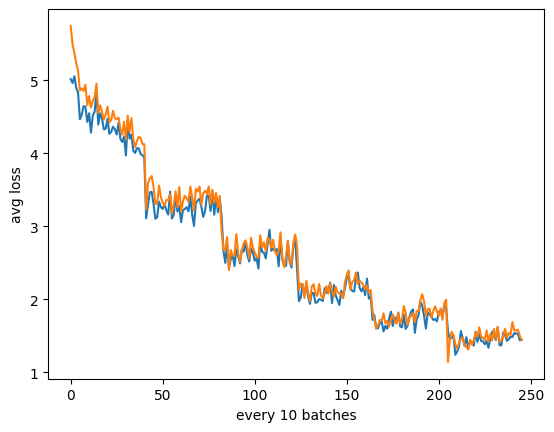

In [ ]:
get_output_by_project('flink',-1,4,None,None,0.1)